# Section I: Project Overview

## Project Description:

Household formation is generally recognized as an important driver of economic growth, prosperity, and human flourisihing. But what does it mean to be a household? Households can take on many different compositions. This analysis examines household composition, and the relationship of household composition to markers of prosperity, by country and over time. In essence, this project aims to answer, "What types of household configurations predict a happy lives?" 

A number of proxies for "happy" are considered. Initially, HDI (Human Development Index) is chosen as a proxy, but this causes indirect data leakage with many features. Gini Index values are imported to reduce the potential for data leakage. 

**Finally, I create a weighted Gini index, to reduce the influence of high-equality low-GDP countries in the target. Equality in a populace is not the best measure of human flourishing, if the people in question are equally poor.** 

The main methodological goal of this project for treating missing values is to logically impute as many values as possible. I wanted to conduct data imputation as if I were tasked with replacing those missing values as factually as possible. I compare provisional imputation strategies aimed at model performance only to fact-based imputation.


## Data Sources:

Four (4) distinct datasets are used in this analysis:

The core dataset is the "CoResidence Database", which was assembled by researchers at the University of Barcelona, for the EU Open Research Repository (pilot). Researchers compiled information about household configurations over time, from 1964-2023, both nationally and subnationally. 

Additional data tables were merged with core features in order to impute missing values in core features.

Data sets are described below.


### 1) CoResidence National Database
The CORESIDENCE Database: National and Subnational Data on Household and Living Arrangements Around the World, 1964-2021

This database is the core table used in this analysis. Only national data is used. National table consists of 809 entries and 178 features (1 out of 179 was a metadata tag and was dropped). 156 countries are represented. Not all countries have all data for all years in the time series range.

What I refer to as "core features" describe household composition. Population/economic data features are also included.

A separate metadata table Codebook decodes column names, which are all encoded. The column 'Sub_family' in the Codebook table denotes four categories of core features:

1) Household headship (HH)
2) Size and age composition (HS)
3) Relationship to head (HR)
4) Household typology (HT)

More detail about each sub family can be found in Section II.

Other key features of the countries in question are included, such as GDP, fertility rate, Human Development Index. These features have null values in many rows.

**Citation**: Esteve, A., Galeano, J., Turu, A., García-Román, J., Becca, F., Fang, H., Pohl, M. L. C., & Trias Prat, R. (2023).  Zenodo. https://doi.org/10.5281/zenodo.8142652

### 2) Merge I - The Gini Index 

The Gini Index measures the extent to which the distribution of income (or, in some cases, consumption expenditure) among individuals or households within an economy deviates from a perfectly equal distribution. Gini values range from 0 to 100. 

A Lorenz curve plots the cumulative percentages of total income received against the cumulative number of recipients, starting with the poorest individual or household. The Gini Index measures the area between the Lorenz curve and a hypothetical line of absolute equality, expressed as a percentage of the maximum area under the line. Thus a Gini index of 0 represents perfect equality, while an index of 100 implies perfect inequality.

**Citation**: World Bank, Poverty and Inequality Platform. Data are based on primary household survey data obtained from government statistical agencies and World Bank country departments. Data for high-income economies are mostly from the Luxembourg Income Study database. For more information and methodology, please see pip.worldbank.org. 

https://data.worldbank.org/indicator/SI.POV.GINI

### 3) Merge II - UNPD Most Used

United Nations Population Division "Most Used" Table consists of most commonly used indicators pertaining to the populations of all countries.

https://population.un.org/wpp/Download/Standard/MostUsed/

Copyright © 2024 by United Nations, made available under a Creative Commons license CC BY 3.0 IGO: http://creativecommons.org/licenses/by/3.0/igo/ Suggested citation: United Nations, Department of Economic and Social Affairs, Population Division (2024). World Population Prospects 2024, Online Edition.


### 4) Merge III - UNDP

United Nations Development Programme. Table consists of all composite indices of the HDI (Human Development Index).

Citation not found. Data can be found at division website: https://hdr.undp.org/data-center/documentation-and-downloads


# Library Imports & Formulas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import itertools


# Feature Selection

from sklearn.feature_selection import mutual_info_regression

# Model Selection
from sklearn.model_selection import cross_val_score, cross_validate, KFold, TimeSeriesSplit

# Linear Model
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# Word Matching
from thefuzz import process, fuzz


# Data Imputation

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer

from sklearn.decomposition import TruncatedSVD, NMF

# Estimators
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler



In [2]:
# Write a formula to streamline this modelling loop

def tscv_loop(X, y, n_splits, models=None):
    """ 
    Runs cross validation on a time series split and evaluates models. Data must be sorted by time units.
    
    Parameters: 
    - X (DataFrame): Feature matrix
    - y (Series): Target variable
    - n_splits (Integer): (TimeSeriesSplit number of splits)
    - models (dict): Dictionary of model names and initialized models. Defaults to Lasso, Ridge, and Random Forest
    
    Returns: DataFrame: Train/Test scores for each fold
    """
    
    if models is None:
        models = {
            "Linear Regression" : LinearRegression(),
            "Lasso" : Lasso(alpha=0.1),
            "Ridge" : Ridge(),
            "Random Forest" : RandomForestRegressor(random_state=21)
                 }
        
    results = []
    
    tscv = TimeSeriesSplit(n_splits = n_splits)
    
    for i, (train_index, test_index) in enumerate(tscv.split(X)):
        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        X_test, y_test = X.iloc[test_index], y.iloc[test_index]
        
        fold_scores = {"Fold":i+1}
    
        for model_name, model in models.items():
            model.fit(X_train, y_train)
            train_score = model.score(X_train, y_train)
            test_score = model.score(X_test, y_test)
        
            fold_scores[f"{model_name} Train Score"] = train_score
            fold_scores[f"{model_name} Test Score"] = test_score
            
            if model is RandomForestRegressor() or GradientBoostRegressor():
                feature_importances = model.feature_importances_
        
        results.append(fold_scores)
        #print(fold_scores)
    
    return pd.DataFrame(results), model.feature_importances_

# Section II: Data Validation

## Table 1: Core Table and Metadata: 

CoResidence (df) and metadata table Codebook (code_dict)

Only "National" data has been used in this analysis. For validation purposes, sub-national data is examined. For some countries, national data appears to be mean of sub-national data, per year; whereas other countries have national data that is not a simple mean of subnational data. Sub-national year range is smaller or equal to the range represented in national data. In other words, sub-national data is equally or less comprehensive in terms of timeseries range.

Original shape of National dataset: (809, 179)

Feature groups:
- Core features describe household configuration and are in columns whose names start with 'H' ('HH', 'HS', 'HT', 'HR')
- Supplemental features pertaining to population or economy are in columns whose names start in 'D' or 'P'
- Place and Timeseries column names start with C (Country Name, Country Code) or T (Year)

Null values are distributed throughout, but mostly found outside of core features columns. 
- 91 columns out of 179 contain null values. Most of these missing values are not in core features
- Four rows (218, 219, 427, 428), which contain large sections of missing values in core features were b/ffilled
- All other missing values pertain to HT (household typology) group
- Columns HT18 and HT31 contain 530 null values converted to zero based on context (see II.3)
- All 809 rows contain at least one null value

Core features consist of two types: Proportions and Averages. For the most part, proportion categories belong to groups of columns, which sum to 1. Some proportion features are absolute proportions, as they are not part of any set of columns that adds to 1.

In [3]:
# Read in National Coresidence Dataset

df = pd.read_csv("./A0_CORESIDENCE_NATIONAL_DATASET_2024.csv",
                index_col='Unnamed: 0')

In [4]:
# Inspect table
df.head()

C0   C1           C2             C3               C4    T1    T2  T3    T5  \
1  AF  AFG  Afghanistan           ASIA    Southern Asia  2015  2010   1  2011   
2  AO  AGO       Angola         AFRICA    Middle Africa  2015  2010   1  2011   
3  AL  ALB      Albania         EUROPE  Southern Europe  2008  2010   0  2006   
4  AL  ALB      Albania         EUROPE  Southern Europe  2017  2020   1  2016   
5  AR  ARG    Argentina  LATIN-AMERICA    South America  1970  1970   0  1966   

    T10  ...            D6        D7         D8         D9           D10  \
1  2010  ...   2101.589319  0.364833   7.791942   1.272154    681.131699   
2  2010  ...   7652.656486  0.549279  10.690100   3.657993   6626.812049   
3  2000  ...   9962.442236  0.715264  12.348200   8.771930   7208.741202   
4  2010  ...  12802.148310  0.797816  15.511230  11.122311  10148.612870   
5  1960  ...           NaN       NaN        NaN        NaN           NaN   

        D11       D12        D13           D14        DB  
1  0.542189  12.44832   3.015346   3489.646939  NATIONAL  
2  0.614968  12.70450   5.922784   8705.839878  NATIONAL  
3  0.753432  11.90664   9.836990  12720.559540  NATIONAL  
4  0.805385  14.17994  10.721275  15442.824030  NATIONAL  
5       NaN       NaN        NaN           NaN  NATIONAL  

[5 rows x 179 columns]

In [5]:
# inspect C3 regions
df['C3'].value_counts()

AFRICA           241
EUROPE           212
ASIA             167
LATIN-AMERICA    144
OCEANIA           32
NORTH-AMERICA     11
Eastern Asia       2
Name: C3, dtype: int64

In [6]:
# Read in Sub-National Coresidence Dataset

subnat_df = pd.read_csv("./A1_CORESIDENCE_SUBNATIONAL_DATASET.csv"
                      )

In [7]:
# Read in dataset metadata to interpret column names of coresidence
code_dict = pd.read_csv('./CODEBOOK_2024.csv', usecols=['Code', 'Sub_family', 'Description'])

# Cols excluded contain uni-value tags not needed in this analysis

In [8]:
# What kind of year ranges are represented in subnational data vs. national data

subnat_range = (subnat_df
                .groupby('C1', group_keys=False)['T1']
                .apply(lambda x: max(x)-min(x))
                .sort_values(ascending=False))

nat_range = (df
             .groupby('C1', group_keys=False)['T1']
             .apply(lambda x: max(x)-min(x))
             .sort_values(ascending=False))

range_comp = pd.concat((subnat_range, nat_range), axis=1)
range_comp.columns = ['Sub National', 'National']
range_comp['Diff'] = range_comp['Sub National'] - range_comp['National']
range_comp['Diff'].value_counts().sort_index()

# National data has same or larger range than sub-national

-30.0      1
-25.0      1
-24.0      1
-21.0      1
-20.0      2
-15.0      2
-12.0      1
-11.0      1
-10.0      4
-8.0       1
-6.0       2
-5.0       5
-2.0       1
 0.0     127
Name: Diff, dtype: int64

In [9]:
# spot check if national numbers are a mean of subnational numbers

subnat_mean = subnat_df[(subnat_df['C1']=='USA') & (subnat_df['T1']==1980)].mean(numeric_only=True)

subnat_usa_1980 = subnat_mean[subnat_mean.index.str.startswith('H')]
           

In [10]:
# Spot check subnational data mean against national data for that year
# It appears that national data for USA is approximately a mean of subnational data per year

df_usa_1980 = df.loc[(df['C1']=='USA') & (df['T1']==1980), df.columns.str.startswith('H')]

nat_sub_comp = pd.concat((subnat_usa_1980.T, df_usa_1980.T), axis=1)

nat_sub_comp.columns = ['Sub National', 'National']

nat_sub_comp['Diff'] = nat_sub_comp['Sub National'] - nat_sub_comp['National']

print(f" Max difference = {nat_sub_comp['Diff'].max()}")

 Max difference = 0.024179601702638887


In [11]:
# Do this for all countries

for country in list(df['C1'].unique()):
    for year in range(1964, 2024):
        subnat_annual_mean = (subnat_df
                              .loc[(subnat_df['C1']==country) & (subnat_df['T1']==year), 
                                   subnat_df.columns.str.startswith('H')]
                              .mean())
         
        nat_annual = (df
                      .loc[(df['C1']==country) & (df['T1']==year), 
                           df.columns.str.startswith('H')])
        
        if not subnat_annual_mean.empty and not nat_annual.empty:
            diff = subnat_annual_mean - nat_annual
            max_diff = abs(diff).max().max()
            #print(f" Maximum difference for Country {country}, in year {year}, is {max_diff}")
            
# Based on comprehensive analysis, not all national-level data is a simple average of 

In [12]:
# Column 'DB' is a metadata tag 'NATIONAL' and interferes with column filtering, removed

df = df.drop(columns=['DB'])

In [13]:
# Check for inf values, which appear later. Will fix in HT section (II. 3)
inf_mask = df.applymap(lambda x: x==np.inf or x==-np.inf)
inf_mask_filter = df.loc[inf_mask.any(axis=1),inf_mask.any(axis=0)]
inf_mask_filter

HT16  HT18  HT31
79   3.594203   inf   inf
325       inf   NaN   NaN
547  3.169451   inf   inf
569  4.687744   inf   inf
758  2.451415   inf   inf

In [14]:
# Typo discovered in column name. "Fertily" should be Fertility
code_dict.loc[code_dict['Description'].str.startswith(('f','F')), :]

Sub_family Code   Description
149        NaN   T5    Five years
164        NaN   P3  Fertily rate

In [15]:
# Replace 'Fertily' with 'Fertility'

code_dict['Description'] = code_dict['Description'].replace('Fertily rate', 'Fertility rate')

In [16]:
# Check to see if replace worked:

code_dict.loc[code_dict['Description'].str.startswith(('F', 'f')), :]

Sub_family Code     Description
149        NaN   T5      Five years
164        NaN   P3  Fertility rate

### Non-Core Features (S, P, D)

In [17]:
# Create a not nulls mask to inspect nulls in non-core features
d_s_p_cols = df.loc[:,df.columns.str.startswith(('D', 'S', 'P'))]
d_s_p_nulls = d_s_p_cols[d_s_p_cols.isnull().any(axis=1)]
not_nulls_mask = d_s_p_nulls.notnull()

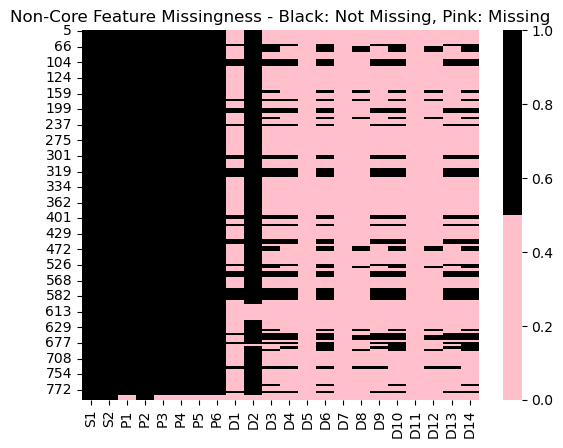

In [18]:
# Inspect columns where supplemental features have NaN values

sns.heatmap(not_nulls_mask, cmap=['Pink', 'Black'])
plt.title("Non-Core Feature Missingness - Black: Not Missing, Pink: Missing")
plt.show()

# There does not seem to be a pattern regarding null values in D columns vs. P or S columns
# Potentially need to import D values from elsewhere. All S columns will be dropped later

### Core Features (H Columns)

In [19]:
# Inspect core feature categories from metadata table
print('Feature Categories')
print(code_dict['Sub_family'].value_counts())
print(f"Number of Household Features: {code_dict['Sub_family'].value_counts().sum()}")

# All core feature categories begin with H and have a secondary letter code shown in the table below

Feature Categories
Household headship (H)          56
Size and age composition (S)    30
Relationship to head (R)        30
Household typology (T)          30
Name: Sub_family, dtype: int64
Number of Household Features: 146


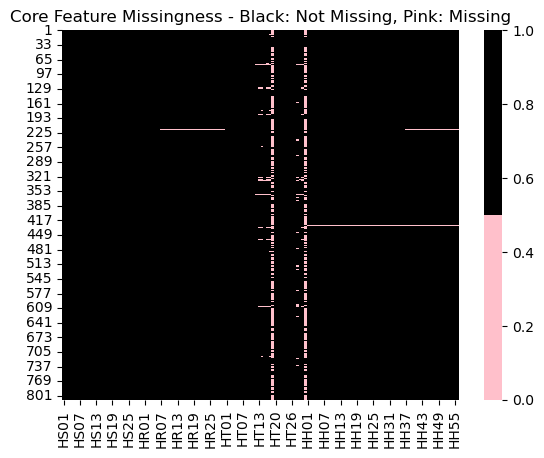

In [20]:
# Inspect where core features have null values

core_features = df.loc[:, df.columns.str.startswith('H')]
core_features_null_mask = core_features.notnull()

sns.heatmap(core_features_null_mask, cmap=['Pink', 'Black'])
plt.title("Core Feature Missingness - Black: Not Missing, Pink: Missing")
plt.show()

# Most null values are in HT18 and HT31. Potentially these are zero values and not null values.

#### 1) Household Headship (HH)

The household headship sub family of features describes household headship in two ways: Proportions and Averages.
- Proportions of households by size and type, bifurcated by male and female 
- Averages of household size and type, bifurcated by male and female

Male/Female-Headed are relative proportion columns, which add up to 1 (null values back filled and forward filled within respective country groups in rows 218, 219, 427, 428)

First column ('HH01') Proportion Male-Headed 
Second column ('HH02') Proportion Female-Headed ('HH01':'HH02' sum to one)

(I) Two main proportion vectors, bifurcated by male/female-headed are as follows:

**Vector a** Size of Household (relative proportions sum to one)
1) One person household (proportion male/female head of household)
2) Two person household ""
3) Three person household ""
4) Four person household ""
5) Five person household ""
6) Six person household ""
7) Seven person household ""
8) Eight person household ""
9) Nine person household ""
10) Ten person household ""
11) 11+ person household ""

- Proportion male headed columns: 'HH03':'HH13' (11 columns).
- Proportion female headed columns: 'HH14':'HH24' (11 columns).

**Vector b** Type of Household
1) Unipersonal (proportion male/female head of household)
2) Nuclear relationships to head
3) Stem-family relationships to head
4) Other family relationships to head
5) Non-family relationships to head
5) Other (residual)

- Proportion male headed columns: 'HH25':'HH30' (5 columns).
- Proportion female headed columns: 'HH31':'HH36' (5 columns).

(II) The averages vector is bifurcated by male-headed or female headed:

**Vector c** Size or Type
1) Average household size (in female/male headed household)
2) Average number of children (in female/male headed household)
2) "" of adults
3) "" spouses
4) "" persons 65+
5) "" childs
6) "" other relatives
7) "" other non-relatives
8) "" male adults
9) "" female adults

Columns are odd/even, male/female respectively, for the above group 'HH37':'HH56' (10 male, 10 female).

Note: In exactly 773 rows, sum-to-one proportion vector columns in fact sum to one. In 36 rows, this sum fails. I inspected the indices for the 36 rows with summation failure, and the indices are not the same for all groups. Based on this pattern, I suspect that there were data merge errors in the original data, where an aggregate of 36 items were not propertly normalized. I corrected this by normalizing the rows where summation fails, such that they add to one.

In [21]:
# Inspect feature categories: Sub Family - Household Headship

with pd.option_context('display.max_colwidth', None):
    display(pd.DataFrame(code_dict.loc[code_dict['Sub_family'].str.contains('headship', na=False),['Description', 'Code']].values))
    
    

0  \
0                                                                                                          Proportion of male-headed households   
1                                                                                                        Proportion of female-headed households   
2                                                                                   Proportion of 1-person households of male-headed households   
3                                                                                  Proportion of 2-persons households of male-headed households   
4                                                                                  Proportion of 3-persons households of male-headed households   
5                                                                                  Proportion of 4-persons households of male-headed households   
6                                                                                  Proportion of 5-persons households of male-headed households   
7                                                                                  Proportion of 6-persons households of male-headed households   
8                                                                                  Proportion of 7-persons households of male-headed households   
9                                                                                  Proportion of 8-persons households of male-headed households   
10                                                                                 Proportion of 9-persons households of male-headed households   
11                                                                                Proportion of 10-persons households of male-headed households   
12                                                                                Proportion of 11+persons households of male-headed households   
13                                                                                Proportion of 1-person households of female-headed households   
14                                                                               Proportion of 2-persons households of female-headed households   
15                                                                               Proportion of 3-persons households of female-headed households   
16                                                                               Proportion of 4-persons households of female-headed households   
17                                                                               Proportion of 5-persons households of female-headed households   
18                                                                               Proportion of 6-persons households of female-headed households   
19                                                                               Proportion of 7-persons households of female-headed households   
20                                                                               Proportion of 8-persons households of female-headed households   
21                                                                               Proportion of 9-persons households of female-headed households   
22                                                                              Proportion of 10-persons households of female-headed households   
23                                                                              Proportion of 11+persons households of female-headed households   
24                                                                               Proportion of unipersonal households of male-headed households   
25                                                        Proportion of households with nuclear relationships to head of male-headed households   
26                                                 Proportion of stem-family households based on relationship to head of male-headed households   
27                        

In [22]:
# Do male/female add up to 1 in all proportion categories?

print(f"Number of rows male/female headship whose sum is 1.0: {np.isclose(df.loc[:,'HH01':'HH02'].sum(axis=1), 1.0).sum()}")


print(f"Number of male-headed 1-11+ person hh whose sum is 1.0: {np.isclose(df.loc[:,'HH03':'HH13'].sum(axis=1), 1.0).sum()}")
print(f"Number of female-headed 1-11+ person hh whose sum is 1.0: {np.isclose(df.loc[:,'HH14':'HH24'].sum(axis=1), 1.0).sum()}")

print(f"Number of male-headed by type hh whose sum is 1.0: {np.isclose(df.loc[:,'HH25':'HH30'].sum(axis=1), 1.0).sum()}")
print(f"Number of female-headed by type hh whose sum is 1.0: {np.isclose(df.loc[:,'HH31':'HH36'].sum(axis=1), 1.0).sum()}")

# I don't think it's a coincidence that proportion categories appear to sum to 1.0 across exact number of rows
# This may be indicative of a previous merge error in the data


Number of rows male/female headship whose sum is 1.0: 773
Number of male-headed 1-11+ person hh whose sum is 1.0: 773
Number of female-headed 1-11+ person hh whose sum is 1.0: 773
Number of male-headed by type hh whose sum is 1.0: 773
Number of female-headed by type hh whose sum is 1.0: 773


In [23]:
# Inspect rows where sum does not add up

print(f"Number of rows male/female headship whose sum is ~1.0: {(~np.isclose(df.loc[:,'HH01':'HH02'].sum(axis=1), 1.0)).sum()}")


print(f"Number of male-headed 1-11+ person hh whose sum is ~1.0: {(~np.isclose(df.loc[:,'HH03':'HH13'].sum(axis=1), 1.0)).sum()}")
print(f"Number of female-headed 1-11+ person hh whose sum is ~1.0: {(~np.isclose(df.loc[:,'HH14':'HH24'].sum(axis=1), 1.0)).sum()}")

print(f"Number of male-headed by type hh whose sume is ~1.0: {(~np.isclose(df.loc[:,'HH25':'HH30'].sum(axis=1), 1.0)).sum()}")
print(f"Number of female-headed by type hh whose sum is ~1.0: {(~np.isclose(df.loc[:,'HH31':'HH36'].sum(axis=1), 1.0)).sum()}")



Number of rows male/female headship whose sum is ~1.0: 36
Number of male-headed 1-11+ person hh whose sum is ~1.0: 36
Number of female-headed 1-11+ person hh whose sum is ~1.0: 36
Number of male-headed by type hh whose sume is ~1.0: 36
Number of female-headed by type hh whose sum is ~1.0: 36


In [24]:
# Inspect index of proportion row groups that have summation failures within household headship groups

print("Male or Female Head of Household - HH01:HH02")
print(f"{df[(~np.isclose(df.loc[:,'HH01':'HH02'].sum(axis=1), 1.0))].index}")

print("Male Head: 1-11+ person household - HH03:HH13")
print(f"{df[(~np.isclose(df.loc[:,'HH03':'HH13'].sum(axis=1), 1.0))].index}")

print("Female Head: 1-11+ person household - HH14:HH24")
print(f"{df[(~np.isclose(df.loc[:,'HH14':'HH24'].sum(axis=1), 1.0))].index}")

print("Male Head by type: uni, nuclear, stem, family, non, other - HH25:HH30")
print(f"{df[(~np.isclose(df.loc[:,'HH25':'HH30'].sum(axis=1), 1.0))].index}")

print("Female Head by type: uni, nuclear, stem, family, non, other - HH31:HH36")
print(f"{df[(~np.isclose(df.loc[:,'HH31':'HH36'].sum(axis=1), 1.0))].index}")

# No consistency across all groups that fail to sum. Male and female groups have same failure indexes

Male or Female Head of Household - HH01:HH02
Int64Index([  5,  12,  59,  71, 138, 156, 187, 206, 275, 298, 316, 317, 350,
            351, 357, 391, 407, 428, 443, 469, 471, 516, 528, 529, 541, 542,
            543, 546, 650, 691, 704, 719, 745, 751, 789, 797],
           dtype='int64')
Male Head: 1-11+ person household - HH03:HH13
Int64Index([ 32,  33,  49,  73, 108, 117, 118, 123, 128, 147, 172, 185, 187,
            202, 220, 226, 260, 277, 298, 313, 314, 352, 363, 365, 383, 388,
            425, 428, 480, 532, 539, 624, 662, 692, 696, 798],
           dtype='int64')
Female Head: 1-11+ person household - HH14:HH24
Int64Index([ 16,  21,  23,  24,  28,  30,  31, 108, 117, 118, 123, 128, 147,
            185, 202, 220, 226, 260, 298, 313, 350, 352, 363, 365, 388, 428,
            480, 519, 532, 539, 558, 624, 696, 746, 798, 801],
           dtype='int64')
Male Head by type: uni, nuclear, stem, family, non, other - HH25:HH30
Int64Index([ 32,  33,  49,  73, 108, 117, 118, 123, 128, 147, 

In [25]:
# Check for null values in HH group

df[df.loc[:,df.columns.str.startswith('HH')].isnull().any(axis=1)]



C0   C1           C2      C3               C4    T1    T2  T3    T5  \
218  ES  ESP        Spain  EUROPE  Southern Europe  2010  2010   0  2006   
219  ES  ESP        Spain  EUROPE  Southern Europe  2015  2010   0  2011   
427  KR  KOR  South Korea    ASIA     Eastern Asia  1975  1970   0  1971   
428  KR  KOR  South Korea    ASIA     Eastern Asia  1980  1980   0  1976   

      T10  ...     D5           D6        D7         D8       D9          D10  \
218  2000  ...  0.980  37173.68190  0.857565  16.746531  9.12660  28285.62443   
219  2010  ...  0.981  37383.58643  0.879667  17.780121  9.77008  29466.57168   
427  1970  ...    NaN          NaN       NaN        NaN      NaN          NaN   
428  1970  ...    NaN          NaN       NaN        NaN      NaN          NaN   

          D11        D12       D13          D14  
218  0.874665  15.934190   9.61129  46273.56322  
219  0.896751  17.179159  10.06324  45581.24946  
427       NaN        NaN       NaN          NaN  
428       NaN        NaN       NaN          NaN  

[4 rows x 178 columns]

In [26]:
# Inspect surrounding columns to determine if backfill frontfill will work

pd.concat([df.loc[217:220,df.columns.str.startswith(('HH','C','T'))], df.loc[426:429,df.columns.str.startswith(('HH','C','T'))]])


# Surrounding values are populated. Good to frontfill and backfill. 
# Other null values in d columns are fine to ffill and backfill as well

C0   C1           C2      C3               C4    T1    T2  T3    T5  \
217  ES  ESP        Spain  EUROPE  Southern Europe  2005  2000   0  2001   
218  ES  ESP        Spain  EUROPE  Southern Europe  2010  2010   0  2006   
219  ES  ESP        Spain  EUROPE  Southern Europe  2015  2010   0  2011   
220  ES  ESP        Spain  EUROPE  Southern Europe  2021  2020   1  2021   
426  KR  KOR  South Korea    ASIA     Eastern Asia  1970  1970   0  1966   
427  KR  KOR  South Korea    ASIA     Eastern Asia  1975  1970   0  1971   
428  KR  KOR  South Korea    ASIA     Eastern Asia  1980  1980   0  1976   
429  KR  KOR  South Korea    ASIA     Eastern Asia  1985  1980   0  1981   

      T10  ...      HH47      HH48      HH49      HH50      HH51      HH52  \
217  2000  ...  0.986817  0.740554  0.152802  0.191842  0.026344  0.028865   
218  2000  ...       NaN       NaN       NaN       NaN       NaN       NaN   
219  2010  ...       NaN       NaN       NaN       NaN       NaN       NaN   
220  2020  ...  0.670334  0.684711  0.173197  0.162967  0.032843  0.018399   
426  1960  ...  3.035974  2.272008  0.441491  0.357978  0.163010  0.213377   
427  1970  ...  2.792896  1.820398  0.412999  0.263917  0.097577  0.116315   
428  1970  ...       NaN       NaN       NaN       NaN       NaN       NaN   
429  1980  ...  1.981509  1.204044  0.369165  0.367252  0.073454  0.153066   

         HH53      HH54      HH55      HH56  
217  1.298277  0.660922  1.055987  1.256585  
218       NaN       NaN       NaN       NaN  
219       NaN       NaN       NaN       NaN  
220  1.224752  0.703103  0.886900  1.233258  
426  1.371856  0.394773  1.416338  1.503439  
427       NaN       NaN       NaN       NaN  
428       NaN       NaN       NaN       NaN  
429  1.366772  0.422406  1.314438  1.443553  

[8 rows x 66 columns]

In [27]:
# ffill and bfill missing values in hh

df.loc[217:429,:] = df.loc[217:429,:].ffill().bfill()

In [28]:
# Check for null values again after backfilling and forward filling


df.loc[:, df.columns.str.startswith('H')].isnull().sum().sort_values(ascending=False).head(12)

HT31    394
HT18    394
HT17     26
HT28     25
HT14     22
HT16     20
HT13     19
HT30     17
HT29      4
HT15      3
HT12      2
HH51      0
dtype: int64

In [29]:
# Inspect columns where proportion figures do not add up to 1
# Potential to normalize these columns

normalize_groups = [df[(~np.isclose(df.loc[:,'HH01':'HH02'].sum(axis=1),1.0))], 
                    df[(~np.isclose(df.loc[:,'HH03':'HH13'].sum(axis=1),1.0))], 
                    df[(~np.isclose(df.loc[:,'HH14':'HH24'].sum(axis=1),1.0))], 
                    df[(~np.isclose(df.loc[:,'HH25':'HH30'].sum(axis=1),1.0))], 
                    df[(~np.isclose(df.loc[:,'HH31':'HH36'].sum(axis=1),1.0))]
                   ]

target_cols_index = set()
for group in normalize_groups:
    for x in group.index:
        target_cols_index.add(x)

In [30]:
# Normalize values in each group

normalize_groups = [df.loc[:,'HH01':'HH02'], 
                    df.loc[:,'HH03':'HH13'], 
                    df.loc[:,'HH14':'HH24'], 
                    df.loc[:,'HH25':'HH30'], 
                    df.loc[:,'HH31':'HH36']
                   ]

for row in target_cols_index:
    for group in normalize_groups:
        columns = group.columns
        denominator = df.loc[row, columns].sum()
        df.loc[row, columns] = df.loc[row, columns].apply(lambda x: x/denominator)

In [31]:
# Verify that normalization worked by printing any rows that fail to add up to 1

print("Male or Female Head of Household:")
print(f"{df[(~np.isclose(df.loc[:,'HH01':'HH02'].sum(axis=1), 1.0))].index}")

print("Male Head: 1-11+ person household")
print(f"{df[(~np.isclose(df.loc[:,'HH03':'HH13'].sum(axis=1), 1.0))].index}")

print("Female Head: 1-11+ person household")
print(f"{df[(~np.isclose(df.loc[:,'HH14':'HH24'].sum(axis=1), 1.0))].index}")

print("Male Head by type: uni, nuclear, stem, family, non, other")
print(f"{df[(~np.isclose(df.loc[:,'HH25':'HH30'].sum(axis=1), 1.0))].index}")

print("Female Head by type: uni, nuclear, stem, family, non, other")
print(f"{df[(~np.isclose(df.loc[:,'HH31':'HH36'].sum(axis=1), 1.0))].index}")



Male or Female Head of Household:
Int64Index([], dtype='int64')
Male Head: 1-11+ person household
Int64Index([], dtype='int64')
Female Head: 1-11+ person household
Int64Index([], dtype='int64')
Male Head by type: uni, nuclear, stem, family, non, other
Int64Index([], dtype='int64')
Female Head by type: uni, nuclear, stem, family, non, other
Int64Index([], dtype='int64')


In [32]:
# Double verify that normalization worked


print(f"Number of rows male/female headship whose sum is 1.0 (HH01:HH02): {np.isclose(df.loc[:,'HH01':'HH02'].sum(axis=1), 1.0).sum()}")


print(f"Number of male-headed 1-11+ person hh whose sum is 1.0 (HH03:HH13): {np.isclose(df.loc[:,'HH03':'HH13'].sum(axis=1), 1.0).sum()}")
print(f"Number of female-headed 1-11+ person hh whose sum is 1.0 (HH14:HH24): {np.isclose(df.loc[:,'HH14':'HH24'].sum(axis=1), 1.0).sum()}")

print(f"Number of male-headed by type hh whose sume is 1.0 (HH25:HH30): {np.isclose(df.loc[:,'HH25':'HH30'].sum(axis=1), 1.0).sum()}")
print(f"Number of female-headed by type hh whose sum is 1.0 (HH31:HH36): {np.isclose(df.loc[:,'HH31':'HH36'].sum(axis=1), 1.0).sum()}")

# All proportion group 809 rows now add up to 1

Number of rows male/female headship whose sum is 1.0 (HH01:HH02): 809
Number of male-headed 1-11+ person hh whose sum is 1.0 (HH03:HH13): 809
Number of female-headed 1-11+ person hh whose sum is 1.0 (HH14:HH24): 809
Number of male-headed by type hh whose sume is 1.0 (HH25:HH30): 809
Number of female-headed by type hh whose sum is 1.0 (HH31:HH36): 809


In [33]:
# Check for null values in HH groups


df.loc[:,df.columns.str.startswith('HH')].isnull().any(axis=1).any()

# No null values remaining in HH sub family

False

#### 2) Size and age composition (HS)

The size and age composition sub family is split into three groups of proportions, and averages

Proportion Groups:

(I) The first 11 columns ('HS01':'HS11') are relative proportions and add up to 1

1) Proportion of 1 person households
2) "" 2 person ""
3) "" 3 person ""
4) "" 4 person ""
5) "" 5 person ""
6) "" 6 person ""
7) "" 7 person ""
8) "" 8 person ""
9) "" 9 person ""
10) "" 10 person ""
11) "" 11+ person ""

(II) The next three columns are relative proportions ('HS12':'HS14') add up to 1 when 'HS01' (1-person households) is included

1) Proportion of 2-3 person households
2) "" 4-5 person ""
3) "" 6+ person ""

(III) The last two proportion columns ('HS15','HS16') do not add up to 1, and there are no other columns that complete the sum. Thus, I make the assumption that these are absolute proportions, to be understood as Y/N with the stated value representing Y.

Average Groups (HS17:HS30):

1) 'Average household size'
2) 'Average number of 0-4 children in the household'
3) 'Average number of adults in the household (aged 18+)'
4) 'Average number of children in the household (aged < 18)'
5) 'Average number of persons aged 65+ in the household'
6) 'Average number of 0-9 individuals in the household'
7) 'Average number of 10-19 individuals in the household'
8) 'Average number of 20-29 individuals in the household'
9) 'Average number of 30-39 individuals in the household'
10) 'Average number of 40-49 individuals in the household'
11) 'Average number of 50-59 individuals in the household'
12) 'Average number of 60-69 individuals in the household'
13) 'Average number of 70-79 individuals in the household'
14) 'Average number of 80+ individuals in the household'



In [34]:
# Size and age composition

with pd.option_context('display.max_colwidth', None):
    display(code_dict.loc[code_dict['Code'].str.startswith('HS'), ['Code','Description']])


Code                                                      Description
0   HS01                                Proportion of 1-person households
1   HS02                               Proportion of 2-persons households
2   HS03                               Proportion of 3-persons households
3   HS04                               Proportion of 4-persons households
4   HS05                               Proportion of 5-persons households
5   HS06                               Proportion of 6-persons households
6   HS07                               Proportion of 7-persons households
7   HS08                               Proportion of 8-persons households
8   HS09                               Proportion of 9-persons households
9   HS10                              Proportion of 10-persons households
10  HS11                              Proportion of 11+persons households
11  HS12                             Proportion of 2-3 persons households
12  HS13                             Proportion of 4-5 persons households
13  HS14                              Proportion of 6+ persons households
14  HS15  Proportion of households with at least one person 0-4 years old
15  HS16  Proportion of households with at least one person 65+ years old
16  HS17                                           Average household size
17  HS18                  Average number of 0-4 children in the household
18  HS19             Average number of adults in the household (aged 18+)
19  HS20          Average number of children in the household (aged < 18)
20  HS21              Average number of persons aged 65+ in the household
21  HS22               Average number of 0-9 individuals in the household
22  HS23             Average number of 10-19 individuals in the household
23  HS24             Average number of 20-29 individuals in the household
24  HS25             Average number of 30-39 individuals in the household
25  HS26             Average number of 40-49 individuals in the household
26  HS27             Average number of 50-59 individuals in the household
27  HS28             Average number of 60-69 individuals in the household
28  HS29             Average number of 70-79 individuals in the household
29  HS30               Average number of 80+ individuals in the household

In [35]:
# Proportion of #-person households summation
# Columns HS01-HS11 add up to 1

np.isclose(df.loc[:,'HS01':'HS11'].sum(axis=1), 1.0).all()

True

In [36]:
# Proportion of #-# person households summation

df.loc[:,'HS12':'HS14'].sum(axis=1).sort_values()


183    0.595094
390    0.605828
462    0.607974
182    0.610392
185    0.619704
         ...   
571    0.990161
572    0.991192
195    0.993345
1      0.998565
426    0.998751
Length: 809, dtype: float64

In [37]:
# Search for stray column that adds up to 1

for col in df.select_dtypes(exclude=['object']):
    remainder_fix = df.loc[:, 'HS12':'HS14'].sum(axis=1) + df[col]
    if np.isclose(remainder_fix, 1.0).all():
        print(f'Fix column found: {col}')
    
# HT01 is the same value in Household Typology sub family

Fix column found: HS01
Fix column found: HT01
Fix column found: HT20


In [38]:
# Inspect these fix columns. It makes some sense why HS01 == HT01
code_dict.loc[(code_dict['Code'] == 'HS01') | (code_dict['Code'] == 'HT01') | (code_dict['Code'] == 'HT20'),'Description']

0        Proportion of 1-person households
60    Proportion of unipersonal households
78    Proportion of unipersonal households
Name: Description, dtype: object

In [39]:
# Proportion of households with at least one person 0-4 (HS15), at least one person 65+ (HS16)

df.loc[:, 'HS15':'HS16'].sum(axis=1)

1      0.880057
2      0.734931
3      0.523940
4      0.552676
5      0.480692
         ...   
805    0.621919
806    0.649612
807    0.644526
808    0.620795
809    0.637744
Length: 809, dtype: float64

In [40]:
# Search for a stray column that may be needed to complete

for col in df.select_dtypes(exclude=['object']).columns:
    test_sum = (df.loc[:,'HS15':'HS16'].sum(axis=1) + df[col])
    if (np.isclose(test_sum, 1.0)).all():
        print(f"Stray column found: {col}")
    
# No other column adds up to 1 with HS15 and HS16
# Assumption: these are raw proportions and not meant to add up to 1

In [41]:
# search for a combination of columns that may be needed to complete the sum

iter_cols = df.loc[:,df.columns.str.startswith('HS')]#.select_dtypes(exclude=['object']).columns

for num_iters in range(1, 6):
    found = False
    for col_combos in itertools.combinations(iter_cols, num_iters):
        test_sum = df.loc[:,'HS15':'HS16'].sum(axis=1) + df[list(col_combos)].sum(axis=1)
        if np.isclose(test_sum, 1.0).all():
            print(f"Remainder col found: {col_combos}")
            found = True
            break
    else: 
        if not found:
            print("Remainder column/s that sum to one with HS15:HS16 not found")

# No combinations found that will complete sum for Household Size proportion stragglers

Remainder column/s that sum to one with HS15:HS16 not found
Remainder column/s that sum to one with HS15:HS16 not found
Remainder column/s that sum to one with HS15:HS16 not found
Remainder column/s that sum to one with HS15:HS16 not found
Remainder column/s that sum to one with HS15:HS16 not found


In [42]:
# Check for null values before concluding section

df.loc[:, df.columns.str.startswith('HS')].isnull().any().any()

# No null values in household size category

False

#### 3) Household Typology (HT)

The household typology sub family of features consists of two groupings: Proportions and Averages. 
1) Proportion grouping describes the type of household by relationship to head
2) Average size of household by relationship to head

There here are two proportion groupings in the typology subfamily. One is more extensive, while the other contains consolidated categories. I assume that the categories are consolidated, because some of the columns across the two groupings are duplicates. Thus, I conclude that the difference between the groupings is one of consolidation.

Diversified proportion grouping in this sub family is relative. Columns add to one. It consists of the following:
1) Proportion unipersonal households
2) Proportion households with nuclear relationships to head
3) "" nuclear and other family ""
4) "" nuclear and non family ""
5) "" nuclear, other family, and non family ""
6) "" non nuclear family ""
7) "" non family ""
8) "" non nuclear family and non family ""
9) "" non nuclear family and/or non family ""

Proportion columns ('HT01':'HT09') add to one.


These do not add to one: Average size of household columns, by diversified typology groups above: ('HT10':'HT18')


Simplified proportion grouping:
1) Proportion of unipersonal households
1) Proportion of households with nuclear relationships to head
2) Proportion of stem-family households based on relationship to head
3) Proportion of other family households based on relationship to head
4) Proportion non family households based on relationship to head
5) Proportion of other relative and / or non relative households based on relationship to head (residual category)

Proportion columns add to one ('HT20':'HT25')

Note on null values:
HT18 and HT31 contain 394 missing values each. The two columns HT18 and HT31 are residual categories for atypical households, and null values are assumed to be zero due to residual nature. All other null values are sporadic (26 null values or less), and are found in the "averages" columns. Thus, these values are assumed to be zero as well. Therefore, all null values in HT category were replaced with zero (0).

In [43]:
# Inspect Household Typology columns
with pd.option_context('display.max_colwidth', None):
    display(pd.DataFrame(code_dict[code_dict['Sub_family'].str.contains('typology', na=False)].values))


0     1  \
0   Household typology (T)  HT01   
1   Household typology (T)  HT02   
2   Household typology (T)  HT03   
3   Household typology (T)  HT04   
4   Household typology (T)  HT05   
5   Household typology (T)  HT06   
6   Household typology (T)  HT07   
7   Household typology (T)  HT08   
8   Household typology (T)  HT09   
9   Household typology (T)  HT10   
10  Household typology (T)  HT11   
11  Household typology (T)  HT12   
12  Household typology (T)  HT13   
13  Household typology (T)  HT14   
14  Household typology (T)  HT15   
15  Household typology (T)  HT16   
16  Household typology (T)  HT17   
17  Household typology (T)  HT18   
18  Household typology (T)  HT20   
19  Household typology (T)  HT21   
20  Household typology (T)  HT22   
21  Household typology (T)  HT23   
22  Household typology (T)  HT24   
23  Household typology (T)  HT25   
24  Household typology (T)  HT26   
25  Household typology (T)  HT27   
26  Household typology (T)  HT28   
27  Household typology (T)  HT29   
28  Household typology (T)  HT30   
29  Household typology (T)  HT31   

                                                                                                                  2  
0                                                                              Proportion of unipersonal households  
1                                                       Proportion of households with nuclear relationships to head  
2                                      Proportion of households with nuclear and other family relationships to head  
3                                        Proportion of households with nuclear and non family relationships to head  
4                         Proportion of households with nuclear, other family, and non family relationships to head  
5                                            Proportion of households with non nuclear family relationships to head  
6                                                    Proportion of households with non family relationships to head  
7                             Proportion of households with non nuclear family and non family relationships to head  
8                        Proportion of households with non nuclear family and / or non family relationships to head  
9                                                                            Average size of unipersonal households  
10                                                    Average size of households with nuclear relationships to head  
11                                     Average size of households with nucelar and other family relionships to head  
12                                     Average size of households with nuclear and non family relationships to head  
13                      Average size of households with nuclear, other family, and non family relationships to head  
14                                         Average size of households with non nuclear family relationships to head  
15                                                 Average size of households with non family relationships to head  
16                          Average size of households with non nuclear family and non family relationships to head  
17                     Average size of households with non nuclear family and / or non family relationships to head  
18                                                                             Proportion of unipersonal households  
19                                                      Proportion of households with nuclear relationships to head  
20                                               Proportion of stem-family households based on relationship to head  
21                                              Proportion of other family households based on relationship to head  
22                                                   Proportion non family households based on relationship to head  
23  Proportion of other relative and / or non relative households based on r

In [44]:
# Household Typology - Proportion category checks. Ensure all proportions add up to 1.0

assert np.isclose(df.loc[:,'HT01': 'HT09'].sum(axis=1), 1).all(), 'Typology proportions do not add up to 1'
assert np.isclose(df.loc[:,'HT20':'HT25'].sum(axis=1), 1).all(), 'Typology proportions do not add up to 1'

In [45]:
# Check for duplicate columns

dupe_cols = df.T[df.T.duplicated(keep=False)].index
print(dupe_cols)

dupe_pairs = []

for i, col1 in enumerate(dupe_cols):
    for col2 in dupe_cols[i+1:]:
        if df[col1].equals(df[col2]):
            dupe_pairs.append((col1, col2))
            

Index(['HR01', 'HT01', 'HT02', 'HT09', 'HT10', 'HT11', 'HT18', 'HT20', 'HT21',
       'HT25', 'HT26', 'HT27', 'HT31'],
      dtype='object')


In [46]:
dupe_pairs = pd.DataFrame(dupe_pairs, columns=['set1', 'set2'])
dupe_pairs


set1  set2
0  HR01  HT10
1  HR01  HT26
2  HT01  HT20
3  HT02  HT21
4  HT09  HT25
5  HT10  HT26
6  HT11  HT27
7  HT18  HT31

In [47]:
# Lookup descriptions corresponding to duplicate columns

dupe_pairs['set1_des'] = dupe_pairs.merge(code_dict, left_on='set1', right_on='Code', how='left')['Description']
dupe_pairs['set2_des'] = dupe_pairs.merge(code_dict, left_on='set2', right_on='Code', how='left')['Description']

with pd.option_context('display.max_colwidth', None):
    display(dupe_pairs)
    
# Duplicates are just similar columns. They are not true duplicates.

set1  set2  \
0  HR01  HT10   
1  HR01  HT26   
2  HT01  HT20   
3  HT02  HT21   
4  HT09  HT25   
5  HT10  HT26   
6  HT11  HT27   
7  HT18  HT31   

                                                                                       set1_des  \
0                                                      Average number of heads in the household   
1                                                      Average number of heads in the household   
2                                                          Proportion of unipersonal households   
3                                   Proportion of households with nuclear relationships to head   
4    Proportion of households with non nuclear family and / or non family relationships to head   
5                                                        Average size of unipersonal households   
6                                 Average size of households with nuclear relationships to head   
7  Average size of households with non nuclear family and / or non family relationships to head   

                                                                                                          set2_des  
0                                                                           Average size of unipersonal households  
1                                             Average size of unipersonal households based on relationship to head  
2                                                                             Proportion of unipersonal households  
3                                                      Proportion of households with nuclear relationships to head  
4  Proportion of other relative and / or non relative households based on relationship to head (residual category)  
5                                             Average size of unipersonal households based on relationship to head  
6                                                 Average size of nuclear households based on relationship to head  
7  Average size of other relative and/or non relative households based on relationship to head (residual category)

In [48]:
# HT01 to HT09:  Proportion groups add to one
np.isclose(df.loc[:,'HT01':'HT09'].sum(axis=1), 1.0).all()

True

In [49]:
# Check that proportion groupings add to one

df.loc[:, 'HT20':'HT25'].sum(axis=1).all()

# Proportion groupings add to one respectively. HT01 and HT20 are not duplicates. Each is necessary in its own grouping.

True

In [50]:
# Check null values again

df.loc[:, df.columns.str.startswith('HT')].isnull().sum().sort_values(ascending=False).head(10)

# Categories after HT10 are averages, not proportions. Assume all null values to be zero.

HT31    394
HT18    394
HT17     26
HT28     25
HT14     22
HT16     20
HT13     19
HT30     17
HT29      4
HT15      3
dtype: int64

In [51]:
# Replace null Household Typology (HT) columns with zeros

df.loc[:, df.columns.str.startswith('HT')] = df.loc[:, df.columns.str.startswith('HT')].fillna(0)

In [52]:
# Check that null values are filled

df.loc[:, df.columns.str.startswith('HT')].isnull().any().any()

False

#### 4) Relationship to head (HR)

The features in sub family "Relationship to Head" are expressed in raw averages. There are no proportion categories as there are in the other three sub families. 

The data consists of 30 features, which represent a cross-tabulation of the following two vectors, expressed as an average:

**Vector a** Number of heads or members by relationship to head:
1) Heads in Household (average number of heads in household of b size)
2) Spouses of head (average number of spouses in household of b size)
3) Children of head ""
4) Other relatives of head ""
5) Non-relatives of head ""
6) Other (residual category) ""

**Vector b** Number of :
1) Household (*unspecified size*)
2) 2-person household
3) 3-person household
4) 4-person household
5) 5-person household

Therefore, a total of 30 (6 groups by 5 crosstabs) columns: 'HR01' through 'HR30'. Five groups are 
1) HR01:HR06
2) HR07:HR12
3) HR13:HR18
4) HR19:HR24
5) HR25:HR30

Assumptions about the data in this sub-family include the following:

- 'HR01':'HR06' are not labeled as "1-person" or "unipersonal", although that would be my initial assumption based on the sequence of household sizes. I assume this category is intended to describe the relationship of household inhabitants to heads of households, of unspecified size.
- If the household were "unipersonal" the remaining cross-tabulations would all be be populated with 1.0 or 0.0-values, because the household by definition only contains one person (and zero others). I explored whether the unspecified household size was an average of the other size categories, but the numbers clearly did not add up to a mean. Thus, I conclude that the household size is merely unspecified in the first group of six.
- There may be good reasons for data to be available about a household, where its exact size is unspecified. Chief among these reasons would be reluctance of survey participants to give exact numbers. Another reason would be fluctuations in the household size. This is not explained by the authors of the study.

In [53]:
# No proportion categories in "Relationship to head," all averages

with pd.option_context('display.max_colwidth', None):
    display(pd.DataFrame(code_dict.loc[code_dict['Code'].str.startswith('HR'), ['Description', 'Code']].values))

0  \
0                                              Average number of heads in the household   
1                                Average number of spouses of the head in the household   
2                               Average number of children of the head in the household   
3                        Average number of other relatives of the head in the household   
4                          Average number of non relatives of the head in the household   
5   Average number of other relatives and/or non relatives of the head in the household   
6                                        Average number of Heads in 2 persons household   
7                                      Average number of Spouses in 2 persons household   
8                                     Average number of Children in 2 persons household   
9                              Average number of Other relatives in 2 persons household   
10                               Average number of Non relatives in 2 persons household   
11             Average number of Other relative or Non relatives in 2 persons household   
12                                       Average number of Heads in 3 persons household   
13                                     Average number of Spouses in 3 persons household   
14                                    Average number of Children in 3 persons household   
15                             Average number of Other relatives in 3 persons household   
16                               Average number of Non relatives in 3 persons household   
17           Average number of Other relatives or Non relatives in  3 persons household   
18                                       Average number of Heads in 4 persons household   
19                                     Average number of Spouses in 4 persons household   
20                                    Average number of Children in 4 persons household   
21                             Average number of Other relatives in 4 persons household   
22                               Average number of Non relatives in 4 persons household   
23            Average number of Other Relatives or Non relatives in 4 persons household   
24                                       Average number of Heads in 5 persons household   
25                                     Average number of Spouses in 5 persons household   
26                                    Average number of Children in 5 persons household   
27                             Average number of Other relatives in 5 persons household   
28                               Average number of Non relatives in 5 persons household   
29            Average number of Other relatives or Non relatives in 5 persons household   

       1  
0   HR01  
1   HR02  
2   HR03  
3   HR04  
4   HR05  
5   HR06  
6   HR07  
7   HR08  
8   HR09  
9   HR10  
10  HR11  
11  HR12  
12  HR13  
13  HR14  
14  HR15  
15  HR16  
16  HR17  
17  HR18  
18  HR19  
19  HR20  
20  HR21  
21  HR22  
22  HR23  
23  HR24  
24  HR25  
25  HR26  
26  HR27  
27  HR28  
28  HR29  
29  HR30

In [54]:
# Check for null values

df.loc[:,df.columns.str.startswith('HR')].isnull().any().any()

# No null values

False

[0] max is 5.258203387957618
[1] max is 0.5732398728617071
[2] max is 1.7244520260960328
[3] max is 2.772968706392554
[4] max is 3.8122783307194004


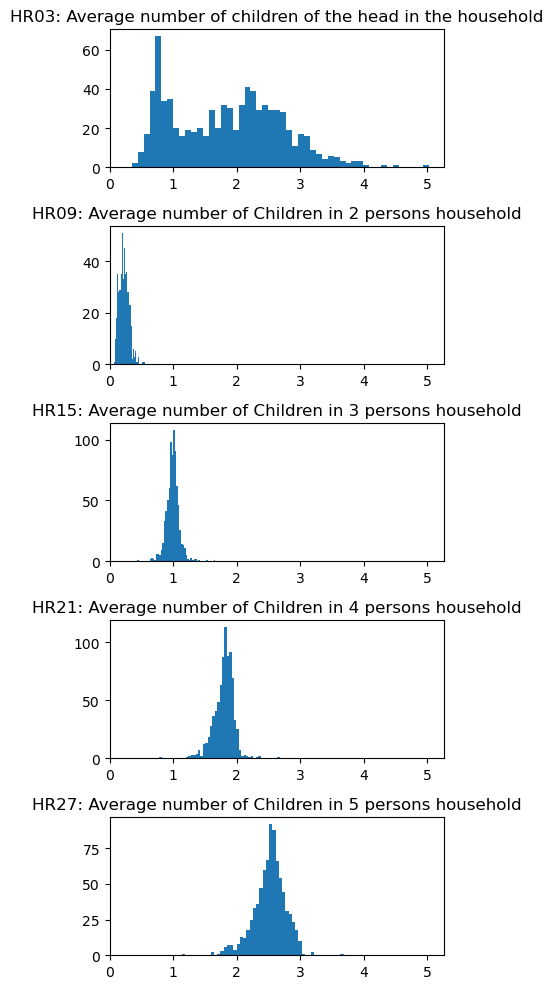

In [55]:
# Average number of children of the head in household of varying size
# Examine category to determine what size "unspecified" HR03 might be

fig, ax = plt.subplots(5, 1, figsize=(4,10))

for i in range(5):
        col_index = 3 + (i * 6)
        col_name = f'HR{col_index:02d}'
        ax[i].hist(df[col_name], bins=50)
        ax[i].set_title(f"{col_name}: {code_dict.loc[code_dict['Code']==col_name, 'Description'].values[0]}")

x_maxes = []

for i in range(5):
        x_maxes.append(ax[i].get_xlim()[1])
        print(f'{[i]} max is {ax[i].get_xlim()[1]}')

x_max = max(x_maxes)

for i in range(5):
        ax[i].set_xlim(0, x_max)

plt.tight_layout()

plt.show()

In [56]:
# Average number of other relatives in household of varying size

fig, ax = plt.subplots(5, 1, figsize=(5,10))

for i in range(5):
        col_index = 4 + (i * 6)
        col_name = f'HR{col_index:02d}'
        ax[i].hist(df[col_name], bins=50)
        ax[i].set_title(f"{col_name}: {code_dict.loc[code_dict['Code']==col_name, 'Description'].values[0]}")

x_maxes = []

for i in range(5):
        x_maxes.append(ax[i].get_xlim()[1])
        #print(f'{[i]} max is {ax[i].get_xlim()[1]}')

x_max = max(x_maxes)

for i in range(5):
        ax[i].set_xlim(0, x_max)

plt.tight_layout()

#plt.show()
plt.clf()

<Figure size 500x1000 with 0 Axes>

In [57]:
# Is the first set of averages (unspecified household size) an average of the other 4 sets?

for i in range(6):
    mean_list = []
    
    target_col_index = 1 + i
    target_column_name = f"HR{target_col_index:02d}"
    print(f"Target column: {target_column_name} is a mean of the following columns?")
    
    for j in range(4):
        mean_col_index = 7+i + 6*j
        mean_cols_names = f"HR{mean_col_index:02d}"
        mean_list.append(df[mean_cols_names])
        print(mean_cols_names)
    mean_df = pd.concat(mean_list, axis=1)
    #print(mean_df)
    
        
    mean = mean_df.mean(axis=1)
    target_col = df[target_column_name]
    #print(means_target_df)
    if np.isclose(target_col, mean).all():
        print(f'{target_column_name} is the mean of {mean_cols_names}')
    else:
        print('No cigar!')

# No. Unclear that it could plausibly represent 1-person households

Target column: HR01 is a mean of the following columns?
HR07
HR13
HR19
HR25
No cigar!
Target column: HR02 is a mean of the following columns?
HR08
HR14
HR20
HR26
No cigar!
Target column: HR03 is a mean of the following columns?
HR09
HR15
HR21
HR27
No cigar!
Target column: HR04 is a mean of the following columns?
HR10
HR16
HR22
HR28
No cigar!
Target column: HR05 is a mean of the following columns?
HR11
HR17
HR23
HR29
No cigar!
Target column: HR06 is a mean of the following columns?
HR12
HR18
HR24
HR30
No cigar!


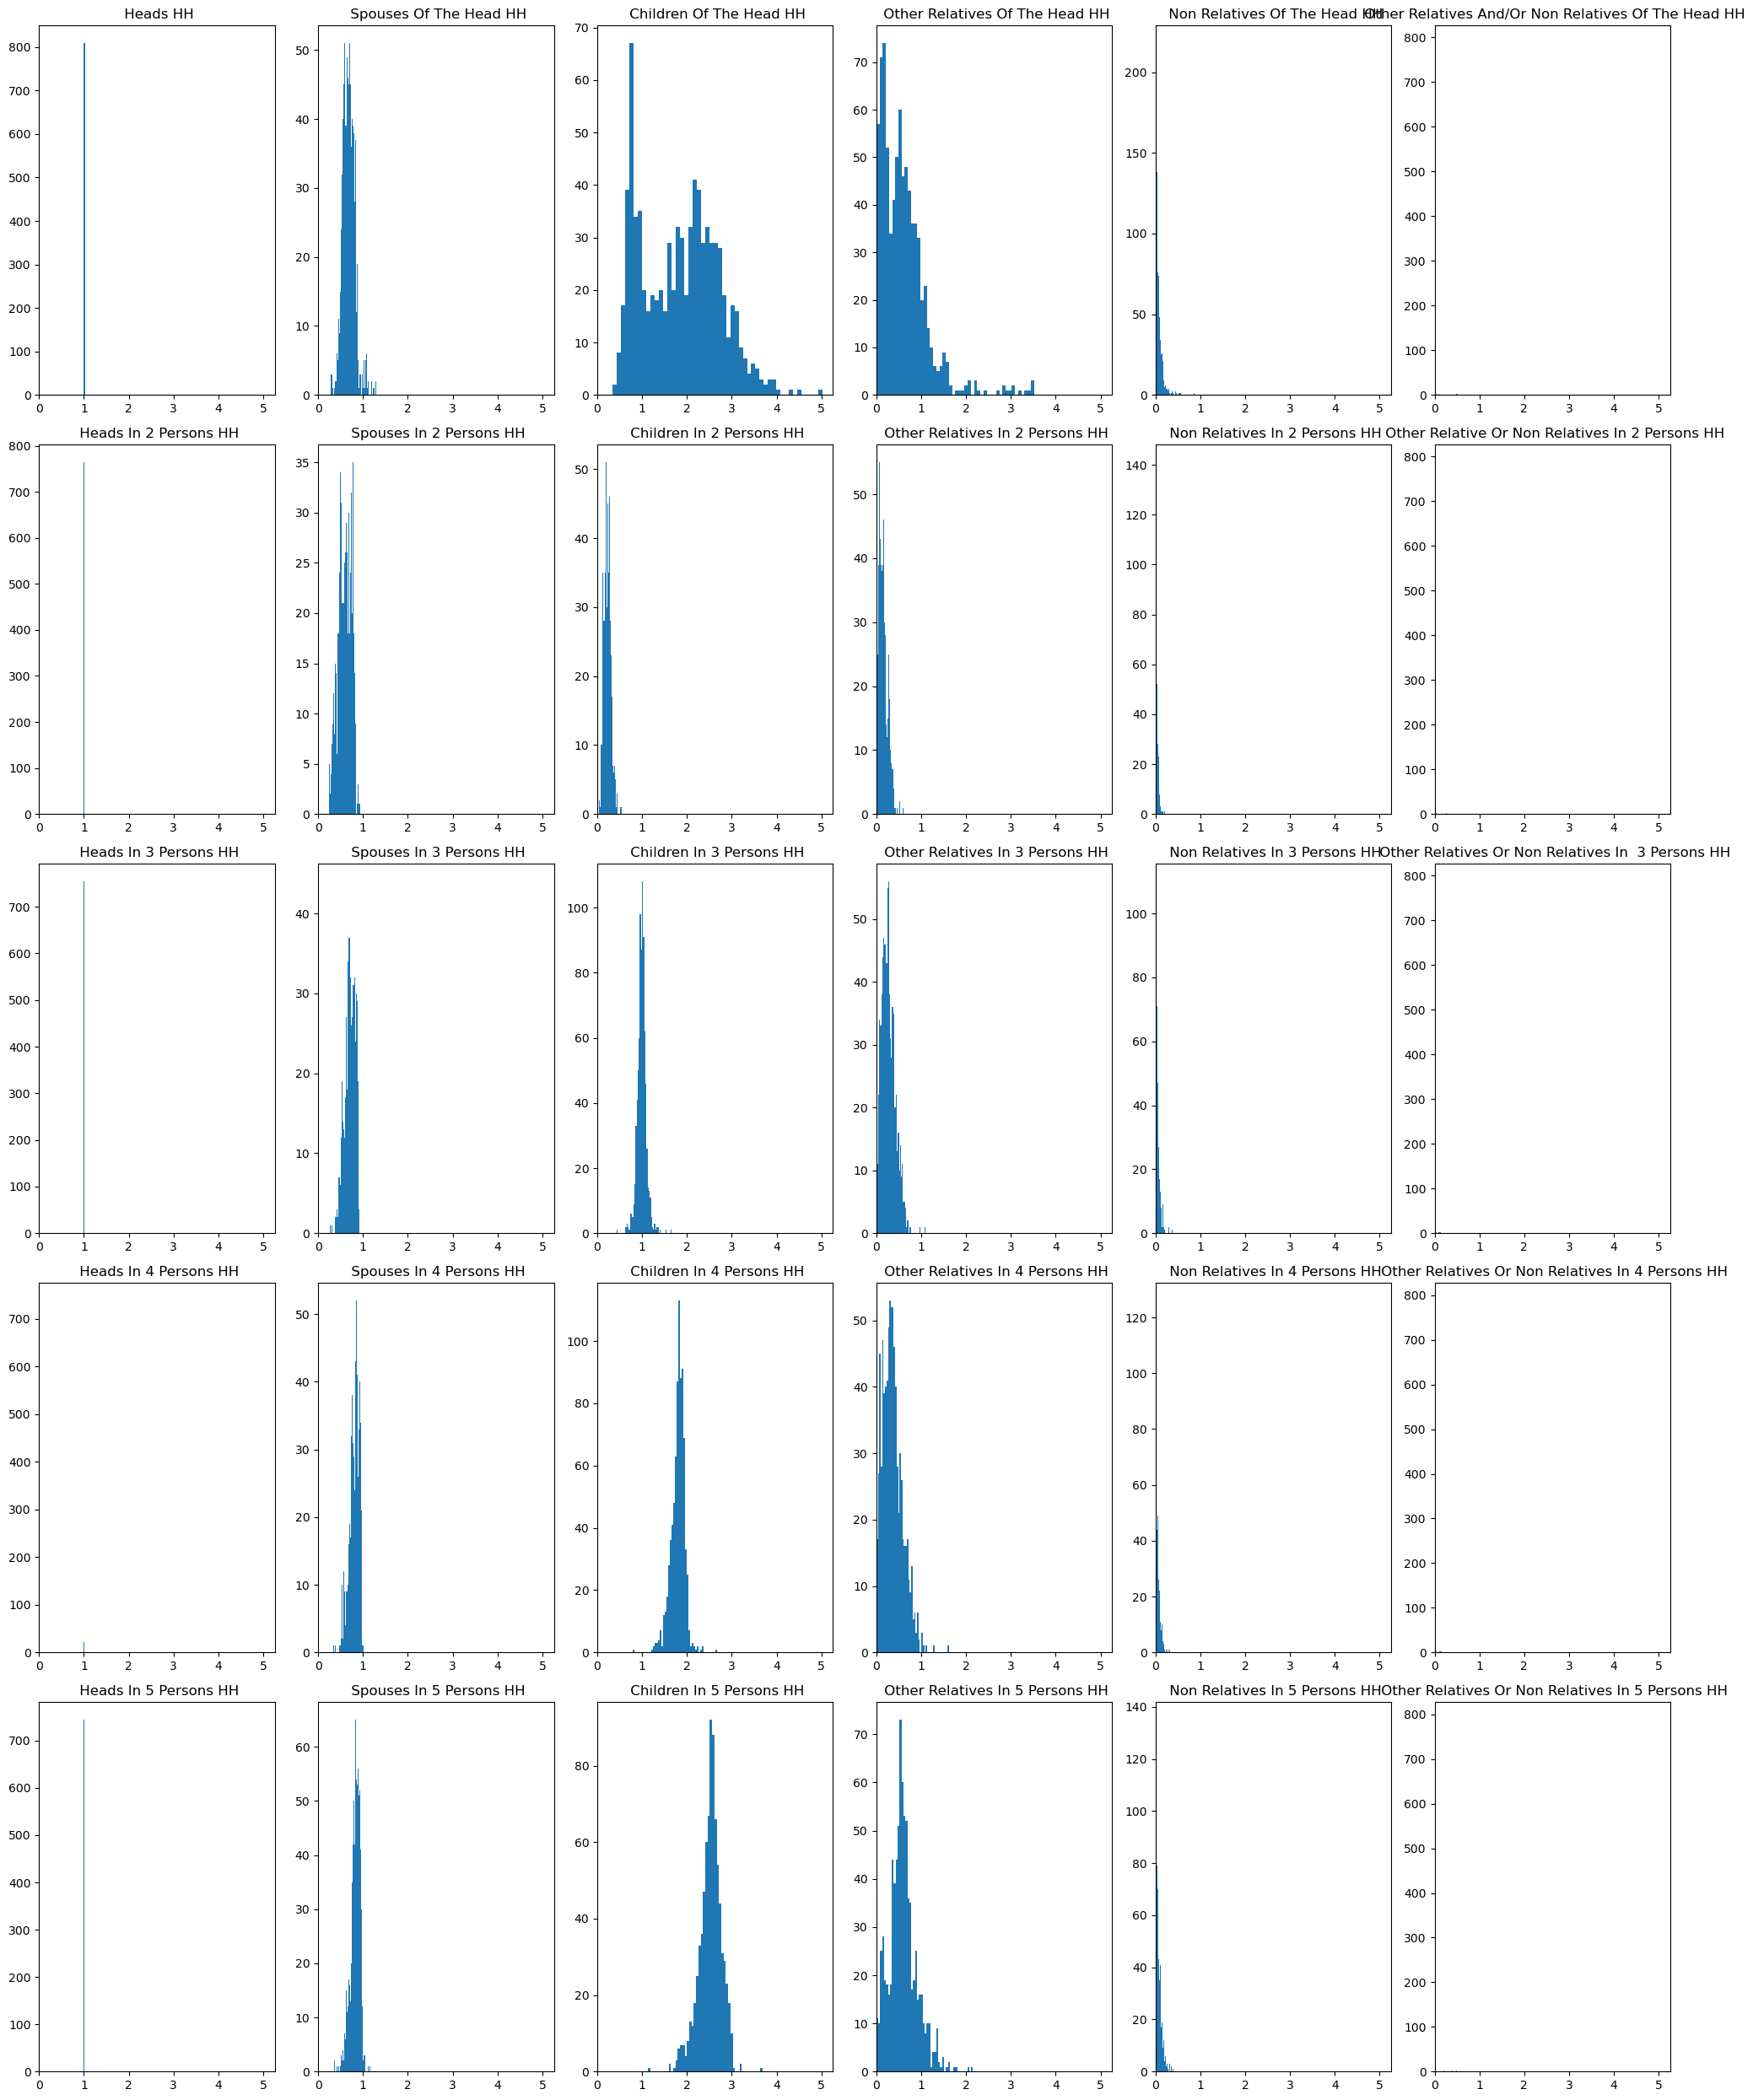

In [58]:
# Average number of people in 1-5 person household

fig, ax = plt.subplots(5, 6, figsize=(20,25))

col_index = 1

for i in range(5):
    for j in range(6):
        col_name = f'HR{col_index:02d}'
        ax[i,j].hist(df[col_name], bins=50)
        title = f"{code_dict.loc[code_dict['Code']==col_name, 'Description'].values[0]}"
        title_stripped = title.replace('Average number of','').replace('in the household', 'household')
        title_stripped = title_stripped.title().replace('Household','HH')
        ax[i,j].set_title(title_stripped)
        #print([i,j], f'{col_name} ', title_stripped)
        col_index += 1



x_maxes = []

for i in range(5):
    for j in range(6):
        x_maxes.append(ax[i,j].get_xlim()[1])
        #print(f'{[i,j]} max is {ax[i,j].get_xlim()[1]}')

x_max = max(x_maxes)

for i in range(5):
    for j in range(6):
        ax[i,j].set_xlim(0, x_max)

plt.tight_layout()
plt.show()

Some takeaways from visual analysis in HR Category:

HR category was perplexing because it contained "average number of a in b-size household." Variable "b" was not specified in the leading category of each a. Thus it was difficult to interpret whether "a[i]b[0]" was intended to be an average of the remaining categories, or a household of unspecified size.

Based on the above analyses, the zero element of the b vector is "unspecified" size

In a household of unspecified size, there is always one head, an average of 2 children (most commonly 1 child, but sometimes 3 or 4), other relative of the head is more common than a spouse. About 75% of the time, there is a spouse. There is rarely (5% of the time) a non-relative inhabitant.

In [59]:
# Examine five person household numbers

five_person_hr = df.loc[:, 'HR25':'HR30'].columns.tolist()
code_dict[code_dict['Code'].apply(lambda x: x in five_person_hr)]

Sub_family  Code  \
54  Relationship to head (R)  HR25   
55  Relationship to head (R)  HR26   
56  Relationship to head (R)  HR27   
57  Relationship to head (R)  HR28   
58  Relationship to head (R)  HR29   
59  Relationship to head (R)  HR30   

                                          Description  
54     Average number of Heads in 5 persons household  
55   Average number of Spouses in 5 persons household  
56  Average number of Children in 5 persons household  
57  Average number of Other relatives in 5 persons...  
58  Average number of Non relatives in 5 persons h...  
59  Average number of Other relatives or Non relat...

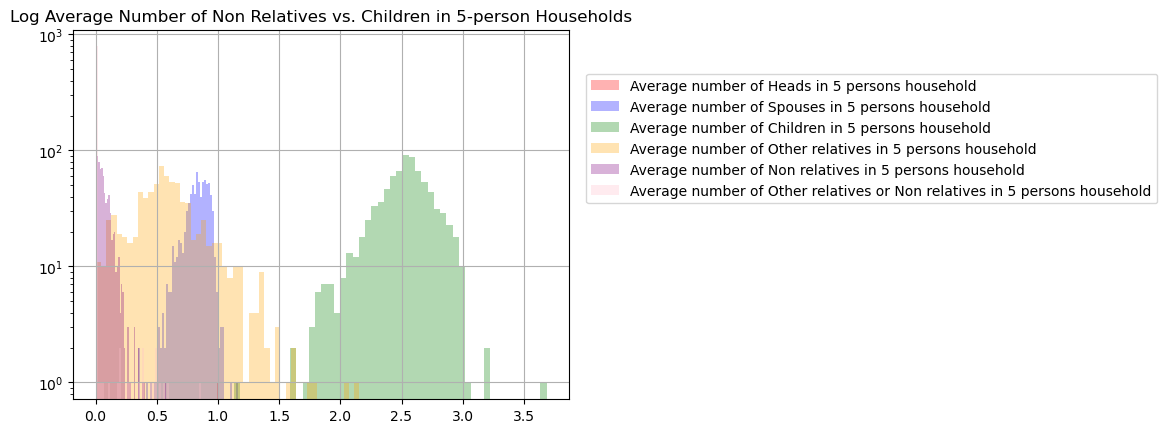

In [60]:
# Avg number of non relatives in 5 person households

colors = ['red', 'blue', 'green', 'orange', 'purple', 'pink']

for i, code in enumerate(five_person_hr):
        df[code].hist(bins=50, label=code_dict.loc[code_dict['Code']==code, 'Description'].values[0], color=colors[i], alpha = 0.3)

        plt.title('Log Average Number of Non Relatives vs. Children in 5-person Households')
        plt.legend()
        
plt.yscale('log')
plt.legend(loc='upper right', bbox_to_anchor=(2.2,0.9))
plt.show()


In [61]:
# Fetch descriptions for "C" and "D" columns
code_dict.loc[code_dict['Code'].str.startswith(('C', 'D', 'S')), ['Code', 'Description']]

Code                              Description
151   C0        Country ISO nomenclature 2 digits
152   C1        Country ISO nomenclature 3 digits
153   C2                                  Country
154   C3                                Continent
155   C4                            Sub continent
156   C5                                   Region
157   C6                              Region Name
158   S1                    Sample identification
159   S2                              Data source
160   S3             Sample region identification
161  S3H  Sample region identification harmonized
168   D1                  Human development index
169   D2             Human development index 2021
170   D3              Expected years of schooling
171   D4                  Mean years of schooling
172   D5                    Gross Domestic income
173   D6         Gross National Income per capita
174   D7           Human development index female
175   D8       Expected years of schooling female
176   D9           Mean years of schooling female
177  D10  Gross National Income per capita female
178  D11             Human development index male
179  D12         Expected years of schooling male
180  D13             Mean years of schooling male
181  D14    Gross National Income per capita male

In [62]:
# Table contains infinite values. Testing .applymap() method to look for inf values
# Something I did to 218 and 219 created infinite values

inf_mask = df.applymap(lambda x: x==np.inf or x==-np.inf)
inf_mask_filter = df.loc[inf_mask.any(axis=1),inf_mask.any(axis=0)]
inf_mask_filter

HT16      HT18      HT31
79   3.594203       inf       inf
325       inf  2.984809  2.984809
547  3.169451       inf       inf
569  4.687744       inf       inf
758  2.451415       inf       inf

In [63]:
# Inspect if HT18 and HT31 have the same values
difference = df['HT18'] - df['HT31']
difference.value_counts()

0.0    805
dtype: int64

In [64]:
# Fill inf values with column mean

inf_index = inf_mask_filter.index

for col in inf_mask_filter.columns:
    for index in inf_index:
        if np.isinf(df.loc[index, col]):
            #print(f"Column {col}, Row {index} is inf")
            replace_num_col = df[col].replace([np.inf, -np.inf], np.nan).dropna()
            replace_col_mean = np.mean(replace_num_col)
            #print(col, replace_col_mean)
            df.loc[index, col] = np.mean(replace_num_col)


In [65]:
# Side-by-side comparison of before and after to check that find and replace worked
pd.concat([inf_mask_filter, df.loc[inf_mask.any(axis=1), inf_mask.any(axis=0)]], axis=1)

HT16      HT18      HT31      HT16      HT18      HT31
79   3.594203       inf       inf  3.594203  1.925730  1.925730
325       inf  2.984809  2.984809  2.835289  2.984809  2.984809
547  3.169451       inf       inf  3.169451  1.925730  1.925730
569  4.687744       inf       inf  4.687744  1.925730  1.925730
758  2.451415       inf       inf  2.451415  1.925730  1.925730

In [66]:
# Inspect dataframe where D columns have null values

df.loc[(df.loc[:,df.columns.str.startswith('D')].isnull().any(axis=1)),:]

# Potential to fill these columns after merge with UN data


C0   C1         C2             C3                  C4    T1    T2  T3  \
5    AR  ARG  Argentina  LATIN-AMERICA       South America  1970  1970   0   
6    AR  ARG  Argentina  LATIN-AMERICA       South America  1980  1980   0   
37   AT  AUT    Austria         EUROPE      Western Europe  1971  1970   0   
38   AT  AUT    Austria         EUROPE      Western Europe  1981  1980   0   
49   BE  BEL    Belgium         EUROPE      Western Europe  1985  1980   0   
..   ..  ...        ...            ...                 ...   ...   ...  ..   
772  VE  VEN  Venezuela  LATIN-AMERICA       South America  1981  1980   0   
773  VE  VEN  Venezuela  LATIN-AMERICA       South America  1990  1990   0   
775  VN  VNM    Vietnam           ASIA  South-Eastern Asia  1989  1990   0   
784  XK  XXK     Kosovo         EUROPE      Eastern Europe  2014  2010   0   
785  XK  XXK     Kosovo         EUROPE      Eastern Europe  2020  2020   1   

       T5   T10  ...  D5         D6  D7  D8       D9          D10  D11  D12  \
5    1966  1960  ... NaN        NaN NaN NaN      NaN          NaN  NaN  NaN   
6    1976  1970  ... NaN        NaN NaN NaN      NaN          NaN  NaN  NaN   
37   1971  1970  ... NaN        NaN NaN NaN      NaN          NaN  NaN  NaN   
38   1981  1980  ... NaN        NaN NaN NaN      NaN          NaN  NaN  NaN   
49   1981  1980  ... NaN        NaN NaN NaN      NaN          NaN  NaN  NaN   
..    ...   ...  ...  ..        ...  ..  ..      ...          ...  ...  ...   
772  1981  1980  ... NaN        NaN NaN NaN      NaN          NaN  NaN  NaN   
773  1986  1980  ... NaN  16424.636 NaN NaN  5.22118  10041.61263  NaN  NaN   
775  1986  1980  ... NaN        NaN NaN NaN      NaN          NaN  NaN  NaN   
784  2011  2010  ... NaN        NaN NaN NaN      NaN          NaN  NaN  NaN   
785  2016  2010  ... NaN        NaN NaN NaN      NaN          NaN  NaN  NaN   

         D13         D14  
5        NaN         NaN  
6        NaN         NaN  
37       NaN         NaN  
38       NaN         NaN  
49       NaN         NaN  
..       ...         ...  
772      NaN         NaN  
773  5.46128  22775.1836  
775      NaN         NaN  
784      NaN         NaN  
785      NaN         NaN  

[112 rows x 178 columns]

In [67]:
# Check how many values are missing per column. Sort by how many values are missing. Rename results of query.

major_missing_values = (
    pd.DataFrame(
        df
        .isnull().sum().sort_values(ascending=False)
        .reset_index()
        .head(15)
        .rename(columns={'index':'Code', 0:'Num Missing'})
    )
)

major_missing_values

# First merge attempt failed due to data type mismatch. Changing the datatype of the query to match merge table
#major_missing_values['Code'] = major_missing_values['Code'].astype('object')

Code  Num Missing
0   D11          112
1    D7          112
2    D5          112
3   D12           99
4    D8           99
5    D1           90
6   D13           88
7    D9           88
8    D4           87
9    D3           78
10  D14           77
11  D10           77
12   D6           76
13   D2           10
14   C0            4

In [68]:
# Merge column Code names with Descriptions. Inspect the descriptive names of columns with substantial missing values
mmv_df = major_missing_values.merge(code_dict[['Code','Description']], on='Code', how='left')
mmv_df

# I want to keep these columns, as they are informative. I will deal with missing values by dropping rows instead
# Or imputing values using UN data

Code  Num Missing                              Description
0   D11          112             Human development index male
1    D7          112           Human development index female
2    D5          112                    Gross Domestic income
3   D12           99         Expected years of schooling male
4    D8           99       Expected years of schooling female
5    D1           90                  Human development index
6   D13           88             Mean years of schooling male
7    D9           88           Mean years of schooling female
8    D4           87                  Mean years of schooling
9    D3           78              Expected years of schooling
10  D14           77    Gross National Income per capita male
11  D10           77  Gross National Income per capita female
12   D6           76         Gross National Income per capita
13   D2           10             Human development index 2021
14   C0            4        Country ISO nomenclature 2 digits

In [69]:
# Compiling a list of uninformative or vague columns to drop in preprocessing

drop_cols_list = ['C0', 'C2', 'C4', 'T2', 'T3', 'T5', 'T10', 'S1', 'S2']

drop_cols = pd.DataFrame(drop_cols_list, columns=['Code'])
drop_cols_schema = pd.DataFrame(drop_cols.merge(code_dict[['Code', 'Description']], on='Code', how='left').values, 
                                columns=['Code', 'Description'])

# Inspect features and descriptions of features to be dropped
drop_cols_schema


Code                        Description
0   C0  Country ISO nomenclature 2 digits
1   C2                            Country
2   C4                      Sub continent
3   T2                       Census round
4   T3                   Most recent year
5   T5                         Five years
6  T10                             Decade
7   S1              Sample identification
8   S2                        Data source

#### Changes Log (df)

List of changes to CoResidence table (df) thus far:

- Column 'DB' dropped. Column is a metadata tag (all row == "National") (as opposed to Sub-National).

- Errant null values forward and back filled in rows 218, 219, 427, 428

- 36 rows within six proportional column groupings that fail to add-to-one were normalized (see normalize_groups variable for proportional column groupings)

- Null values in Household Typology columns (HT) replaced with zeros, as these are assumed to be sub-detectable averages

- inf values identified in rows 79, 325, 547, 569, 758 and replaced with column means


### Exploratory Feature Selection

This is a feature-rich dataset (with over 150 features), which makes analysis daunting. Which features to begin with? Which target to select? In this section, I create a branch of table df called df_kbest (df.copy()) to handle preliminary feature selection.

In this section, I use multiple info regression as a feature selection method to gain cursory insight. I chose mutual information regression because it is agnostic to linearity. The "mutual_info_regression" function uses Euclidean distance between points as a proxy to estimate the joint probability density for each feature-target pair. These estimated densitites are then used to maximize dependency (or minimize uncertainty) in the feature-target relationship.

The intent of using MI at this stage is not to eliminate features, understand feature relationships deeply, or to select a model. MI evaluates feature-target relationships in a univariate fashion, which cannot capture feature interactions. Thus, it is not a substitute for a model. The intent is rather to examine features at a high level.

The provisional target variable chosen initially is column 'D1', "Human Development Index", (which is a weighted sum of various measures of human flourishing). Feature selection is also used to evaluate target definition. 

After correcting invalid data in the previous section (see Changes Log), I backfill and forward fill columns with major missing values, and drop any remaining rows with missing values. Then I run the mutual_info_regression function and 

A column list drop_cols_list was formulated in the previous section, for columns to be removed as part of model preprocessing. See variable drop_cols_schema for information about drop columns. In general, these columns contain metadata tags or categorical data, which are not useful for modeling purposes


In [70]:
# Create a kbest copy of dataframe to run feature selection, drop null-containing rows
df_kbest = df.copy()

In [71]:
# Null values in "D" columns to be filled by backfill and forward fill, if country name is a match

df_kbest.loc[:, df_kbest.columns.str.startswith('D')] = (
    df_kbest
    .groupby('C1', group_keys=False)
    [df_kbest.columns[df_kbest.columns.str.startswith('D')]]
    .transform(
    lambda x: x.ffill().bfill()
)
                                                        )

In [72]:
# examine d groups for reduction
missing_d_vals = df_kbest.loc[:, df_kbest.columns.str.startswith('D')].isnull().sum()
missing_d_vals.name = 'missing_d_vals'

# compare missing dvals to mmv_df

missing_d_diff = mmv_df.merge(missing_d_vals, left_on='Code', right_on=missing_d_vals.index, how='left')

In [73]:
# observe drastic reduction in missing d values
missing_d_diff

Code  Num Missing                              Description  missing_d_vals
0   D11          112             Human development index male            13.0
1    D7          112           Human development index female            13.0
2    D5          112                    Gross Domestic income            13.0
3   D12           99         Expected years of schooling male            11.0
4    D8           99       Expected years of schooling female            11.0
5    D1           90                  Human development index            11.0
6   D13           88             Mean years of schooling male            11.0
7    D9           88           Mean years of schooling female            11.0
8    D4           87                  Mean years of schooling            10.0
9    D3           78              Expected years of schooling            11.0
10  D14           77    Gross National Income per capita male            10.0
11  D10           77  Gross National Income per capita female            10.0
12   D6           76         Gross National Income per capita             9.0
13   D2           10             Human development index 2021            10.0
14   C0            4        Country ISO nomenclature 2 digits             NaN

In [74]:
# drop remaining null values to prepare for feature selection and preliminary models
df_kbest = df_kbest.dropna()

In [75]:
# Check for successful drop of null values
df_kbest.isnull().sum().sum()

0

In [76]:
# shuffle the data, then sort by year to ensure that no one country is overly sampled in a fold

df_kbest = df_kbest.sample(frac=1)
df_kbest = df_kbest.sort_values(by='T1')


In [77]:
# Split the data with target == 'D1'which corresponds to column "Human Development Index"
# Drop 'C1' country code, 'C3' (continent), 'D1' (target), plus drop cols list

X = df_kbest.drop(drop_cols_list + ['C1', 'C3', 'D1'], axis=1)

y = df_kbest['D1']

In [78]:
# Check for any non-numeric columns

numeric = X.select_dtypes(include=['number'])

for col in X.columns:
    if col not in numeric.columns:
        description = code_dict[code_dict['Code']==col]['Description'].values[0]
        print(f"{col} not numeric. {col} datatype is {X[col].dtype}, {description}")
        

In [79]:
# run selector
mi_scores = mutual_info_regression(X, y, random_state=21)

In [80]:
# Create a dataframe to display selector metrics

metrics_df = pd.DataFrame(zip(X.columns, mi_scores), columns=['Code', 'MI Score'])

In [81]:
# Pull in 'Description' names of features from code_dict for features deemed important according to KBest selector
metrics_df = metrics_df.merge(code_dict[['Code','Description']], on='Code', how='left')


In [82]:
# Inspect columns deemed important by KBest selector

metrics_df.sort_values(by='MI Score', ascending=False).head(10)


Code  MI Score                              Description
162  D11  2.699254             Human development index male
158   D7  2.548003           Human development index female
157   D6  1.629628         Gross National Income per capita
161  D10  1.572226  Gross National Income per capita female
165  D14  1.513473    Gross National Income per capita male
154   D3  1.478223              Expected years of schooling
159   D8  1.435917       Expected years of schooling female
164  D13  1.341821             Mean years of schooling male
160   D9  1.326255           Mean years of schooling female
163  D12  1.320086         Expected years of schooling male

### Exploratory Feature Selection Summary

Choosing HDI (column 'D1') as a provisional target value creates indirect (extra-tabular) data leakage via the 'D' and 'P' columns, which are the constituent elements of the Human Development Index. In other words, the features identified as most salient to the model are the very same features used to generate HDI, which is unsuprising in hindsight. 

Two potential solutions: (1) Select a different target, or (2) Exclude composite index feature columns from the model. 

For the purposes of preliminary feature analysis, we will drop the 'D' and 'P' columns to observe only household configuration columns.

In [83]:
# Drop the D and P columns and try again, as the D columns the constituent indices of HDI

X = X.drop(X.columns[X.columns.str.startswith(('D','P'))], axis=1)


In [84]:
# Run selector again without d cols in X

mi_scores_2 = mutual_info_regression(X, y, random_state=22)


In [85]:
# metrics_df_2

metrics_df_2 = pd.DataFrame(zip(X.columns, mi_scores_2), columns=['Features', 'MI Score II'])

metrics_df_2 = metrics_df_2.merge(code_dict[['Code','Description']], left_on='Features', right_on='Code', how='left')

In [86]:
# Examine features without confounding D-features

with pd.option_context('display.max_colwidth', None):
    display(metrics_df_2.sort_values(by='MI Score II', ascending=False).head(10))

# Will be interesting to see if these remain the most salient features after imputation

Features  MI Score II  Code  \
20      HS20     0.816796  HS20   
22      HS22     0.784403  HS22   
129     HH39     0.760699  HH39   
23      HS23     0.749764  HS23   
18      HS18     0.731082  HS18   
127     HH37     0.712216  HH37   
15      HS15     0.706133  HS15   
2       HS02     0.676709  HS02   
14      HS14     0.675241  HS14   
17      HS17     0.670259  HS17   

                                                         Description  
20           Average number of children in the household (aged < 18)  
22                Average number of 0-9 individuals in the household  
129             Average number of children in male-headed households  
23              Average number of 10-19 individuals in the household  
18                   Average number of 0-4 children in the household  
127                 Average household size of male-headed households  
15   Proportion of households with at least one person 0-4 years old  
2                                 Proportion of 2-persons households  
14                               Proportion of 6+ persons households  
17                                            Average household size

In [87]:
# Write a formula to streamline this modelling loop

def tscv_loop(X, y, n_splits, models=None):
    """ 
    Runs cross validation on a time series split and evaluates models. Data must be sorted by time units.
    
    Parameters: 
    - X (DataFrame): Feature matrix
    - y (Series): Target variable
    - n_splits (Integer): (TimeSeriesSplit number of splits)
    - models (dict): Dictionary of model names and initialized models. Defaults to Lasso, Ridge, and Random Forest
    
    Returns: DataFrame: Train/Test scores for each fold
    """
    
    if models is None:
        models = {
            "Linear Regression" : LinearRegression(),
            "Lasso" : Lasso(alpha=0.1),
            "Ridge" : Ridge(),
            "Random Forest" : RandomForestRegressor(random_state=21)
                 }
        
    results = []
    
    tscv = TimeSeriesSplit(n_splits = n_splits)
    
    for i, (train_index, test_index) in enumerate(tscv.split(X)):
        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        X_test, y_test = X.iloc[test_index], y.iloc[test_index]
        
        fold_scores = {"Fold":i+1}
    
        for model_name, model in models.items():
            model.fit(X_train, y_train)
            train_score = model.score(X_train, y_train)
            test_score = model.score(X_test, y_test)
        
            fold_scores[f"{model_name} Train Score"] = train_score
            fold_scores[f"{model_name} Test Score"] = test_score
        
        results.append(fold_scores)
        #print(fold_scores)
    
    return pd.DataFrame(results)

In [88]:
# train vs. test scores

ex_model_scores = tscv_loop(X, y, 3)
ex_model_scores

Fold  Linear Regression Train Score  Linear Regression Test Score  \
0     1                       0.867561                     -1.159154   
1     2                       0.830810                      0.232308   
2     3                       0.850294                      0.700397   

   Lasso Train Score  Lasso Test Score  Ridge Train Score  Ridge Test Score  \
0           0.215844          0.210778           0.603926          0.593838   
1           0.349938          0.190948           0.735546          0.796834   
2           0.355602          0.305274           0.797420          0.706935   

   Random Forest Train Score  Random Forest Test Score  
0                   0.912132                  0.688756  
1                   0.961419                  0.880792  
2                   0.971306                  0.874725

### Core Table Validation and Exploratory Model Summary

Initial feature selection showed indirect data leakage from 'P' and 'D' columns (population and development information), into target column HDI (Human Development Index). Leaky features were dropped to examine feature-target relationships, in exclusion of problematic features.

Moving forward with this analysis, one solution for leakage would be to drop the leaky features from the data. However, these features likely have meaningful impacts on the target, or important interactions with other features. Dropping the features wholesale would constitute a loss of valuable information.

In order to select a target that is independent of, and free from, data leakage, while preserving population and development data, I will import a new target:

In addition to feature selection analysis, exploratory linear regressions:

1) Time series cross validated train and test scores were generated (n_splits=3). 
2) Substantial divergence between training scores and test scores on first two folds.
4) Superior test scores on latter fold may be a function of later data being more complete
 
**Potential to compare HDI to Gini later in the analysis**


## Table 2: Gini Index

In the previous section, I conducted a preliminary feature selection analysis using a linearity-agnostic method (mutual info regression). This analysis made clear that my original choice for a target variable, Human Development Index ('D1') was subject to data leakage vis a vis the index's consituent indices ('P' and 'D' columns). 

To avoid eliminating potentially informative features, I select a new target variable. Gini Index is a good choice because the methodology of generating the index does not rely on the leaky features at all, Gini data is readily available, and Gini is informative as to the quality of human flourishing, which is the qualitative goal of this study. 

Similar to using a median statistic, rather than a mean statistic, Gini Index provides an indication of whether the "happiness" of a populace is typical or atypical.

Using the Gini Index as a new target introduces new and interesting challenges. Gini data is available for similar year ranges as CoResidence data, but not every year in the Gini range matches the years in the CoResidence range. As a result, it is necessary to conduct an outer merge, in order to preserve all Gini data. This creates a substantial number of blank rows, which must then be managed.

Missing values are handled using custom imputation methods, including domain knowledge imports of additional data, interpolation, iterative imputer (BayesianRidge to handle sparse matrices), and post-imputation processing such as scaling and normalization.  

Gini Index table is horizontal (266, 69) consists of:
- 266 countries (1 row per country)
- 69 columns consist of the 64 years in the range, 1960-2024, as well as 'Country Name', 'Country Code', and two columns that are uninformative to our purposes.
- Table is melted into long format. New shape is (17,024, 4)
- The vast majority of rows in the Gini table are blank. Not all years represented have Gini values: Only 2,108 values out of 17,024 are not null. 98 countries (37%) have no gini values at all.

Changes made to merged table before merge:
- Uninformative columns were dropped: 'Indicator Name' (all values = 'Gini index), 'Indicator Code' (all values = 'SI.POV.GINI'), and 'Unnamed: 68' (all values NaN)
- Uninformative columns are dropped outright, and wide shape (266, 69) is melted into vertical shape (17024, 4) with 64 * 266 rows (64 year-rows per country).

Changes made to table after merge:
- Countries where all Gini values are blank are deleted
- 


In [89]:
# Read in gini index dataset for new target selection

file_path = './API_SI.POV.GINI_DS2_en_csv_v2_3401539/API_SI.POV.GINI_DS2_en_csv_v2_3401539.csv'
gini_df = pd.read_csv(file_path,
                     skiprows=3)


In [90]:
# Wide format data must be melted on 'Year'. 
# Drop columns which are not needed and will complicate melt.
gini_df = gini_df.drop(['Indicator Name', 'Indicator Code', 'Unnamed: 68'], axis=1)

In [91]:
# Melt into long format with Gini values in Year variable
gini_df = pd.melt(gini_df, id_vars=['Country Name', 'Country Code'], var_name='Year', value_name='Gini')


In [92]:
# Inspect post-melt table
gini_df.loc[gini_df['Gini'].notnull()].head()
print(gini_df.shape)

(17024, 4)


In [93]:
# How many countries have all null Gini values

all_null_gini = gini_df.groupby('Country Code')['Gini'].apply(lambda x: x.isnull().all())
all_null_gini[all_null_gini]

print(f"Percentage of countries with no Gini values: {round(len(all_null_gini[all_null_gini])/gini_df['Country Code'].nunique()*100, 2)}%")



Percentage of countries with no Gini values: 36.84%


In [94]:
# Assess CoResidence column candidates for merge join condition 'C1' (Country Code) vs. 'C2' (Country Name)

print(f"Country Code in CoResidence but not in Gini:"
      f"{[value for value in df['C1'].unique() if value not in gini_df['Country Code'].unique()]}")

print(f"Country Code in Gini but not in CoResidence:"
     f"{[value for value in gini_df['Country Code'].unique() if value not in df['C1'].unique()]}")
      
# XXK and XKX are 'Kosovo' and names will be standardized

Country Code in CoResidence but not in Gini:['XXK']
Country Code in Gini but not in CoResidence:['ABW', 'AFE', 'AFW', 'AND', 'ARB', 'ARE', 'ASM', 'ATG', 'BHR', 'BHS', 'BMU', 'BRB', 'BRN', 'CEB', 'CHI', 'CPV', 'CSS', 'CUW', 'CYM', 'DMA', 'EAP', 'EAR', 'EAS', 'ECA', 'ECS', 'EMU', 'ERI', 'EUU', 'FCS', 'FRO', 'FSM', 'GIB', 'GNQ', 'GRD', 'GRL', 'GUM', 'HIC', 'HKG', 'HPC', 'IBD', 'IBT', 'IDA', 'IDB', 'IDX', 'IMN', 'INX', 'ISL', 'JPN', 'KIR', 'KNA', 'KWT', 'LAC', 'LBN', 'LBY', 'LCN', 'LDC', 'LIC', 'LIE', 'LKA', 'LMC', 'LMY', 'LTE', 'MAC', 'MAF', 'MCO', 'MEA', 'MHL', 'MIC', 'MLT', 'MNA', 'MNP', 'NAC', 'NCL', 'NOR', 'NRU', 'NZL', 'OED', 'OMN', 'OSS', 'PLW', 'PRE', 'PRK', 'PSS', 'PST', 'PYF', 'SAS', 'SAU', 'SGP', 'SLB', 'SMR', 'SSA', 'SSF', 'SST', 'SXM', 'SYC', 'TCA', 'TEA', 'TEC', 'TLA', 'TMN', 'TON', 'TSA', 'TSS', 'UMC', 'VCT', 'VGB', 'VIR', 'VUT', 'WLD', 'XKX']


In [95]:
# Examine country names in CoResidence (df['C2']) but not in Gini (gini_df['Country Name'])

mismatched_country_names = [value for value in df['C2'].unique() if value not in gini_df['Country Name'].unique()]
mismatched_country_names = df.loc[df['C2'].isin(mismatched_country_names),'C1': 'C2']
print(f'Following country names are in CoResidence but not Gini:')
print(mismatched_country_names.value_counts())
mismatched_country_names.nunique()

Following country names are in CoResidence but not Gini:
C1   C2                       
EGY  Egypt                        10
KOR  South Korea                   9
VNM  Vietnam                       8
TUR  Turkey                        8
CZE  Czech Republic                5
VEN  Venezuela                     4
LAO  Laos                          4
SVK  Slovakia                      4
PSE  Palestine                     3
COD  Congo Democratic Republic     2
RUS  Russia                        2
MKD  Macedonia                     2
COG  Congo                         2
LCA  Saint Lucia                   2
IRN  Iran                          2
GMB  Gambia                        2
YEM  Yemen                         2
SYR  Syria                         1
dtype: int64


C1    18
C2    18
dtype: int64

In [96]:
# Examine why country names were mismatched, while respective codes were not, with side-by side comparison of both tables
# Missing countries are correctly encoded, but have minor spelling differences

gini_df.loc[
    gini_df['Country Code'].isin(mismatched_country_names['C1']), 
    ['Country Name', 'Country Code']].merge(df[['C1', 'C2']], 
                                            right_on='C1', left_on='Country Code', how='left').drop_duplicates()


Country Name Country Code   C1                         C2
0       Congo, Dem. Rep.          COD  COD  Congo Democratic Republic
2            Congo, Rep.          COG  COG                      Congo
4                Czechia          CZE  CZE             Czech Republic
9       Egypt, Arab Rep.          EGY  EGY                      Egypt
19           Gambia, The          GMB  GMB                     Gambia
21    Iran, Islamic Rep.          IRN  IRN                       Iran
23           Korea, Rep.          KOR  KOR                South Korea
32               Lao PDR          LAO  LAO                       Laos
36             St. Lucia          LCA  LCA                Saint Lucia
38       North Macedonia          MKD  MKD                  Macedonia
40    West Bank and Gaza          PSE  PSE                  Palestine
43    Russian Federation          RUS  RUS                     Russia
45       Slovak Republic          SVK  SVK                   Slovakia
49  Syrian Arab Republic          SYR  SYR                      Syria
50               Turkiye          TUR  TUR                     Turkey
58         Venezuela, RB          VEN  VEN                  Venezuela
62              Viet Nam          VNM  VNM                    Vietnam
70           Yemen, Rep.          YEM  YEM                      Yemen

In [97]:
# Update 'Year' in gini_df to match data type of T1 (year in df) to facilitate merge

gini_df['Year'] = gini_df['Year'].astype('int64')

In [98]:
# Update Kosovo C1 value in left table to XKX to match right table to ensure proper merges with gini_df

df.loc[df['C1']=='XXK', 'C1'] ='XKX'

### MERGE 1: Coresidence and Gini

Merge tables: df outer merged with gini_df. 
- Shape of df before merge is (809, 178)
- Shape of df_merge1 (df after merge) is (17,036, 182)

Merged on ISO code and 'Year' ('T1'). First merge condition is 'C1' (Country ISO nomenclature 3 digits) on CoResidence (left) table, which matches to 'Country Code' on (right) table Gini Index. 'Country Name' ('C2') would have been another potential merge condition, but presents too many variations in spelling.

Kosovo country code was the only three digit ISO code to have any variation between tables, and was updated in CoResidence (left table) to prepare for the merge. No other country codes were altered in CoResidence. 

Left table does not have all years within total time range populated, therefore a left merge on 'T1' ('Year') would eliminate Gini data.

In preparation for interpolation and imputation, countries with fewer than two Gini values and fewer than two rows of Core Feature ('H' columns) are identified.


In [99]:
# Merge df with gini df. C1= Country Code, C2 = Country Name, T1 = Year

print(f'Shape before merge is {df.shape}')

df_merge1 = df.merge(gini_df, left_on=['C1', 'T1'], right_on=['Country Code', 'Year'], how='outer')

print(f'Shape after merge is {df_merge1.shape}')

Shape before merge is (809, 178)
Shape after merge is (17036, 182)


In [100]:
# How many countries

merge1_country_total = df_merge1['Country Code'].nunique()

print(f"Total number of countries after merge: {merge1_country_total}")

Total number of countries after merge: 266


In [101]:
# Sort values. Inspect merge results
df_merge1 = df_merge1.sort_values(by=['Country Code', 'Year'])

In [102]:
# how many countries have no gini data at all in gini 
all_gini_nulls = gini_df.groupby('Country Code', group_keys=False)['Gini'].apply(lambda x: x.isnull().all())

print(f"Countries with no Gini data: {len(all_gini_nulls[all_gini_nulls])}, Total rows with no Gini data: {len(gini_df.loc[gini_df['Country Code'].isin(all_gini_nulls[all_gini_nulls].index),:])}")
print(f"Total rows in data: {len(gini_df)}")

Countries with no Gini data: 98, Total rows with no Gini data: 6272
Total rows in data: 17024


In [103]:
# drop rows of countries with fewer than two gini values (two values needed for interpolation)

two_fewer_gini = (
    df_merge1
    .groupby('Country Code', group_keys=False)['Gini']
    .apply(lambda group: group.notnull().sum()<2)
)

two_fewer_gini_countries = two_fewer_gini[two_fewer_gini].index
print(f"{len(two_fewer_gini_countries)} with fewer than two rows of Gini values")
two_fewer_gini_countries
# 98 countries have no Gini values at all, should be dropped

108 with fewer than two rows of Gini values


Index(['ABW', 'AFE', 'AFG', 'AFW', 'AND', 'ARB', 'ASM', 'ATG', 'BHR', 'BHS',
       ...
       'TLA', 'TMN', 'TSA', 'TSS', 'TUV', 'UMC', 'VCT', 'VGB', 'VIR', 'WLD'],
      dtype='object', name='Country Code', length=108)

In [104]:
# examine countries with fewer than two rows of core feature ('H') data

h_cols = df_merge1.columns.str.startswith('H')
two_fewer_hh = (
    df_merge1
    .groupby('Country Code', group_keys=False)
    .apply(lambda group: (
        group.loc[:, h_cols].notnull().sum()<2
    )
           .all())
)
    
two_fewer_hh_countries = two_fewer_hh[two_fewer_hh].index
len(two_fewer_hh_countries)
two_fewer_hh_countries

Index(['ABW', 'AFE', 'AFG', 'AFW', 'AGO', 'AND', 'ARB', 'ARE', 'ASM', 'ATG',
       ...
       'TSS', 'TUN', 'TUV', 'UMC', 'VCT', 'VGB', 'VIR', 'VUT', 'WLD', 'WSM'],
      dtype='object', name='Country Code', length=133)

In [105]:
# union of two fewer hh and two fewer gini

two_fewer_countries = two_fewer_gini_countries.union(two_fewer_hh_countries)
len(two_fewer_countries)

139

In [106]:
# Create a drop row index corresponding to these countries

two_fewer_drop_index = []

for country in two_fewer_countries:
    country_index = df_merge1[df_merge1['Country Code']==country].index
    two_fewer_drop_index.extend(country_index)

In [107]:
len(two_fewer_drop_index)

8896

In [108]:
# drop two_fewer_drop_index as these changes should apply to all future merges

df_merge1 = df_merge1.drop(two_fewer_drop_index)

In [109]:
# define a small gini range as less than a decade of gini data

max_year = df_merge1[df_merge1['Gini'].notnull()].groupby('Country Code')['Year'].max()
min_year = df_merge1[df_merge1['Gini'].notnull()].groupby('Country Code')['Year'].min()

# check if indexes are equal before zipping
max_year.index.equals(min_year.index)

True

In [110]:
# calculate year range and inspect results
year_range = pd.DataFrame(
    zip(min_year.index, max_year.index, min_year, max_year, max_year-min_year), 
    columns=['Min Country','Max Country','Min', "Max", "Diff"]
)

small_gini_range = year_range[year_range['Diff']<8]
small_gini_range

Min Country Max Country   Min   Max  Diff
23          COG         COG  2005  2011     6
75          MMR         MMR  2015  2017     2
112         TTO         TTO  1988  1992     4
113         TUR         TUR  2017  2021     4

In [111]:
# construct small gini range countries drop index

small_gini_range_countries = small_gini_range['Min Country']

small_gini_range_drop_index = df_merge1[df_merge1['Country Code'].isin(small_gini_range_countries)].index

In [112]:
# drop small gini range

df_merge1 = df_merge1.drop(small_gini_range_drop_index)

In [113]:
# df_merge1 shape and values

df_merge1.shape
df_merge1['Country Code'].value_counts()

NPL    66
FRA    65
BGD    65
COL    65
NGA    65
       ..
GIN    64
GHA    64
GBR    64
GAB    64
ZWE    64
Name: Country Code, Length: 123, dtype: int64

In [114]:
# validate drops so far

original_country_total = df['C1'].nunique()

countries_dropped = list(two_fewer_gini_countries.union(two_fewer_hh_countries.union(small_gini_range_countries)))
num_countries_dropped = len(countries_dropped)
countries_remaining = df_merge1['Country Code'].drop_duplicates().reset_index(drop=True).tolist()
num_countries_remaining = df_merge1['Country Code'].nunique()


assert (merge1_country_total == num_countries_dropped + num_countries_remaining), "Uh-oh lost track of a country!"
print(f"Original Country Total: {original_country_total}, Countries Dropped: {num_countries_dropped}, Countries Remaining: {num_countries_remaining}")



Original Country Total: 157, Countries Dropped: 143, Countries Remaining: 123


In [115]:
# countries remaining versus original coresidence country list 
original_countries = list(df['C1'].unique())
dropped_cores_countries = [country for country in original_countries if country not in countries_remaining]
print(f"Number of countries dropped from CoResidence data: {len(dropped_cores_countries)}")
print(f"Name of countries dropped: {df.loc[df['C1'].isin(dropped_cores_countries), 'C2'].unique()}")

Number of countries dropped from CoResidence data: 34
Name of countries dropped: ['Afghanistan' 'Angola' 'Azerbaijan' 'Belize' 'Bhutan' 'Canada' 'Congo'
 'Cuba' 'Djibouti' 'Denmark' 'Finland' 'Georgia' 'Guyana' 'Haiti' 'Iraq'
 'Cambodia' 'Saint Lucia' 'Myanmar' 'Puerto Rico' 'Qatar' 'Sudan'
 'Somalia' 'South Sudan' 'Sao Tome and Principe' 'Suriname' 'Sweden'
 'Eswatini' 'Syria' 'Turkmenistan' 'Trinidad and Tobago' 'Tunisia'
 'Turkey' 'Tuvalu' 'Samoa']


### Merge 1 Summary

Concluding the merge between the CoResidence and Gini Index tables, the dataframe **df_merge1** is created. This df_merge1 is the most filtered version of the dataset. In other words, the rows in df_merge1 constitute the set of final rows to be included in this analysis. **Any future merges will branch off of df_merge1** and will be named according to merge order.

Filtering of rows was performed with interpolation and iterative imputation methods in mind. In other words, in order to conceptualize change, at least two points (or vectors) in are required (before-and-after). Ideally, more than two observations are available per features/target pairing. Countries with fewer than two rows of Gini data (target) or fewer than two rows of CoResidence core feature data were dropped.

Moving forward with this analysis, target values ('Gini') will be interpolated using linear spline interpolation. I chose linear spline, out of a limited set of choices (given the sparsity of data), rather than pure linear interpolation. Spline was selected to mimic the typical shape of continuous variables in sociological data.

In order to ensure that our (sparse) Gini data is as informative as possible, countries a smaller than 8-year timespan of Gini data were also excluded. The rationale being that 8 years is 'almost a decade' and enough time to represent something real about the country in question...

Conforming to the aforementioned requirements, ((a) two or more rows of Gini data, a timespan of at least 8 years of Gini values, (b) at least two rows of core feature ('H' columns data, and (c) 8+ year timespan for Gini values), unfortunately required many countries to be dropped. Out of the original 157 countries in CoResidence, 34 were dropped, with 123 remaing. 

More than half of 266 countries in the Gini dataset were dropped. Many of these countries were merged into CoResidence in an outer merge, despite having no match in the original CoResidence data. Of the original CoResidence 157 countries, 34 were dropped, with 123 remaining. Increasing thresholds for non-missing row quantities would have resulted in dropping many more countries.

# Section III: Missing Values

## A: Interpolation - Baseline Algorithmic

Now that CoResidence is properly merged with the new target variable, Gini, and properly filtered down to rows with workable data, I interpolate missing values, using a simple "two brushstroke" approach (to use a painting metaphor).

Any method selected for handling missing values involves implicit assumptions. The resulting data, after filling missing values, is a type of simulation, which can only be as accurate as those assumptions are valid. I chose linear spline rather than purely linear data, as sociological phenomena typically change in curves, not straight lines. This is an assumption. It may or may not be accurate.

Given the sparsity of my data, I had no choice but to use some type of linear method, as other methods require more than two anchor points. Ultimately, I interpolated a swath of rows in the middle the data, for both features and target, (grouped by country). Essentially I "colored in" the years of missing data between (at least) two recorded observations. For the target, I made sure that the two rows of available data were at least 8 years apart. For the features, I did not consider the timespan of the data.

These two "brushstrokes" of filled-in years did not always line up. After interpolation, I deleted rows on the unknown edges of the data, where neither feature nor target data were available. The assumption beings that if we have data for either features or target, we at least know *something* about the truth, and should retain those rows. Finally, I backfilled and forward filled the remaining rows.

In [116]:
# Drop rows_to_drop
df_baseline = df_merge1.copy()
df_baseline = df_baseline.sort_values(by=['Country Code', 'Year'])

In [117]:
# check number of unique countries
print(f"Number of countries remaining after two-or-fewer countries dropped: {df_baseline['Country Code'].nunique()}")
print(f"Number of rows of remaining: {len(df_baseline)}")

Number of countries remaining after two-or-fewer countries dropped: 123
Number of rows of remaining: 7884


In [118]:
# examine merge results
df_baseline.head()

C0   C1   C2   C3   C4  T1  T2  T3  T5  T10  ...  D9 D10  D11  D12  \
814   NaN  NaN  NaN  NaN  NaN NaN NaN NaN NaN  NaN  ... NaN NaN  NaN  NaN   
1077  NaN  NaN  NaN  NaN  NaN NaN NaN NaN NaN  NaN  ... NaN NaN  NaN  NaN   
1343  NaN  NaN  NaN  NaN  NaN NaN NaN NaN NaN  NaN  ... NaN NaN  NaN  NaN   
1607  NaN  NaN  NaN  NaN  NaN NaN NaN NaN NaN  NaN  ... NaN NaN  NaN  NaN   
1872  NaN  NaN  NaN  NaN  NaN NaN NaN NaN NaN  NaN  ... NaN NaN  NaN  NaN   

      D13  D14  Country Name  Country Code  Year  Gini  
814   NaN  NaN       Albania           ALB  1960   NaN  
1077  NaN  NaN       Albania           ALB  1961   NaN  
1343  NaN  NaN       Albania           ALB  1962   NaN  
1607  NaN  NaN       Albania           ALB  1963   NaN  
1872  NaN  NaN       Albania           ALB  1964   NaN  

[5 rows x 182 columns]

In [119]:
# fill in missing 'Continent' variable rows for country groups using existing continent data

df_baseline['C3_'] = (
    df_baseline.groupby('Country Code', group_keys=False)['C3']
    .transform(lambda group: group.bfill().ffill())
)



In [120]:
# Inspect 'C3' vs 'C3_' for accuracy

df_baseline[df_baseline['C3'].isnull()][['C1', 'C2', 'C3', 'C3_', 'Country Code', 'Country Name']].head()

C1   C2   C3     C3_ Country Code Country Name
814   NaN  NaN  NaN  EUROPE          ALB      Albania
1077  NaN  NaN  NaN  EUROPE          ALB      Albania
1343  NaN  NaN  NaN  EUROPE          ALB      Albania
1607  NaN  NaN  NaN  EUROPE          ALB      Albania
1872  NaN  NaN  NaN  EUROPE          ALB      Albania

In [121]:
# country groups where 'C3' contains two different non-null values

c3_per_country = df_baseline.groupby('Country Code')['C3_'].apply(lambda group: len(group.value_counts())>1)

c3_per_country[c3_per_country]

Country Code
CHN    True
Name: C3_, dtype: bool

In [122]:
# inspect why CHN has two different values for "continent"

df_baseline[df_baseline['Country Code']=='CHN'][['C3','C3_']].value_counts()
df_baseline.loc[df_baseline['C3']=='ASIA','Country Name'].value_counts()

# transform c3 for group 'CHN'

df_baseline.loc[df_baseline['C3']=='CHN','C3_'] = 'ASIA'


In [123]:
# replace 'C3' with 'C3_' and drop 'C3_'

df_baseline['C3'] = df_baseline['C3_']

df_baseline = df_baseline.drop(columns='C3_', axis=1)

In [124]:
# prepare index for smooth interpolation 

df_baseline = df_baseline.sort_values(by=['Country Code', 'Year']).reset_index(drop=True)


In [125]:
# create new column for interpolation

df_baseline['Gini_interpol'] = df_baseline['Gini'].copy()  

In [126]:
# interpolate target

df_baseline['Gini_interpol'] = (
    df_baseline.groupby('Country Code', group_keys=False)['Gini_interpol']
    .transform(lambda group: group.interpolate(method='slinear'))
)                                                                                                            

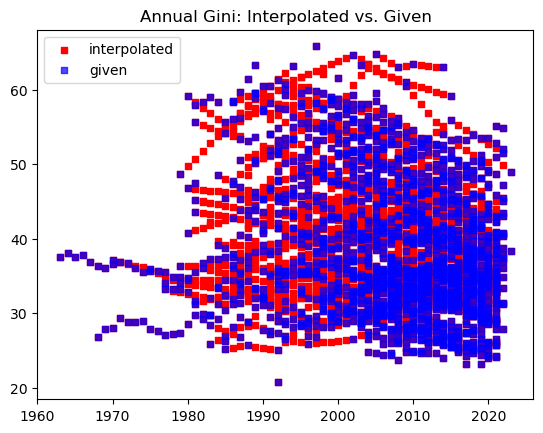

In [127]:
# visualize Gini_interpl versus Gini

plt.scatter(df_baseline['Year'], df_baseline['Gini_interpol'], marker='s', s=13, color='red', label='interpolated')
plt.scatter(df_baseline['Year'], df_baseline['Gini'], color='blue', marker='s', s=13, alpha=0.7, label='given')
#plt.scatter(df_baseline['Year'], df_baseline.where(df_baseline['Gini']==df_baseline['Gini_interpol'])['Gini_interpol'], color='black')
plt.title("Annual Gini: Interpolated vs. Given")
plt.legend()
plt.show()

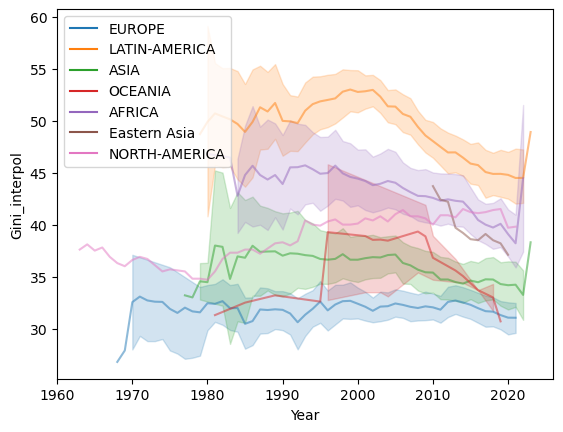

In [128]:
# hue = continent

plt.figure()
sns.lineplot(x='Year', y='Gini_interpol', data=df_baseline, hue='C3', legend=True, alpha=0.5)
plt.legend()
plt.show()

# break up countries into groups by color #hue values are missing

In [129]:
# Sparsity after target interpolation

df_baseline.isna().sum().sum() / df_baseline.size

0.8847433967390551

In [130]:
# countries with fewer than two p or d val

# apply to a country group within a lambda function:

def group_interpol(group, columns):
    for column in columns:
        if group[column].notnull().sum() < 2:
            group[column] = group[column].fillna(group[column].mean())
        elif group[column].notnull().sum() >= 2:
            group[column] = group[column].interpolate(method = 'slinear')
    return group


In [131]:
# apply function to selectively interpolate values

columns_list = df_baseline.loc[: , df_baseline.columns.str.startswith(('D', 'P', 'H'))].columns.to_list()

df_baseline = df_baseline.groupby('Country Code', group_keys=False).apply(lambda group: group_interpol(group, columns_list))



In [132]:
# OK now we are ready to identify rows where either Gini_interpol and d_p_h_cols are totally blank

columns_list = ['Gini_interpol'] + list(df_baseline.columns[df_baseline.columns.str.startswith('H')])

either_gini_h_cols_null = (
    df_baseline.groupby('Country Code', group_keys=False)
    .apply(lambda group: group[columns_list].isnull().all(axis=1))
)

totally_blank_rows = either_gini_h_cols_null[either_gini_h_cols_null].index
print(f"Number of totally blank rows dropped: {len(totally_blank_rows)} out of {len(df_merge1)}")


Number of totally blank rows dropped: 3559 out of 7884


In [133]:
# drop rows that have no Gini_interpol values or H columns values

df_baseline = df_baseline.drop(totally_blank_rows)

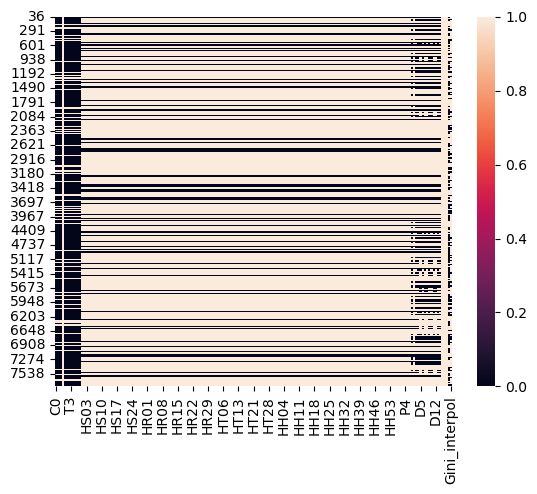

In [134]:
# Observe null values 
df_baseline = df_baseline.sort_values(by=['Country Code','Year'])
sns.heatmap(df_baseline.notnull())
plt.show()

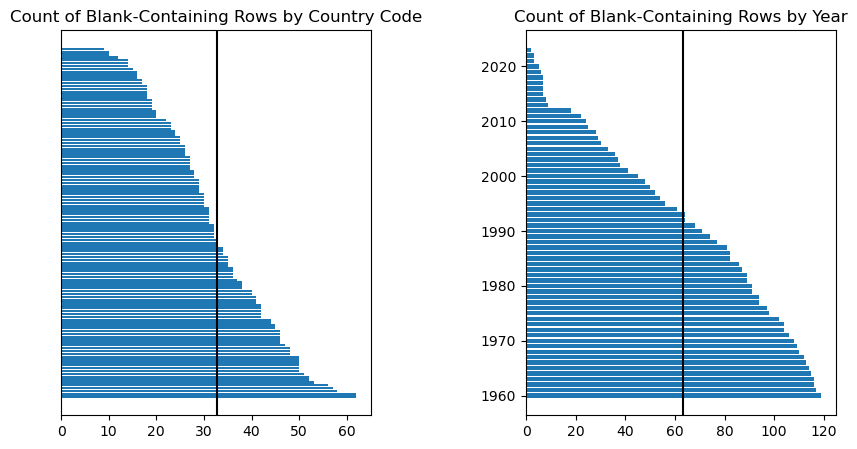

In [135]:
# observe distribution of null-containing rows
# .dropna() of these rows may enhance biases due to uneven distribution of missingness

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(wspace=0.5)
i = 0

for aggregator in ['Country Code', 'Year']:
    agg = (
        df_baseline.groupby(by=[aggregator], group_keys=False)
        .apply(lambda group: group.isnull().any(axis=1).sum(axis=0))
)
   
    ax[i].barh(agg.index, width = agg.sort_values(ascending=False))
    ax[0].set_yticks([])
    ax[i].set_title(f"Count of Blank-Containing Rows by {aggregator}")
    ax[i].axvline(agg.sum()/df_baseline[aggregator].nunique(), c='black')
    
    i+=1

plt.show()

In [136]:
# sparsity after interpolation and before back/forwardfill

df_baseline.isna().sum().sum()/df_baseline.size

0.2427682491550586

In [137]:
# Now that we have interpolated middle swath, back and forward fill remaining nulls

df_baseline = (
    df_baseline.groupby('Country Code', group_keys=False)
    .apply(lambda x: x.bfill().ffill())
)                                                                          

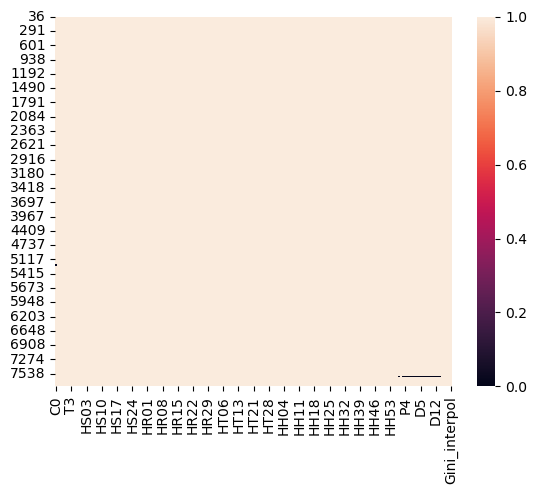

In [138]:
# check null values
sns.heatmap(df_baseline.notnull())
plt.show()

In [139]:
# fill all null values with column mean per country group

df_baseline = df_baseline.fillna(df_baseline.mean(numeric_only=True))

### Baseline Models

In [140]:
# add 'C1' (merge1 match of Country Code) and 'T1' (merge1 match of 'Year') to drop_cols_list
drop_cols_list.extend(['C1', 'T1'])
drop_cols_list
df_baseline = df_baseline.drop(drop_cols_list, axis=1)

In [141]:
# Shuffle values to shuffle countries

df_baseline = df_baseline.sample(frac=1)

In [142]:
# Sort the values by year again (countries now shuffled) to prepare for tscv

df_baseline = df_baseline.sort_values(by='Year')

In [143]:
# Inspect results of time-ordered shuffle. Countries appear shuffled.
df_baseline.head(5)

C3      HS01      HS02      HS03      HS04      HS05  \
6794         AFRICA  0.184261  0.127159  0.109405  0.107965  0.085893   
7306  NORTH-AMERICA  0.133270  0.280937  0.187643  0.172980  0.111087   
5642  LATIN-AMERICA  0.130945  0.124407  0.136229  0.129064  0.121272   
6795         AFRICA  0.176404  0.124694  0.110823  0.109185  0.088878   
7307  NORTH-AMERICA  0.137414  0.282421  0.186253  0.171116  0.109682   

          HS06      HS07      HS08      HS09  ...           D10       D11  \
6794  0.070058  0.058541  0.049904  0.034549  ...   1418.953019  0.495042   
7306  0.058994  0.026453  0.013148  0.007532  ...  29087.562270  0.875303   
5642  0.106852  0.087416  0.059651  0.042991  ...   5523.889400  0.727515   
6795  0.072959  0.060828  0.051191  0.035900  ...   1418.953019  0.495042   
7307  0.058548  0.026791  0.012783  0.007282  ...  29087.562270  0.875303   

           D12        D13           D14   Country Name  Country Code  Year  \
6794  11.22555   5.140753   2087.301569           Togo           TGO  1960   
7306  15.02286  13.087013  50300.030670  United States           USA  1960   
5642  11.78600   7.337380  15092.778400         Panama           PAN  1960   
6795  11.22555   5.140753   2087.301569           Togo           TGO  1961   
7307  15.02286  13.087013  50300.030670  United States           USA  1961   

      Gini  Gini_interpol  
6794  42.2           42.2  
7306  37.6           37.6  
5642  48.7           48.7  
6795  42.2           42.2  
7307  37.6           37.6  

[5 rows x 172 columns]

In [144]:
# Drop the target to split the data
y = df_baseline['Gini_interpol']
X = df_baseline.select_dtypes(include=['number']).drop(columns=['Gini_interpol', 'Gini'], axis=1)


In [145]:
# Set up time series split

tscv_baseline = TimeSeriesSplit(n_splits=3)
baseline_split = tscv_baseline.split(X)

In [146]:
# Write for loop that manages folds for time series split

for i, (train_index, test_index) in enumerate(baseline_split):
    
    print(f"Fold {i+1}")
        
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
    model_lr = LinearRegression()
    model_rf = RandomForestRegressor(random_state=21)
    
    model_lr.fit(X_train, y_train)
    model_rf.fit(X_train, y_train)
        
    lr_train_score = model_lr.score(X_train, y_train)
    rf_train_score = model_rf.score(X_train, y_train)
        
    lr_test_score = model_lr.score(X_test, y_test)
    rf_test_score = model_rf.score(X_test, y_test)

    print(f"Linear Regression Fold {i+1} Scores: train = {round(lr_train_score, 3)}, test = {round(lr_test_score, 2)}")
    print(f"Random Forest Fold {i+1} Scores: train = {round(rf_train_score, 3)}, test = {round(rf_test_score, 2)}")

Fold 1
Linear Regression Fold 1 Scores: train = 0.96, test = -3.21
Random Forest Fold 1 Scores: train = 0.996, test = 0.61
Fold 2
Linear Regression Fold 2 Scores: train = 0.837, test = 0.16
Random Forest Fold 2 Scores: train = 0.995, test = 0.74
Fold 3
Linear Regression Fold 3 Scores: train = 0.79, test = -1.79
Random Forest Fold 3 Scores: train = 0.996, test = 0.7


In [147]:
# Top Ten Feature Importances - Baseline Model

baseline_rf_importances = (
    pd.DataFrame(zip(X.columns, model_rf.feature_importances_), columns=['Code', 'Importance'])
    .sort_values(by='Importance', ascending= False)
)

with pd.option_context('display.max_colwidth', None):
    display(baseline_rf_importances.merge(code_dict[['Code', 'Description']], on='Code', how='left').head(10))


Code  Importance  \
0  HT05    0.234207   
1  HT08    0.165740   
2    D5    0.082793   
3    P6    0.037190   
4  HH21    0.031153   
5  HH38    0.029179   
6  HR11    0.028558   
7    P2    0.019008   
8  HH08    0.015743   
9  HS30    0.010988   

                                                                                 Description  
0  Proportion of households with nuclear, other family, and non family relationships to head  
1      Proportion of households with non nuclear family and non family relationships to head  
2                                                                      Gross Domestic income  
3                                                                       Life expectancy male  
4                             Proportion of 8-persons households of female-headed households  
5                                         Average household size of female-headed households  
6                                     Average number of Non relatives in 2 persons household  
7                                                                            Population 2021  
8                               Proportion of 6-persons households of male-headed households  
9                                         Average number of 80+ individuals in the household

### Baseline Models Summary

My fear was that interpolating so much data would "beg the question." In other words, introducting into the data the very patterns, which this analysis attempts to identify. 

Interesting that even though I introduced so much linearity into the data, the linear model was still not great. Random Forest continued to prevail. 

Other methods to be used for filling missing values. Rige and Lasso to be used to compare methods.


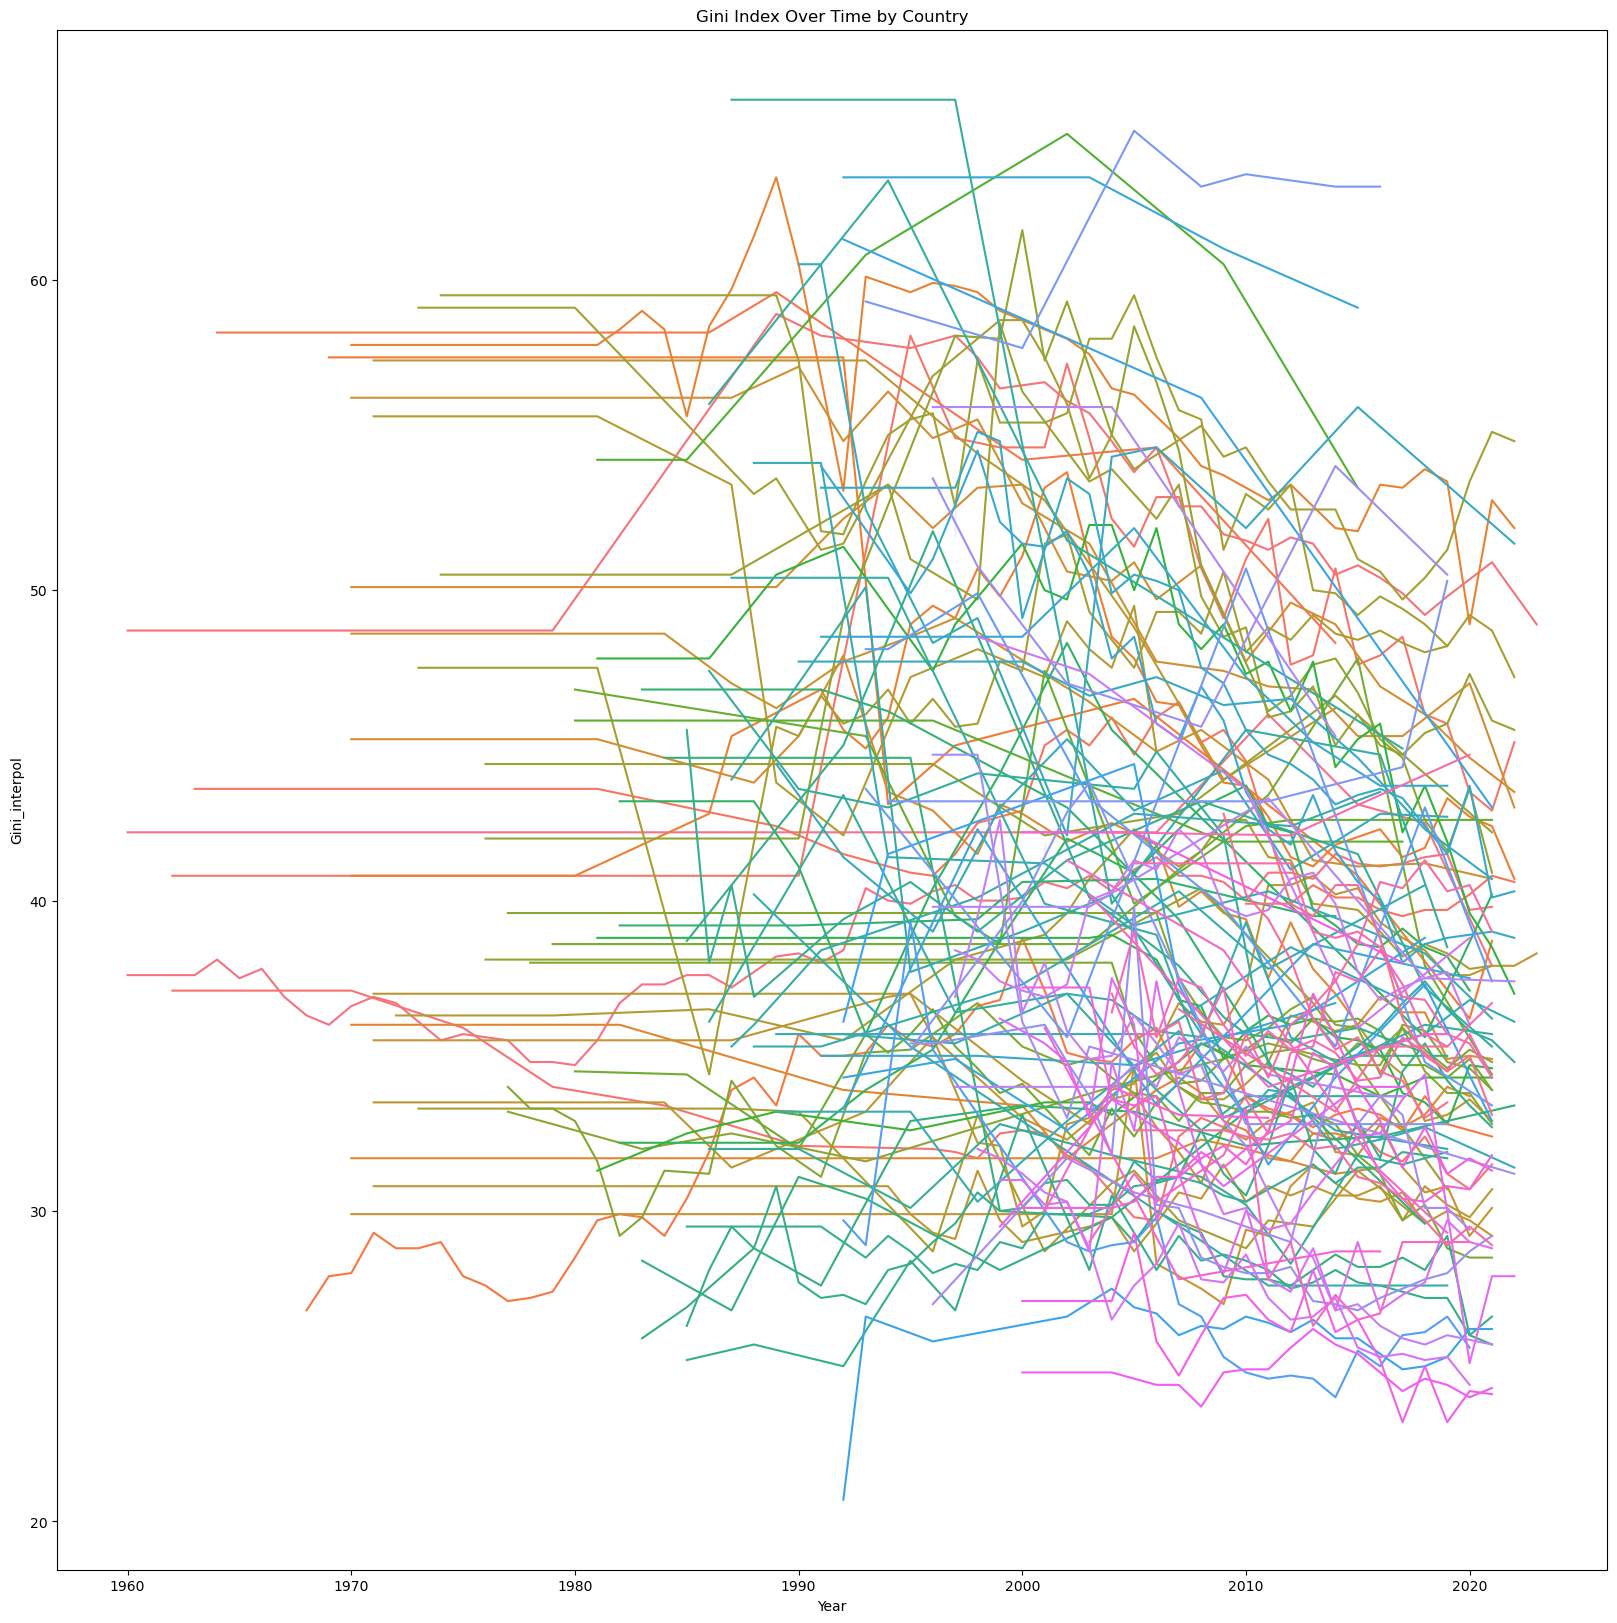

In [148]:
# Exploratory line plot of Gini index over the course of time
# Even with null values dropped, many countries lack data for reduced range
fig = plt.figure(figsize=(20,20))
sns.lineplot(x='Year', y='Gini_interpol', hue='Country Code', data=df_baseline, legend=False)
plt.title("Gini Index Over Time by Country")
plt.xlabel('Year')
plt.show()

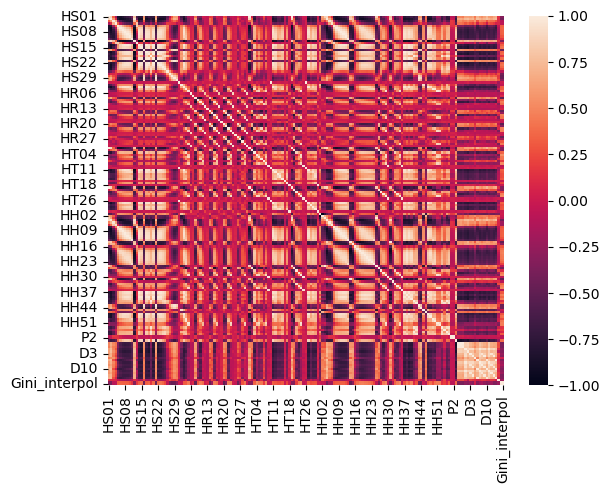

In [149]:
# Correlation matrix shows high collinearity for a number of features 
# After imputing missing years, it may be a good idea to try decomposition methods

correlation_matrix = df_baseline.corr(numeric_only=True)
sns.heatmap(correlation_matrix)
plt.show()

## B: Iterative Imputation - Domain and Algorithmic

In Section III-A  I handled missing data using interpolation and backfilling. Sparsity was reduced from 88% to 24% (prior to back and forward filling). A total of 3559 out of 7884 were dropped due to lack of data. Baseline models had OK performance using Random Forest.

In this section, we revert back to df_merge1, and redo missing data handling. Prior to handling missing data, new data is brought in from 3 sources: United Nations "Most Used" dataset, United Nations Population Division, and United Nations Development Programme.

I use a combination of sourcing values from these external domain sources, followed by iterative imputation. Iterative Imputer is deployed in what I term a "plaid pattern." Both horizontal (row) and vertical (column) subsets are sequestered and imputed separately, to avoid "the curse of dimensionality." Because the data admits of vertical groupings organically, choosing vertical groups was easy and uncontroversial. 

### Table 2: United Nations Most Used df_econ

United Nations Population Data will be used to fill missing values for years missing from CoResidence database.

Specfically the following features are brought in:
1. 'Fertility Rate'
2. 'Life Expectancy'
3. 'Life expectancy male'
4. 'Life expectancy female'
6. 'Population'

These features are duplicates of features in CoResidence, however, the UN database includes data for years that are missing from the CoResidence database. Using these added features as a supplement, I will conduct the following approach:

1) Manually inspect and validate features for approximate identity with CoResidence
2) Fill in gaps in CoResidence using imported features from UN Most Used


In [150]:
# Read in supplemental data from UN to fill in missing rows for imputation
# Skip rows 1-15 as these contain a UN graphic header
# Index column should be 'Index'
skip_rows = list(range(0,16))

df_econ = pd.read_excel('./WPP2024_GEN_F01_DEMOGRAPHIC_INDICATORS_COMPACT.xlsx',
                       skiprows = skip_rows, index_col='Index')




In [151]:
# In this project, I are interested in country level data only, 'Type' column should be filtered
df_econ = df_econ[(df_econ['Type']=='Country/Area')]

In [152]:
df_econ.head()

Variant Region, subregion, country or area * Notes  Location code  \
Index                                                                        
2595   Estimates                              Burundi   NaN            108   
2596   Estimates                              Burundi   NaN            108   
2597   Estimates                              Burundi   NaN            108   
2598   Estimates                              Burundi   NaN            108   
2599   Estimates                              Burundi   NaN            108   

      ISO3 Alpha-code ISO2 Alpha-code  SDMX code**          Type  Parent code  \
Index                                                                           
2595              BDI              BI        108.0  Country/Area          910   
2596              BDI              BI        108.0  Country/Area          910   
2597              BDI              BI        108.0  Country/Area          910   
2598              BDI              BI        108.0  Country/Area          910   
2599              BDI              BI        108.0  Country/Area          910   

         Year  ...  \
Index          ...   
2595   1950.0  ...   
2596   1951.0  ...   
2597   1952.0  ...   
2598   1953.0  ...   
2599   1954.0  ...   

      Male Mortality before Age 60 (deaths under age 60 per 1,000 male live births)  \
Index                                                                                 
2595                                             639.661                              
2596                                             636.943                              
2597                                              634.07                              
2598                                             630.348                              
2599                                             627.641                              

      Female Mortality before Age 60 (deaths under age 60 per 1,000 female live births)  \
Index                                                                                     
2595                                             590.518                                  
2596                                             585.391                                  
2597                                             581.696                                  
2598                                             578.471                                  
2599                                             575.264                                  

      Mortality between Age 15 and 50, both sexes (deaths under age 50 per 1,000 alive at age 15)  \
Index                                                                                               
2595                                             290.807                                            
2596                                             288.479                                            
2597                                             286.669                                            
2598                                             284.712                                            
2599                                             283.199                                            

      Male Mortality between Age 15 and 50 (deaths under age 50 per 1,000 males alive at age 15)  \
Index                                                                                              
2595                                             309.954                                           
2596                                             308.601                                           
2597                                              307.12                                           
2598                                             304.927                                           
2599                                              303.61                                           

      Female Mortality between Age 15 and 50 (deaths under age 50 per 1,000 female

In [153]:
# Inspect country codes in df_merge1 (left table) that are not in df_econ (right table)
unmatched_left = [ccode for ccode in list(df_merge1['Country Code'].unique()) if ccode not in list(df_econ['ISO3 Alpha-code'].unique())]
len(unmatched_left)


0

In [154]:
# Country codes in df_econ (right table) not in df_merge1

unmatched_right = [ccode for ccode in list(df_econ['ISO3 Alpha-code'].unique()) if ccode not in list(df_merge1['Country Code'].unique())]

len(unmatched_right)

114

In [155]:
# Examine countries in left table, unmatched in right

df_merge1.loc[df_merge1['Country Code'].isin(unmatched_left), 'Country Name'].unique()



array([], dtype=object)

In [156]:
# Examine countries in right table (df_econ) not in left table (df_merge1)
df_econ.loc[df_econ['ISO3 Alpha-code'].isin(unmatched_right),'Region, subregion, country or area *'].unique()

#df_econ.head()

array(['Djibouti', 'Eritrea', 'Mayotte', 'Réunion', 'Seychelles',
       'Somalia', 'South Sudan', 'Angola', 'Congo', 'Equatorial Guinea',
       'Sao Tome and Principe', 'Libya', 'Sudan', 'Tunisia',
       'Western Sahara', 'Eswatini', 'Cabo Verde', 'Saint Helena',
       'Turkmenistan', 'China, Hong Kong SAR', 'China, Macao SAR',
       'China, Taiwan Province of China',
       "Dem. People's Republic of Korea", 'Japan', 'Afghanistan',
       'Bhutan', 'Sri Lanka', 'Brunei Darussalam', 'Cambodia', 'Myanmar',
       'Singapore', 'Azerbaijan', 'Bahrain', 'Georgia', 'Iraq', 'Kuwait',
       'Lebanon', 'Oman', 'Qatar', 'Saudi Arabia', 'Syrian Arab Republic',
       'Türkiye', 'United Arab Emirates', 'Denmark', 'Faroe Islands',
       'Finland', 'Guernsey', 'Iceland', 'Isle of Man', 'Jersey',
       'Norway', 'Sweden', 'Andorra', 'Gibraltar', 'Holy See', 'Malta',
       'San Marino', 'Liechtenstein', 'Monaco', 'Anguilla',
       'Antigua and Barbuda', 'Aruba', 'Bahamas', 'Barbados',
     

In [157]:
# Fuzzy word matching: prepare column names list

cores_vals = df_merge1.columns[df_merge1.columns.str.startswith(('D','P'))]
print(cores_vals)

cores_cols = []
for item in cores_vals:
    cores_cols.append(code_dict.loc[code_dict['Code']==item, 'Description'].item())
print(cores_cols)


Index(['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6',
       'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14'],
      dtype='object')
['Population', 'Population 2021', 'Fertility rate', 'Life expectancy', 'Life expectancy female', 'Life expectancy male', 'Human development index', 'Human development index 2021', 'Expected years of schooling', 'Mean years of schooling', 'Gross Domestic income', 'Gross National Income per capita', 'Human development index female', 'Expected years of schooling female', 'Mean years of schooling female', 'Gross National Income per capita female', 'Human development index male', 'Expected years of schooling male', 'Mean years of schooling male', 'Gross National Income per capita male']


In [158]:
# Use fuzz to find matches across column names


econ_cols = df_econ.columns.astype('str').tolist()

matches = [(col, process.extractOne(col, econ_cols, scorer=fuzz.token_set_ratio)) for col in cores_cols]

matches = pd.DataFrame(matches, columns=['CoRes', 'UN Econ'])

matches[['UN Econ','Match Score']] = matches['UN Econ'].apply(lambda x: pd.Series([x[0], x[1]]))

matches = matches.merge(code_dict[['Code','Description']], left_on='CoRes', right_on='Description', how='left')

matches = matches.sort_values(by='Match Score', ascending=False)

with pd.option_context('display.max_colwidth', None):
    display(matches.head(5))


CoRes                                        UN Econ  \
0              Population  Total Population, as of 1 January (thousands)   
2          Fertility rate   Total Fertility Rate (live births per woman)   
3         Life expectancy   Life Expectancy at Birth, both sexes (years)   
4  Life expectancy female        Female Life Expectancy at Birth (years)   
5    Life expectancy male          Male Life Expectancy at Birth (years)   

   Match Score Code             Description  
0          100   P1              Population  
2          100   P3          Fertility rate  
3          100   P4         Life expectancy  
4          100   P5  Life expectancy female  
5          100   P6    Life expectancy male

UN Most-Used table contains the following five features, which will allow us to fill in some missing values in our CoResidence table:


1) Population (P1)
2) Fertility rate (P3)
3) Life expectancy (P4)
4) Life expectancy female (P5)
5) Life expectancy male (P6)

I still need to source the following features, to fill in missing values, before I can successfully impute CoRes values for missing years:

1) Years of schooling
2) Human Development Index
3) Gross National Income

Then I will group impute by country, and by core feature sub-family

I will then test all of this fancy imputing against a dirty simple imputer with models

Finally, I will test boosting and aggregating.

In [159]:
# extract from df_econ only the values with matches

#df_econ[matches['UN Econ'][0:5].to_list()]
df_econ.head()


Variant Region, subregion, country or area * Notes  Location code  \
Index                                                                        
2595   Estimates                              Burundi   NaN            108   
2596   Estimates                              Burundi   NaN            108   
2597   Estimates                              Burundi   NaN            108   
2598   Estimates                              Burundi   NaN            108   
2599   Estimates                              Burundi   NaN            108   

      ISO3 Alpha-code ISO2 Alpha-code  SDMX code**          Type  Parent code  \
Index                                                                           
2595              BDI              BI        108.0  Country/Area          910   
2596              BDI              BI        108.0  Country/Area          910   
2597              BDI              BI        108.0  Country/Area          910   
2598              BDI              BI        108.0  Country/Area          910   
2599              BDI              BI        108.0  Country/Area          910   

         Year  ...  \
Index          ...   
2595   1950.0  ...   
2596   1951.0  ...   
2597   1952.0  ...   
2598   1953.0  ...   
2599   1954.0  ...   

      Male Mortality before Age 60 (deaths under age 60 per 1,000 male live births)  \
Index                                                                                 
2595                                             639.661                              
2596                                             636.943                              
2597                                              634.07                              
2598                                             630.348                              
2599                                             627.641                              

      Female Mortality before Age 60 (deaths under age 60 per 1,000 female live births)  \
Index                                                                                     
2595                                             590.518                                  
2596                                             585.391                                  
2597                                             581.696                                  
2598                                             578.471                                  
2599                                             575.264                                  

      Mortality between Age 15 and 50, both sexes (deaths under age 50 per 1,000 alive at age 15)  \
Index                                                                                               
2595                                             290.807                                            
2596                                             288.479                                            
2597                                             286.669                                            
2598                                             284.712                                            
2599                                             283.199                                            

      Male Mortality between Age 15 and 50 (deaths under age 50 per 1,000 males alive at age 15)  \
Index                                                                                              
2595                                             309.954                                           
2596                                             308.601                                           
2597                                              307.12                                           
2598                                             304.927                                           
2599                                              303.61                                           

      Female Mortality between Age 15 and 50 (deaths under age 50 per 1,000 female

In [160]:
# Dictionary to update column names of df_econ for readability and to prepare for smoother join with coresidence data
# Renaming features from right table (US Most Used)

mapper = dict(zip(matches['UN Econ'][0:5], matches['Code'][0:5]+"_"))

mapper['ISO3 Alpha-code'] = 'Country Code'
mapper['Year'] = 'Year_'

mapper

{'Total Population, as of 1 January (thousands)': 'P1_',
 'Total Fertility Rate (live births per woman)': 'P3_',
 'Life Expectancy at Birth, both sexes (years)': 'P4_',
 'Female Life Expectancy at Birth (years)': 'P5_',
 'Male Life Expectancy at Birth (years)': 'P6_',
 'ISO3 Alpha-code': 'Country Code',
 'Year': 'Year_'}

In [161]:
# Update column names using mapper for ease of viewing and manipulation

df_econ = df_econ.rename(mapper, axis=1)

In [162]:
# harvest a column a subset of the df_econ data using values from name mapper

df_econ = df_econ[mapper.values()]

### MERGE 2: UN "Most Used"

In [163]:
# Merge 2

df_merge2 = df_merge1.merge(df_econ, left_on=['Country Code','Year'], right_on=['Country Code','Year_'], how='left')

In [164]:
# Inspect merge results wrt to columns of interest. How many new values do we gain?

df_merge2[['P1', 'P1_', 'P3', 'P3_', 'P4', 'P4_', 'P5', 'P5_', 'P6', "P6_"]].count()

P1      736
P1_    7884
P3      736
P3_    7884
P4      736
P4_    7884
P5      736
P5_    7884
P6      736
P6_    7884
dtype: int64

In [165]:
# visually inspect imported columns side-by-side

no_nulls = (df_merge2[['P1', 'P1_', 'P3', 'P3_', 'P4', 'P4_', 'P5', 'P5_', 'P6', "P6_"]]
.loc[df_merge2[['P1', 'P1_', 'P3', 'P3_', 'P4', 'P4_', 'P5', 'P5_', 'P6', "P6_"]].notnull().all(axis=1)])

no_nulls.head()

P1        P1_      P3    P3_    P4     P4_    P5     P5_    P6  \
48   2951690.0   3008.329  1.6480  1.616  77.7  78.248  80.4  81.076  75.2   
57   2879361.0   2899.839  1.4909  1.486  79.0    78.9  81.5  80.795  76.9   
74  23842804.0  23689.611  3.0883  3.085  65.6  65.647  69.7  69.564  62.0   
84  28024808.0   27788.76  3.3013  3.301  68.6  68.576  72.5  72.047  64.8   
95  33105766.0  32997.086  3.0119  3.012  72.3   72.02  75.6  75.344  69.0   

       P6_  
48  75.531  
57  76.997  
74  62.165  
84  65.282  
95  68.681

In [166]:
# create a list of column pairings to preparte to  old columns with new columns

col_pairs = []

for column in no_nulls.columns:
    if column + "_" in no_nulls.columns:
        col_pairs.append([column, column+"_"])


In [167]:
df_merge2['P1_']

0        1621.796
1        1676.978
2        1720.603
3        1766.863
4        1815.707
          ...    
7879    15148.526
7880    15394.209
7881    15659.568
7882    15934.852
7883    16203.259
Name: P1_, Length: 7884, dtype: object

In [168]:
cols_to_drop = []

for old_col, new_col in col_pairs:
    #print(old_col, new_col)
    df_merge2.loc[df_merge2[old_col].isnull(), old_col] = df_merge2[new_col]
    cols_to_drop.append(new_col)
    #print(cols_to_drop)
    
df_merge2 = df_merge2.drop(cols_to_drop, axis=1)

In [169]:
# Verify values were filled

df_merge2[['P1', 'P3', 'P4', 'P5', 'P6']].count()

P1    7884
P3    7884
P4    7884
P5    7884
P6    7884
dtype: int64

### Table 3: UNDP Development Reports

I will source the following columns from the UNDP HDI composite indices

1) mys - mean years of schooling
2) mys_m - mean years of schooling male
3) mys_f - "" female
4) eys - expected years of schooling
5) eys_m - "" male
6) eys_f - "" female
7) gnipc - gross national income per capita
8) gni_pc_m - "" male
9) gni_pc_f - "" female
10) hdi - human development index

* potential duplicates of UN Most Used

https://hdr.undp.org/data-center/documentation-and-downloads

In [170]:
# Read in UNDO
file = './HDR23-24_Composite_indices_complete_time_series.csv'
chunksize = 1000

chunks = []

for chunk in pd.read_csv(file, chunksize=chunksize, encoding_errors='replace'):
        #print(chunk.head())
    chunks.append(chunk)


In [171]:
# Concatenate chunks into df
df_undp = pd.concat(chunks, ignore_index=True)

In [172]:
# # Subset UNDP data to desired columns

df_undp = df_undp.loc[:, (df_undp.columns.str.startswith(('mys', 'gni', 'eys','gdi','hdi'))) | (df_undp.columns=='iso3')]

df_undp.head()

iso3    hdicode  hdi_rank_2022  hdi_1990  hdi_1991  hdi_1992  hdi_1993  \
0  AFG        Low          182.0     0.284     0.292     0.299     0.307   
1  ALB       High           74.0     0.649     0.632     0.616     0.618   
2  DZA       High           93.0     0.593     0.596     0.601     0.602   
3  AND  Very High           35.0       NaN       NaN       NaN       NaN   
4  AGO     Medium          150.0       NaN       NaN       NaN       NaN   

   hdi_1994  hdi_1995  hdi_1996  ...  gni_pc_m_2013  gni_pc_m_2014  \
0     0.300     0.318     0.326  ...    3645.424062    3669.659016   
1     0.623     0.632     0.644  ...   14198.930400   14712.782440   
2     0.603     0.607     0.618  ...   18360.185310   18814.559940   
3       NaN       NaN       NaN  ...            NaN            NaN   
4       NaN       NaN       NaN  ...    8804.685855    9429.575348   

   gni_pc_m_2015  gni_pc_m_2016  gni_pc_m_2017  gni_pc_m_2018  gni_pc_m_2019  \
0    3372.919210    3373.450057    3416.103907    3373.607531    3456.606979   
1   14109.622100   14844.565910   15339.767550   15686.449040   15676.463990   
2   18875.767780   19229.537090   18955.501270   18654.742490   18491.950240   
3            NaN            NaN            NaN            NaN            NaN   
4    9227.254116    8439.056683    7874.582331    7212.947316    7228.519455   

   gni_pc_m_2020  gni_pc_m_2021  gni_pc_m_2022  
0    3275.057369    2430.862265    2256.217507  
1   14983.695140   16252.408730   17398.003690  
2   17305.912600   17604.030850   17858.790780  
3            NaN            NaN            NaN  
4    6168.069689    6248.437323    5973.845631  

[5 rows x 433 columns]

In [173]:
# Drop unused columns

df_undp = df_undp.drop(columns = ['hdicode','hdi_rank_2022'])

In [174]:
# Melt vertical

df_undp = pd.melt(df_undp, id_vars=['iso3'], var_name='Year', value_name='Value')

df_undp.head()

iso3      Year  Value
0  AFG  hdi_1990  0.284
1  ALB  hdi_1990  0.649
2  DZA  hdi_1990  0.593
3  AND  hdi_1990    NaN
4  AGO  hdi_1990    NaN

In [175]:
# Split the year and value name

df_undp[['Metric','Year']] = df_undp['Year'].str.extract(r'(.+?)(\d{4})')

# remove the trailing underscore from the metric name
df_undp['Metric'] = df_undp['Metric'].str.rstrip('_')

In [176]:
df_undp

iso3  Year         Value    Metric
0            AFG  1990      0.284000       hdi
1            ALB  1990      0.649000       hdi
2            DZA  1990      0.593000       hdi
3            AND  1990           NaN       hdi
4            AGO  1990           NaN       hdi
...          ...   ...           ...       ...
88575    ZZG.ECA  2022  26631.487420  gni_pc_m
88576    ZZH.LAC  2022  18822.661050  gni_pc_m
88577     ZZI.SA  2022  10808.315130  gni_pc_m
88578    ZZJ.SSA  2022   4388.270245  gni_pc_m
88579  ZZK.WORLD  2022  22034.766330  gni_pc_m

[88580 rows x 4 columns]

In [177]:
# Now unmelt (pivot) back to horizontal form

df_undp = df_undp.pivot(index=['iso3','Year'], columns='Metric', values='Value').reset_index()

In [178]:
# Examine what the null values per year look like in population

df_undp.sort_values(by=['iso3','Year']).head(5)

Metric iso3  Year       eys     eys_f     eys_m  gdi  gdi_group  gni_pc_f  \
0       AFG  1990  2.936460  2.117230  4.532768  NaN        NaN       NaN   
1       AFG  1991  3.228456  2.246242  4.768261  NaN        NaN       NaN   
2       AFG  1992  3.520452  2.383115  5.015989  NaN        NaN       NaN   
3       AFG  1993  3.812448  2.528328  5.276587  NaN        NaN       NaN   
4       AFG  1994  4.104445  2.682390  5.550723  NaN        NaN       NaN   

Metric  gni_pc_m        gnipc    hdi  hdi_f  hdi_m       mys     mys_f  \
0            NaN  3115.670448  0.284    NaN    NaN  0.871962  0.201659   
1            NaN  2817.304736  0.292    NaN    NaN  0.915267  0.218944   
2            NaN  2474.681985  0.299    NaN    NaN  0.958573  0.236229   
3            NaN  1723.019763  0.307    NaN    NaN  1.001878  0.253514   
4            NaN  1202.010488  0.300    NaN    NaN  1.045184  0.270800   

Metric     mys_m  
0       1.493952  
1       1.578809  
2       1.663665  
3       1.748522  
4       1.833378

In [179]:
# Drop iso codes with >3 letters, as these represent regions rather than countries

drop_index = df_undp[df_undp['iso3'].apply(lambda x: len(x)>3)].index

df_undp = df_undp.drop(drop_index)

In [180]:
# Inspect iso3 df_undp vs. Country Code in df_merge1 to prepare for merge

mismatched_left = [code for code in set(df_merge2['Country Code']) if code not in set(df_undp['iso3'])]

mismatched_left

# Some codes in CoRes data have no match in undp data
# 'XKX' Kosovo not in undp data

['XKX']

In [181]:
# Inspect 'iso3' in df_undp vs. 'Country Code' in df_merge1 to prepare for merge
# Codes in right table not in left table

mismatched_right = [code for code in df_undp['iso3'].unique() if code not in df_merge2['Country Code'].unique()]

len(mismatched_right)


73

In [182]:
# import metadata table

metadata = pd.read_excel('./HDR23-24_Composite_indices_metadata.xlsx')


In [183]:
# look up full names for columns in metadata table

result = [[column, metadata.loc[metadata['Short name']==column, 'Full name'].values[0]]
          if not metadata.loc[metadata['Short name']==column, 'Full name'].empty
          else [column, None]
          for column in df_undp.columns]

result = pd.DataFrame(result, columns = ['Short Name', 'Full Name'])

In [184]:
# fuzzy matching

matches = [(col, process.extractOne(col, result['Full Name'])) for col in code_dict['Description']]

matches = pd.DataFrame(matches, columns=['Description','Match'])
matches['Code'] = code_dict.loc[code_dict['Description'].isin(matches['Description']), 'Code']
matches[['Full Name', 'Score']] = matches['Match'].apply(lambda x: pd.Series([x[0], x[1]]))
matches.drop('Match', axis=1).sort_values(by='Score', ascending=False).head(12)

Description Code  \
181    Gross National Income per capita male  D14   
176           Mean years of schooling female   D9   
170              Expected years of schooling   D3   
171                  Mean years of schooling   D4   
173         Gross National Income per capita   D6   
175       Expected years of schooling female   D8   
168                  Human development index   D1   
177  Gross National Income per capita female  D10   
180             Mean years of schooling male  D13   
179         Expected years of schooling male  D12   
178             Human development index male  D11   
174           Human development index female   D7   

                                             Full Name  Score  
181  Gross National Income Per Capita, male (2017 P...     95  
176                    Mean Years of Schooling (years)     95  
170                Expected Years of Schooling (years)     95  
171                    Mean Years of Schooling (years)     95  
173       Gross National Income Per Capita (2017 PPP$)     95  
175                Expected Years of Schooling (years)     95  
168                    Human Development Index (value)     95  
177  Gross National Income Per Capita, female (2017...     95  
180                    Mean Years of Schooling (years)     95  
179                Expected Years of Schooling (years)     95  
178                    Human Development Index (value)     93  
174                    Human Development Index (value)     90

In [185]:
# rename df_undp columns prior to merge
# rather than importing metadata table and parsing through fuzz match, a manual mapper is faster in this case

mapper = {'mys':'Mean years of schooling', 
          'mys_m': 'Mean years of schooling male',
          'mys_f': 'Mean years of schooling female',
          'eys': 'Expected years of schooling',
          'eys_f': 'Expected years of schooling female',
          'eys_m': 'Expected years of schooling male',
          'gnipc': 'Gross National Income per capita', 
          'gnipc_m': 'Gross National Income per capita male',
          'gnipc_f': 'Gross National Income per capita female',
          'hdi': 'Human development index',
          'hdi_m' : 'Human development index male',
          'hdi_f' : 'Human development index female'
             }

mapper_conversion = {key:code_dict.loc[code_dict['Description']== value, 'Code'].values[0]+"_" for key,value in mapper.items()}

In [186]:
# rename columns to prepare for merge 3

df_undp = df_undp.rename(columns=mapper_conversion)

df_undp = df_undp.rename(columns=({'gni_pc_f':'D10_',
               'gni_pc_m':'D14_'}))

df_undp.columns

Index(['iso3', 'Year', 'D3_', 'D8_', 'D12_', 'gdi', 'gdi_group', 'D10_',
       'D14_', 'D6_', 'D1_', 'D7_', 'D11_', 'D4_', 'D9_', 'D13_'],
      dtype='object', name='Metric')

In [187]:
# update merge condition year in preparation for merge
df_undp['Year'] = df_undp['Year'].astype('int64')

### MERGE 3: Coresidence, Gini, UN Most Used with UNDP

Recall:

- df_merge1 - Outer join of CoResidence and Gini with countries dropped that have less than two Gini or H col values
- df_merge2 - Left join of merge1 and df_econ
- df_merge3 - Will be a left join of df_merge2 and df_undp


In [188]:
# Merge df_merge3 with df_undp, left on 'Country Code', 'Year', right on 'iso3' and 'Year'

df_merge3 = df_merge2.merge(df_undp, left_on=['Country Code', 'Year'], right_on=['iso3', 'Year'], how='left')

In [189]:
# Now that I have merged all necessary tables, comb for missing values, interpolate, impute, etc.
df_merge3.shape

(7884, 198)

In [190]:
# examine columns imported from df_undp

d_cols = []

for column in df_merge3.columns:
    if column + "_" in df_merge3.columns:
        d_cols.append([column, column + "_"])
        
d_cols_flat = [item for sublist in d_cols for item in sublist]


In [191]:
# visually inspect D columns for successful imputation

df_merge3.loc[df_merge3[d_cols_flat].notnull().all(axis=1), d_cols_flat]

# values look approximately equal across partner columns. 

D1    D1_         D3        D3_         D4        D4_            D6  \
48    0.736  0.747  12.124880  13.175100   9.276760   9.276760   9962.442236   
57    0.802  0.796  14.816130  15.325940  10.910692   9.976700  12802.148310   
95    0.730  0.731  13.235740  13.352440   8.192950   8.192950  14803.998880   
105   0.784  0.785  16.169960  16.305780   8.867060   8.867060  17153.297700   
124   0.840  0.841  17.874870  18.361160  11.147269  11.144080  19178.331840   
...     ...    ...        ...        ...        ...        ...           ...   
7859  0.457  0.431  10.255620  10.254440   6.392959   6.392959   2664.181190   
7865  0.448  0.420  10.251804  10.434010   7.158781   7.158781   1973.994783   
7870  0.512  0.481  11.108115  10.797110   7.666366   7.666366   2817.502775   
7872  0.557  0.522  11.450640  10.942350   7.869400   7.869400   3618.629526   
7875  0.582  0.544  11.602372  10.867628   8.228876   8.389050   3638.532892   

               D6_        D7       D7_  ...       D11      D11_        D12  \
48     9962.428183  0.715264  0.726797  ...  0.753432  0.764882  11.906640   
57    12802.175940  0.797816  0.782182  ...  0.805385  0.809306  14.179940   
95    14790.845360  0.719238  0.715120  ...  0.734132  0.737121  12.525383   
105   17058.178000  0.777137  0.778691  ...  0.785177  0.784924  15.507800   
124   19183.115250  0.831993  0.832788  ...  0.832784  0.833979  16.551460   
...            ...       ...       ...  ...       ...       ...        ...   
7859   1561.673459  0.432812  0.402897  ...  0.481973  0.459333  10.625300   
7865   1132.816185  0.418780  0.389779  ...  0.476860  0.449479  10.555666   
7870   1659.431490  0.491970  0.459884  ...  0.531513  0.501781  11.383433   
7872   2078.953775  0.540584  0.497026  ...  0.571984  0.544773  11.714540   
7875   2040.150247  0.564617  0.523709  ...  0.599580  0.565944  11.811748   

           D12_        D13       D13_           D14          D14_  Year  \
48    13.143930   9.836990   9.836990  12720.559540  12379.472420  2008   
57    15.113010  10.721275  10.304840  15442.824030  15339.767550  2017   
95    12.570447   8.302910   8.302910  19962.775080  21076.188360  1991   
105   15.424810   8.742920   8.742920  22505.636970  22779.669800  2001   
124   16.758520  10.906023  10.857980  24077.505160  23983.331150  2020   
...         ...        ...        ...           ...           ...   ...   
7859  11.027320   7.324286   7.324286   3291.783286   1935.693926  1999   
7865  10.976756   7.934024   7.934024   2371.978568   1342.485865  2005   
7870  11.315223   8.174664   8.174664   3278.955279   1903.015042  2010   
7872  11.450610   8.270920   8.270920   4193.823396   2625.321877  2012   
7875  11.292782   8.881024   9.265350   4175.945934   2325.524620  2015   

       Year_  
48    2008.0  
57    2017.0  
95    1991.0  
105   2001.0  
124   2020.0  
...      ...  
7859  1999.0  
7865  2005.0  
7870  2010.0  
7872  2012.0  
7875  2015.0  

[555 rows x 26 columns]

In [192]:
# remove 'Year' column from d_cols list in preparation to overwrite

d_cols.pop(-1)


['Year', 'Year_']

In [193]:
df_merge3[d_cols_flat].count()

D1        661
D1_      3856
D3        673
D3_      3994
D4        663
D4_      3900
D6        673
D6_      4003
D7        641
D7_      3285
D8        652
D8_      3774
D9        663
D9_      3890
D10       673
D10_     3482
D11       641
D11_     3285
D12       652
D12_     3774
D13       663
D13_     3890
D14       673
D14_     3482
Year     7884
Year_    7884
dtype: int64

In [194]:
# wherever D is null, fillna with D_

new_cols = []
old_cols = []

for col_pair in d_cols:
    old = col_pair[0] 
    new = col_pair[1]
    df_merge3.loc[df_merge3[old].isnull(), old] = df_merge3[new]
    new_cols.append(new)
    old_cols.append(old)


In [195]:
# drop the columns from which we sourced information (new_cols)
df_merge3 = df_merge3.drop(new_cols, axis=1)

In [196]:
# inspect remaining columns for non-null counts

df_merge3[old_cols].count()

D1     3898
D3     4035
D4     3942
D6     4044
D7     3371
D8     3819
D9     3932
D10    3570
D11    3371
D12    3819
D13    3932
D14    3570
dtype: int64

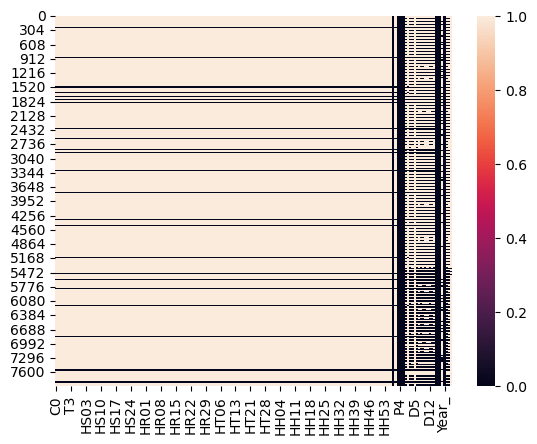

<Figure size 640x480 with 0 Axes>

In [197]:
# Observe nulls. Most rows are null, no interpolation has occurred yet
df_merge3 = df_merge3.sort_values(by=['Country Code', 'Year'])
sns.heatmap(df_merge3.isnull())
plt.show()
plt.clf()


In [198]:
# name of
code_dict.loc[code_dict['Code'].isin([col_pair[0] for col_pair in d_cols]), ['Code','Description']]


Code                              Description
168   D1                  Human development index
170   D3              Expected years of schooling
171   D4                  Mean years of schooling
173   D6         Gross National Income per capita
174   D7           Human development index female
175   D8       Expected years of schooling female
176   D9           Mean years of schooling female
177  D10  Gross National Income per capita female
178  D11             Human development index male
179  D12         Expected years of schooling male
180  D13             Mean years of schooling male
181  D14    Gross National Income per capita male

Summary: 

A substantial amount of nulls have been eliminated in the following columns via importing from external data sources:

1. Population (P1)
2. Fertility rate (P3)
3. Life expectancy (P4)
4. Life expectancy female (P5)
5. Life expectancy male (P6)
6. Human development index (D1)
7. Expected years of schooling (D3)
8. Mean years of schooling (D4)
9. Gross National Income per capita (D6)
9. Human development index female (D7)
10. Expected years of schooling female (D8)
11. Mean years of schooling female (D9)
12. Gross National Income per capita female (D10)
12. Human development index male (D11)
13. Expected years of schooling male (D12)
14. Mean years of schooling male (D13)
15. Gross National Income per capita male (D14)



### Iterative Imputer (df_mstr)

- df_mstr is created to store the unchanged the results of all three merges, with redundant columns created by merges or brought along through merges dropped. The following columns are dropped from df_mstr:
    - 'Year_' (duplicate of 'Year' created in merge)
    - 'iso3' (duplicate of 'Country Code' created in merge)
    - 'gdi' (Gross Domestic Income not needed for analysis)
    - 'gdi_group' (GDI ranking not neede for analysis)
    - ['C0', 'C1', 'C2', 'C3', 'C4', 'T1', 'T2', 'T3', 'T5', 'T10', 'S1', 'S2'] (original CoRes columns not needed)

- Recall that df_merge1 involved deleting any countries that did not have at least two rows of core feature observations, two rows of Gini observation, and at least an 8-year timespan between Gini values. This carries through to df_mstr

- df_imputed is created to store modified values created during imputation with Iterative Imputer. For ease of reference, column names have not been changed versus the original table. To view native observation values, refer to df_mstr.

In [199]:
# Create an imputation dataframe

df_mstr = df_merge3.copy()

In [200]:
# Make sure the index is sequential prior to shuffling
df_mstr = df_mstr.sort_values(by=['Country Code', 'Year']).reset_index(drop=True)


In [201]:
# Sort the dataframe to prepare for imputation

df_mstr = df_mstr.sample(frac=1)
df_mstr = df_mstr.sort_values(by='Year')

In [202]:
# drop of residual columns created by merge 
# drop Kosovo rows as no d_cols data was available anywhere

df_mstr = df_mstr.drop(columns= ['Year_', 'iso3', 'gdi', 'gdi_group',
                                'C0', 'C1', 'C2', 'C3', 'C4', 'T1', 'T2', 'T3', 'T5', 'T10', 'S1', 'S2'],
                      index = df_mstr[df_mstr['Country Code']=='XKX'].index)

In [203]:
# create a df_imputed dataframe to receive imputed values

df_imputed = df_mstr.copy()


In [204]:
# Vertical impuation groups

vertical_groups = [
    ('HH01','HH02'),
    ('HH03','HH13'),
    ('HH14','HH24'),
    ('HH25','HH30'),
    ('HH31','HH36'),
    ('HH37','HH38'),
    ('HH39','HH40'),
    ('HH41','HH42'),
    ('HH43','HH44'),
    ('HH45','HH46'),
    ('HH47','HH48'),
    ('HH49','HH50'),
    ('HH51','HH52'),
    ('HH53','HH54'),
    ('HH55','HH56'),
    ('HS01','HS11'),
    ('HS12','HS14'),
    ('HS15','HS16'),
    ('HS17','HS30'),
    ('HT01','HT09'),
    ('HT10','HT18'),
    ('HT20','HT25'),
    ('HT26','HT31'),
    ('HR01','HR06'),
    ('HR07','HR12'),
    ('HR13','HR18'),
    ('HR19','HR24'),
    ('HR25','HR30')
]

In [205]:
# define horizontal_group as columns not being imputed with iterative imputer
# exclude 'Year' (an index) and 'Gini' (the target) to avoid data leakage

horizontal_group = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6',
       'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14']

In [206]:
# Iterative Imputer with default Bayesian Ridge used to impute missing h_cols
# list of unique countries

unique_countries = df_imputed['Country Code'].unique().tolist()

# for each country...
for country in unique_countries:
    
    # re-initialize imputer
    imputer = IterativeImputer(random_state=21, tol=1e-4)
    
    # for each H column group
    for start, end in vertical_groups:
        
        # indicate rows for each country
        country_rows = df_imputed['Country Code'] == country

        # select informative columns for each vertical group 
        high_info_cols = df_imputed.loc[country_rows, horizontal_group].apply(lambda cols: cols.notnull().mean() > 0.6)
        high_info_col_index = high_info_cols[high_info_cols].index
        
        # concatenate imputation group per vertical group, high info column index
        country_block = pd.concat(
            [df_imputed.loc[country_rows, start:end], df_imputed.loc[country_rows, high_info_col_index]], axis = 1
        )
        
        country_block_col_index = country_block.columns
        country_block_row_index = country_block.index
                            
         # conduct imputation, prepare output for assignment
        imputed_data = imputer.fit_transform(country_block)
        imputed_vals_df = pd.DataFrame(imputed_data, columns=country_block_col_index, index=country_block_row_index)
        
        # assign imputed values back to df_imputed
        df_imputed.loc[country_rows, start:end] = imputed_vals_df.loc[country_rows, start:end]

# make a fresh copy of df_imputed to avoid downstream fragmentation warnings

df_imputed = df_imputed.copy()

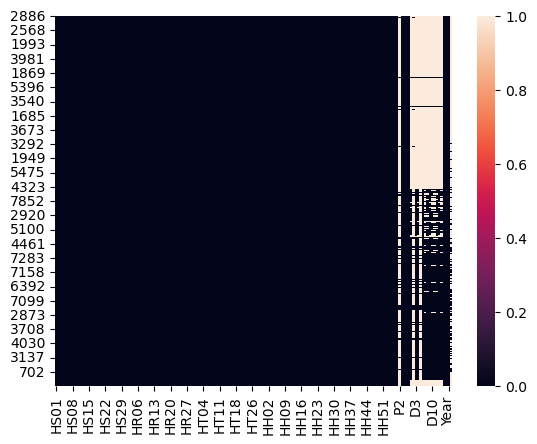

In [207]:
# Observe nulls heatmap

sns.heatmap(df_imputed.isnull())
plt.show()

In [208]:
# Some health checks for df_imputed

df_imputed.shape

(7820, 170)

In [209]:
# Column groups to be shifted, normalized, and scaled as described above

add_to_one_groups = [('HH01','HH02'), 
                     ('HH03','HH13'), 
                     ('HH14','HH24'), 
                     ('HH25','HH30'), 
                     ('HH31','HH36'), 
                     ('HS01','HS11'),
                     #('HS01', 'HS12', 'HS14'),
                     ('HS15','HS15'),
                     ('HS16','HS16'),
                     ('HT01','HT09'),
                     ('HT20','HT25')]


average_groups = [('HS17','HS30'),
                ('HT10','HT18'),
                ('HT26','HT31'),
                ('HR01','HR06'),
                ('HR07','HR12'),
                ('HR13','HR18'),
                ('HR19','HR24'),
                ('HR25','HR30'),
                  ('HH37','HH38'),
                  ('HH39','HH40'),
                  ('HH41','HH42'),
                  ('HH43','HH44'),
                  ('HH45','HH46'),
                  ('HH47','HH48'),
                  ('HH49','HH50'),
                  ('HH51','HH52'),
                  ('HH53','HH54'),
                  ('HH55','HH56')]
                    

In [210]:
# Add-to-one groups normalization. Fetching most negative value per row in each add-to-one group

denegify_groups = add_to_one_groups + average_groups

min_neg_dict = {}

# define the start and end of column groupings to be shifted and normalized
for start, end in denegify_groups:
    
    # create row set to be analyzed within each column set
    for row, column in df_imputed.loc[:, start:end].iterrows():
        min_val = min(df_imputed.loc[row, start:end])
        if min_val < 0:
            min_neg_dict[row] = min_val
            
    for row, min_neg in min_neg_dict.items():
        df_imputed.loc[row, start:end] += (abs(min_neg))
        #print(f"Row {row}, Group: {start}:{end}, Adding {abs(min_neg)}")
                
            

In [211]:
# Check to make sure all negative h_col negative values are gone

zero_mask = df_imputed.select_dtypes(include=['number'])<0

df_imputed.select_dtypes(include=['number']).loc[zero_mask.any(axis=1), zero_mask.any(axis=0)]

HS12      HS13       HS14
3462  0.588581  1.665350  -0.013444
3654  1.019237 -0.006330  -0.587523
705   0.912340 -0.166262  -0.230452
641   0.175999 -0.342046   0.030824
4102  0.405774 -0.440741  -0.160026
...        ...       ...        ...
704  -0.157994 -0.260913  -0.003184
6665  2.009836 -4.114737  -0.079313
2629 -1.331371  0.237255  10.668619
5769 -0.992485  0.817668   1.121492
5447 -3.947850 -0.243016   7.921844

[3785 rows x 3 columns]

In [212]:
# manually denegify these rows as the add-to-one group was not comprised of sequential parts

for row, column in df_imputed[['HS01', 'HS12', 'HS13', 'HS14']].iterrows():
    min_val = min(df_imputed.loc[row, ['HS01', 'HS12', 'HS13', 'HS14']])
    if min_val < 0:
        df_imputed.loc[row, ['HS01', 'HS12', 'HS13', 'HS14']] += abs(min_val)
            

In [213]:
# Normalize add-to-one columns
# Divide each column by the row sum for that group

for start, end in add_to_one_groups:
    row_sum = df_imputed.loc[:, start:end].sum(axis=1)
    df_imputed.loc[:, start:end] = df_imputed.loc[:, start:end].div(row_sum, axis=0)
    

In [214]:
# Assertion error on add-to-one. Check values manually

df_imputed.loc[:, start:end].sum(axis=1).value_counts()

# Appears to be floating point errors

1.0    4695
1.0    1615
1.0    1010
1.0     471
1.0      24
1.0       3
1.0       2
dtype: int64

In [215]:
# define a reasonable range for averages columns using pre-scaled min/max values from average columns
# not defining min/max per country to avoid introducing country bias

# (start, end, group_range)

min_max_range = []

for start, end in average_groups:
    group_max = df_mstr.loc[:, start:end].max().max()
    group_min = df_mstr.loc[:, start:end].min().min()
    min_max_range.append([start, end, group_min, group_max])


In [216]:
# use the pre-imputation ranges established to scale averages groups
# only applying scaling to rows that were imputed, which are captured in h_nulls_index

scaled_updates = []

for start, end, group_min, group_max in min_max_range:
    scaler = MinMaxScaler(feature_range=(group_min, group_max))
    scaled_data = scaler.fit_transform(df_imputed.loc[:, start:end])
    scaled_data_df = pd.DataFrame(scaled_data, columns=df_imputed.loc[:,start:end].columns, index=df_imputed.index)
    scaled_updates.append(scaled_data_df)
    scaled_updates_df = pd.concat(scaled_updates, axis=1)

df_imputed.update(scaled_updates_df)

In [217]:
# now that core features are scaled use them to impute missing values in non-core features
# leverage unique_countries list
# do not impute target yet

numeric_feature_cols = df_imputed.select_dtypes(include=['number']).columns.drop(['Gini','Year']).tolist()

for country in unique_countries:
    
    imputer = IterativeImputer(random_state=21, tol=1e-4)
    
    country_rows = df_imputed['Country Code']==country
    
    informative_cols = df_imputed.loc[country_rows, numeric_feature_cols].apply(lambda col: col.notnull().sum()>1)
    informative_cols_index = informative_cols[informative_cols].index
    
    country_block = df_imputed.loc[country_rows, informative_cols_index]
    
    imputed_data = imputer.fit_transform(country_block)
    
    imputed_data_df = pd.DataFrame(imputed_data, columns=country_block.columns, index=country_block.index)
    
    df_imputed.loc[country_block.index, country_block.columns] = imputed_data_df
    
# make a fresh copy to clear memory fragmentation issues downstream
df_imputed = df_imputed.copy()

<Axes: >

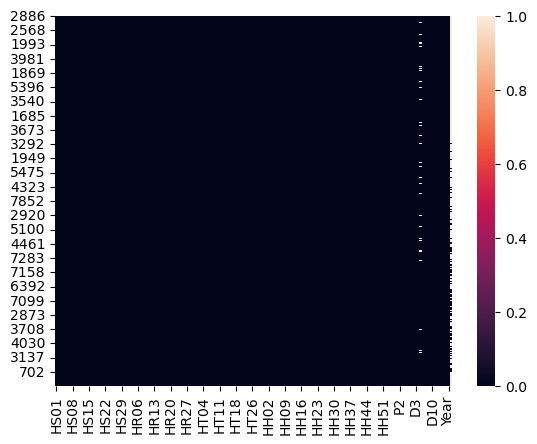

In [218]:
# Check missing values again
sns.heatmap(df_imputed.isnull())

In [219]:
# percent of countries with more than two gini values
(df_imputed.groupby('Country Code')['Gini'].count()>4).mean()

0.8442622950819673

In [220]:
# use KNN to impute missing Gini values

updates = []

for country in unique_countries:
    imputer = KNNImputer(n_neighbors=2)
    country_block = df_imputed.loc[df_imputed['Country Code']==country, ['Gini']]
    imputed_data = imputer.fit_transform(country_block)
    imputed_data_df = pd.DataFrame(
        imputed_data, columns=country_block.columns, index=country_block.index
    )
    updates.append(imputed_data_df)
    updates_df = pd.concat(updates)
    
df_imputed.update(updates_df)

In [221]:
# Backfill and forwardfill all remaining null values

df_imputed = df_imputed.groupby('Country Code', group_keys=False).apply(lambda group: group.bfill().ffill())

In [222]:
# Check for null values
# Fill Kosovo d-cols with column mean

nulls_mask = df_imputed.isnull()

#df_imputed.loc[nulls_mask.any(axis=1), nulls_mask.any(axis=0)]

df_imputed = df_imputed.fillna(df_imputed.mean(numeric_only=True))

df_imputed.isna().sum().sum()

0

### Iterative Imputer (df_imputed) Summary

Feature Imputation

In Section III A we handled missing values with linear spline interpolation, which was simple and computationally low cost,  but may introduce excessive linear bias into the data. The goal of Section III B was to handle missing values in a more intelligent, robust way. In the final part of Section III, we will handle missing values using matrix decomposition methods.

In preparation for algorithmic imputation, additional observations for non-core features were imported from United Nations data (see Table 2 and Table 3). Non-core features columns in the CoResidence database start with 'D' (development indicators) or 'P' (population indicators). Once these additional rows were brought in, we leveraged these features to perform a more robust imputation of "core features" (columns starting with 'H', pertaining to household configuration).

- To impute missing values in the "core features" I chose Bayesian Ridge estimator inside of Iterative Imputer. ayesian Ridge assumes a prior distribution for model coefficients, which are updated as new data is encountered. The prior assumptions act as a regularization buffer, which accomodates modestly non-linear data and performs well on sparse, high dimensional data. In short, Bayesian Ridge is like a resilient and flexible linear regression.

- Within the loop that executes Iterative Imputer, I used a dynamic threshold of 60% sparsity per "informative column" for the supplemental columns assisting in imputation. In other words, for some countries, some reference columns were excluded.

- Once values were imputed, I normalized the results as follows:
    - Any and all negative values shifted
    - Add-to-one column groups scaled to add to one
    - Averages column groups scaled to min/max with a range defined by pre-scaled values for those columns
    
- After normalization, I turned around and imputed any missing P/D values using Iterative Imputer. While this appears to introduce circular imputation, the circle is interrupted in two ways: (1) Core features initially imputed started with at least two rows of real observations per country, which means that the initial imputation was anchored in something real; and (2) Normalizing the initial imputation output assumed that whatever essence was captured in the first round of imputation, once scaled, contains directional truth that may be more informative once scaled to proper magnitude.

Target Imputation
- Gaps in Gini values were imputed using Iterative Imputer with KNN estimator, to avoid coercing linearity. KNN Imputer was not used in the initial imputation step, because distance-based estimators are not robust to sparse data or high dimensional data. 84% of countries have at least 5 native Gini values, which should be enough to detect both linear non-linear patterns.

# Section IV - Preprocessing Comparison Modelling 

In [251]:
# Create a 'Gini_inverted' column so that the model can identify what leads to a 

df_imputed['Gini_inverted'] = 100 - df_imputed['Gini']
df_imputed = df_imputed.copy()

In [252]:
df_imputed.columns

Index(['HS01', 'HS02', 'HS03', 'HS04', 'HS05', 'HS06', 'HS07', 'HS08', 'HS09',
       'HS10',
       ...
       'D10', 'D11', 'D12', 'D13', 'D14', 'Country Name', 'Country Code',
       'Year', 'Gini', 'Gini_inverted'],
      dtype='object', length=171)

In [253]:
# Split the data

X = df_imputed.drop(columns=['Country Name', 'Country Code','Year', 'Gini', 'Gini_inverted'])
y = df_imputed['Gini_inverted']

In [254]:
# run random forest model again

tscv = TimeSeriesSplit(n_splits=3)

models = {'Gradient Boost': GradientBoostingRegressor(random_state=21),
         'Random Forest': RandomForestRegressor(random_state=21),
         'Linear Regression': LinearRegression()}

tscv_loop(X, y, 3, models=models)


Fold  Gradient Boost Train Score  Gradient Boost Test Score  \
0     1                    0.991897                   0.872119   
1     2                    0.976004                   0.818012   
2     3                    0.948947                   0.807424   

   Random Forest Train Score  Random Forest Test Score  \
0                   0.998527                  0.868743   
1                   0.995897                  0.817310   
2                   0.994121                  0.719493   

   Linear Regression Train Score  Linear Regression Test Score  
0                       0.959428                      0.415537  
1                       0.895231                      0.369524  
2                       0.838327                      0.547604

In [228]:
# feature importances on inverted model

gb_feature_importances = gb_model.feature_importances_
rf_feature_importances = rf_model.feature_importances_

In [229]:
# name mapping dictionary

col_names_mapping = {
    code: description for code, description in zip(code_dict['Code'], code_dict['Description'])
}


In [230]:
# feature importances dataframe

df_feature_importances = pd.DataFrame({
    "Feature" : X.columns,
    "Gradient Boost Importances": gb_feature_importances,
    "Random Forest Importances": rf_feature_importances
})

In [231]:
df_feature_importances['Feature'] = df_feature_importances['Feature'].replace(col_names_mapping)
df_feature_importances.sort_values('Gradient Boost Importances', ascending=True)

Feature  \
22   Average number of 10-19 individuals in the hou...   
42      Average number of Heads in 3 persons household   
41   Average number of Other relative or Non relati...   
86   Average size of stem-family households based o...   
149                                    Life expectancy   
..                                                 ...   
25   Average number of 40-49 individuals in the hou...   
156                              Gross Domestic income   
0                    Proportion of 1-person households   
92   Proportion of 1-person households of male-head...   
164                       Mean years of schooling male   

     Gradient Boost Importances  Random Forest Importances  
22                     0.000000                   0.001454  
42                     0.000000                   0.000410  
41                     0.000000                   0.000582  
86                     0.000000                   0.001431  
149                    0.000000                   0.000381  
..                          ...                        ...  
25                     0.039105                   0.002814  
156                    0.042655                   0.022537  
0                      0.050536                   0.059629  
92                     0.070631                   0.061863  
164                    0.234451                   0.286164  

[166 rows x 3 columns]

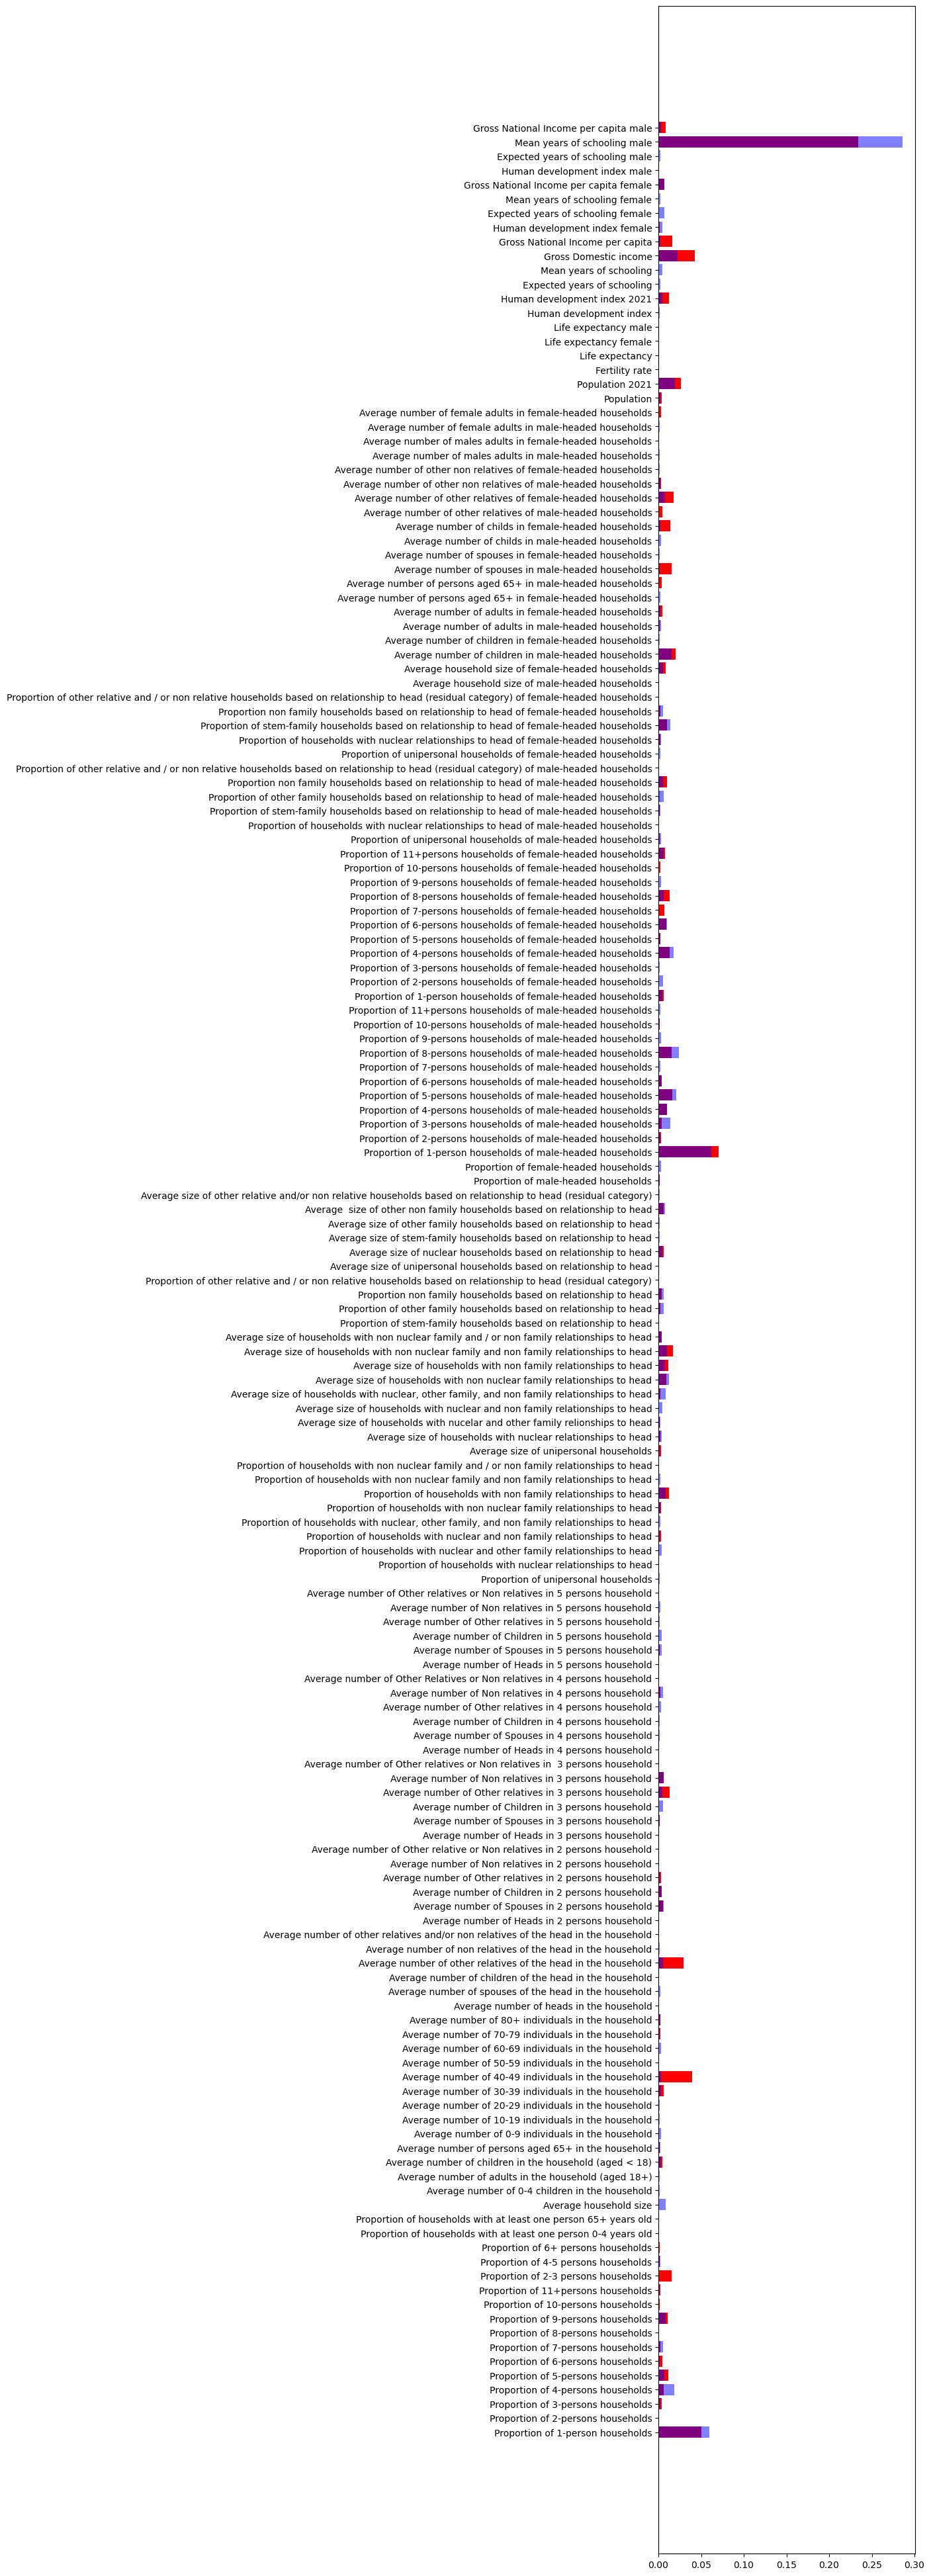

In [232]:
# Plot feature importances most predictive of inverted gini

plt.figure(figsize=(5,50))
plt.barh(df_feature_importances['Feature'], df_feature_importances['Gradient Boost Importances'], color='red')
plt.barh(df_feature_importances['Feature'], df_feature_importances['Random Forest Importances'], color='blue', alpha=0.5)
plt.show()

### Ridge and Lasso comparisons

In [233]:

print(df_baseline.columns)
print(df_imputed.columns)

Index(['C3', 'HS01', 'HS02', 'HS03', 'HS04', 'HS05', 'HS06', 'HS07', 'HS08',
       'HS09',
       ...
       'D10', 'D11', 'D12', 'D13', 'D14', 'Country Name', 'Country Code',
       'Year', 'Gini', 'Gini_interpol'],
      dtype='object', length=172)
Index(['HS01', 'HS02', 'HS03', 'HS04', 'HS05', 'HS06', 'HS07', 'HS08', 'HS09',
       'HS10',
       ...
       'D10', 'D11', 'D12', 'D13', 'D14', 'Country Name', 'Country Code',
       'Year', 'Gini', 'Gini_inverted'],
      dtype='object', length=171)


In [234]:
# invert target on df_baseline

df_baseline['Gini_inverted'] = 100 - df_baseline['Gini']

In [235]:
# split the data

# nulls dropped (add this later)

# interpolated
X_interpol = df_baseline.drop(columns=['C3', 'Country Name', 'Country Code','Year', 'Gini', 'Gini_interpol','Gini_inverted'])
y_interpol = df_baseline['Gini_inverted']

# imputed
X_imputed = df_imputed.drop(columns=['Country Name', 'Country Code','Year', 'Gini', 'Gini_inverted'])
y_imputed = df_imputed['Gini_inverted']

# scale data

scaler = StandardScaler()

X_interpol_scaled = scaler.fit_transform(X_interpol)
X_imputed_scaled = scaler.fit_transform(X_imputed)

0.06945855712004645

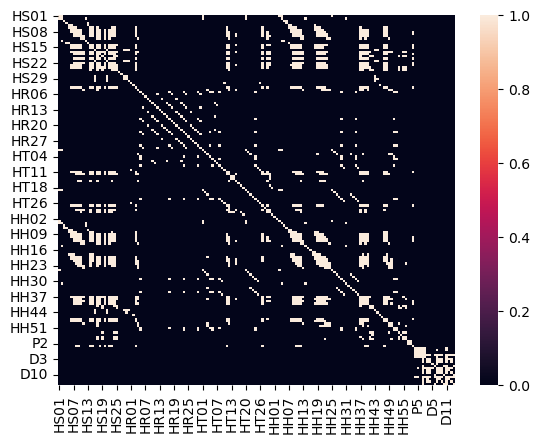

In [236]:
correlation_matrix_interpol = X_interpol.corr()
sns.heatmap((correlation_matrix_interpol>0.8))
(correlation_matrix_interpol>0.8).sum().sum()/correlation_matrix_interpol.size

<Axes: >

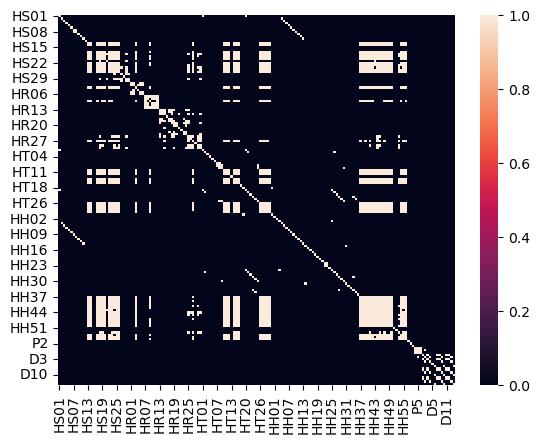

In [237]:
correlation_matrix_imputed = X_imputed.corr()>0.8
sns.heatmap(correlation_matrix_imputed)

In [ ]:
# Run the RidgeCV/LassoCV comparison

tscv = TimeSeriesSplit(n_splits=3)

ridge = Ridge(alpha=1.0, max_iter=5000)
lasso = Lasso(alpha=1.0, max_iter=5000)

# interpolated
ridge_score_interpol = cross_val_score(ridge, X_interpol_scaled, y_interpol, cv=tscv).mean()
lasso_score_interpol = cross_val_score(lasso, X_interpol, y_interpol, cv=tscv).mean()

# imputed
ridge_score_imputed = cross_val_score(ridge, X_imputed_scaled, y_imputed, cv=tscv).mean()
lasso_score_imputed = cross_val_score(lasso, X_imputed, y_imputed, cv=tscv).mean()

print(f"Interpolated Data - Ridge Score: {ridge_score_interpol}, Lasso Score: {lasso_score_interpol}")
print(f"Imputed Data - Ridge Score: {ridge_score_imputed}, Lasso Score: {lasso_score_imputed}")

/Users/lilianburgler/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.613e+04, tolerance: 9.921e+00
  model = cd_fast.enet_coordinate_descent(
/Users/lilianburgler/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.471e+04, tolerance: 1.949e+01
  model = cd_fast.enet_coordinate_descent(
/Users/lilianburgler/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Interpolated Data - Ridge Score: -0.48185449034607813, Lasso Score: 0.07282219355177648
Imputed Data - Ridge Score: 0.5212445125222489, Lasso Score: 0.228105808105495


/Users/lilianburgler/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.517e+05, tolerance: 3.975e+01
  model = cd_fast.enet_coordinate_descent(


2

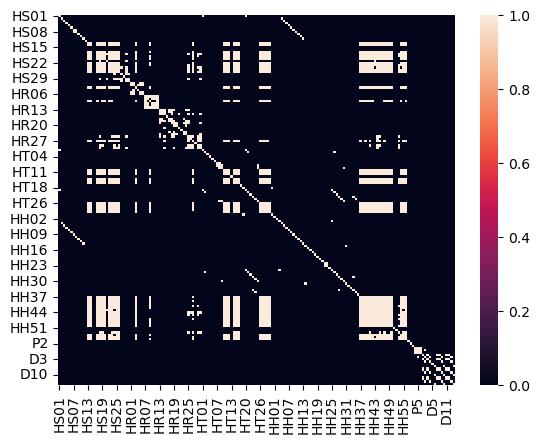

In [ ]:
# check correlation on scaled 

X_interpol_scaled_df = pd.DataFrame(X_interpol_scaled, columns=X_interpol.columns)
#sns.heatmap(X_interpol_scaled_df.corr()>0.8)
(X_interpol_scaled_df.corr()>0.8).sum().sum()/X_interpol_scaled_df.size
(X_interpol_scaled_df.std()<1e-3).sum()

X_imputed_scaled_df = pd.DataFrame(X_imputed_scaled, columns=X_imputed.columns)
sns.heatmap(X_imputed_scaled_df.corr()>0.8)
(X_imputed_scaled_df.corr()>0.8).sum().sum()/X_imputed_scaled_df.size
(X_imputed_scaled_df.std()<1e-3).sum()

### Non-Negative Matrix Factorization

I chose Non-Negative Matrix Factorization (NMF) over Truncated SVD because my data consists entirely of non-negative values (a requirement for NMF). Additionally, NMF provides greater interpretability by ensuring that each latent feature is a combination of additive contributions from the original features. While all matrix decomposition methods approximate the data through dimensionality reduction and vector scaling, NMF uniquely preserves part-based representations, allowing us to see the individual contributions of original features to each latent feature—making it ideal for understanding topic-like structures in the data.

NMF is slower, computationally, but better at preserving the objects we care about.

In [ ]:
# create a copy of df_mstr to subject to SVD reconstruction

df_decompose = df_mstr.copy()

In [ ]:
# sort values to maintain order of meaningful structure for purposes of decomposition

df_decompose = df_decompose.sort_values(by=['Country Code', 'Year'])

In [89]:
# fill null values with respective column means to prepare for nmf

df_decompose = df_decompose.groupby('Country Code').apply(lambda x: x.fillna(x.mean()))

NameError: name 'df_decompose' is not defined

In [247]:
# knn impute gini values to prepare a y vector

unique_countries = df_decompose['Country Code'].unique().tolist()

country_blocks = []

for country in unique_countries:
    knn = KNNImputer(n_neighbors=2)
    country_block = df_decompose.loc[df_decompose['Country Code']==country, ['Gini']]
    country_block_imputed = knn.fit_transform(country_block)
    country_block_df = pd.DataFrame(country_block_imputed, columns=['Gini_knn'], index=country_block.index)
    country_blocks.append(country_block_df)
df_knn_gini = pd.concat(country_blocks)

# verify that indices match, prior to modelling
df_decompose.index.equals(df_knn_gini.index)


True

In [248]:
# split the data

X = df_decompose.drop(columns=['Country Name', 'Year', 'Gini'])


In [243]:
# scale x for nmf

scaler = MinMaxScaler()

X_mm_scaled = scaler.fit_transform(X_filled)

In [416]:
# retry NMF with varying values for n_components

n_components_range = [10, 20, 40, 60]
print(df_knn_gini.index.equals(df_nmf_reconstructed.index))

all_results = []

for n_components in n_components_range:
    print(f"Running NMF for n_components={n_components}")
    nmf = NMF(n_components=n_components, max_iter=5000, random_state=21)
    W = nmf.fit_transform(X_mm_scaled)
    H = nmf.components_
    nmf_reconstructed = np.dot(W, H)
    df_nmf_reconstructed = pd.DataFrame(nmf_reconstructed, columns=X_filled.columns, index=X_filled.index)
    print(f"NMF Completed")
    
    # concat and shuffle
    df_nmf_reconstructed['Year'] = X_filled['Year']

    X = df_nmf_reconstructed
    y = df_knn_gini['Gini_knn']
    
    print(f"Processing tscv_loop")

    #df_results = tscv_loop(X, y, 3)
    #df_results['n_components'] = n_components
    #all_results.append(df_results)

True
Running NMF for n_components=10
NMF Completed


KeyError: 'Year'

In [417]:
X_filled

HS01      HS02      HS03      HS04      HS05      HS06      HS07  \
0     0.072120  0.236134  0.187048  0.210329  0.154093  0.086375  0.033020   
1     0.072120  0.236134  0.187048  0.210329  0.154093  0.086375  0.033020   
2     0.072120  0.236134  0.187048  0.210329  0.154093  0.086375  0.033020   
3     0.072120  0.236134  0.187048  0.210329  0.154093  0.086375  0.033020   
4     0.072120  0.236134  0.187048  0.210329  0.154093  0.086375  0.033020   
...        ...       ...       ...       ...       ...       ...       ...   
7879  0.117011  0.122688  0.158706  0.164451  0.144659  0.104978  0.073354   
7880  0.117011  0.122688  0.158706  0.164451  0.144659  0.104978  0.073354   
7881  0.117011  0.122688  0.158706  0.164451  0.144659  0.104978  0.073354   
7882  0.117011  0.122688  0.158706  0.164451  0.144659  0.104978  0.073354   
7883  0.117011  0.122688  0.158706  0.164451  0.144659  0.104978  0.073354   

          HS08      HS09      HS10  ...     D5           D6        D7  \
0     0.011946  0.004984  0.001881  ...  0.970  8727.486591  0.699497   
1     0.011946  0.004984  0.001881  ...  0.970  8727.486591  0.699497   
2     0.011946  0.004984  0.001881  ...  0.970  8727.486591  0.699497   
3     0.011946  0.004984  0.001881  ...  0.970  8727.486591  0.699497   
4     0.011946  0.004984  0.001881  ...  0.970  8727.486591  0.699497   
...        ...       ...       ...  ...    ...          ...       ...   
7879  0.052744  0.024255  0.015047  ...  0.915  2156.431862  0.538675   
7880  0.052744  0.024255  0.015047  ...  0.915  1935.505995  0.535341   
7881  0.052744  0.024255  0.015047  ...  0.915  2051.668129  0.538319   
7882  0.052744  0.024255  0.015047  ...  0.915  2078.918063  0.531924   
7883  0.052744  0.024255  0.015047  ...  0.915  1870.354852  0.462067   

             D8        D9          D10       D11        D12       D13  \
0     12.796109  8.561611  6629.369891  0.738848  12.781240  9.484811   
1     12.796109  8.561611  6629.369891  0.738848  12.781240  9.484811   
2     12.796109  8.561611  6629.369891  0.738848  12.781240  9.484811   
3     12.796109  8.561611  6629.369891  0.738848  12.781240  9.484811   
4     12.796109  8.561611  6629.369891  0.738848  12.781240  9.484811   
...         ...       ...          ...       ...        ...       ...   
7879  10.651119  8.070020  1804.460974  0.580313  11.359176  9.462640   
7880  10.695159  8.190793  1643.892266  0.572064  11.375836  9.590724   
7881  10.695159  8.190793  1963.726056  0.559934  11.375836  9.590724   
7882  10.695159  8.190793  1761.979860  0.568315  11.375836  9.590724   
7883  10.030848  6.478315  1608.322094  0.509741  11.049002  7.923256   

               D14  
0     10828.711478  
1     10828.711478  
2     10828.711478  
3     10828.711478  
4     10828.711478  
...            ...  
7879   2551.748403  
7880   2262.626717  
7881   2150.173744  
7882   2433.257978  
7883   2256.662494  

[7884 rows x 166 columns]

In [415]:
# inspect results
df_all_results = pd.concat(all_results).reset_index(drop=True)
columns = ['Fold', 'n_components'] + df_all_results.columns[df_all_results.columns.str.contains('Test')].tolist()
df_all_results.loc[df_all_results['Fold']==3, columns]


Fold  n_components  Linear Regression Test Score  Lasso Test Score  \
2      3            10                      0.386684          0.418612   
5      3            20                      0.377790          0.393962   
8      3            40                      0.458243          0.453229   
11     3            60                      0.353702          0.473760   

    Ridge Test Score  Random Forest Test Score  
2           0.391107                  0.583365  
5           0.380463                  0.458160  
8           0.479721                  0.406015  
11          0.436981                  0.446497